## Del Desastre del Titanic al Aprendizaje Automático.


### Introducción  

El hundimiento del Titanic en 1912 es una de las tragedias marítimas más conocidas de la historia. De los 2,224 pasajeros y tripulantes a bordo, más de 1,500 perdieron la vida cuando el barco chocó contra un iceberg en su viaje inaugural. Este desastre no solo conmocionó al mundo, sino que, más allá de su impacto histórico, el Titanic se ha convertido en un caso de estudio fascinante para la ciencia de datos.

En este notebook, comienza por realizar un análisis exploratorio de datos (EDA) con el fin de identificar patrones clave, como la influencia del género, la clase y la edad en la tasa de supervivencia. Luego, se aplican técnicas de ingeniería de características para transformar y enriquecer los datos, antes de entrenar los modelos de machine learning. Finalmente, utilizan técnicas de ensamblaje avanzadas para optimizar la precisión de las predicciones.

Durante el proceso de modelado, se evalua el rendimiento de los clasificadores utilizando métricas como la **precisión (Accuracy)**, la **curva ROC-AUC** y la **matriz de confusión**, asegurando un análisis robusto tanto en términos predictivos como interpretativos.

### Propósito del Notebook

El objetivo es realizar un análisis lo más completo posible del reto del Titanic en [Kaggle](https://www.kaggle.com/c/titanic/overview), abordando el problema desde una perspectiva analítica y predictiva. 

- Introducción
- Carga de librerías
- Carga de datos
- Análisis Exploratorio
  - Descripción General
  - Descripción de Características
  - Distribución de Características
  - Representatividad de la información
  - Valores Faltantes
  - Imputación
  - Outliers
  - Correlaciones
- Ingeniería de Características
  - Codificación de Frecuencias
  - Características Sintéticas
  - Categorización de valores continuos
  - Análisis de variables
  - Selección de Características
- Transformación de características
- Train set y Test set
- Modelación
  - Modelo Baseline
  - Clasificadores
  - Ajuste de hiperparámetros
  - Curvas de aprendizaje
  - Importancia de características
  - Reentrenamiento
  - Ensamble
  - Mejor Modelo
  - Predicción

### Carga de Librerías

In [1]:
# Manipulación de datos 
import numpy as np                    # Operaciones numéricas
import pandas as pd                   # Estructuras y análisis de datos

# Visualización 
import matplotlib.pyplot as plt       # Gráficos básicos
import seaborn as sns                 # Gráficos estadísticos
import missingno as msno              # Valores faltantes
import plotly.express as px           # Visualización interactiva
import scikitplot as skplt            # Métricas visuales de modelos

# Utilidades
import string                         # Manejo de texto
import math                           # Funciones matemáticas
from IPython.display import display   # Mejor visualización en notebooks

# Manejo de advertencias 
import warnings
warnings.filterwarnings('ignore')     # Ocultar advertencias

# Preprocesamiento/ Feature Engineering
from sklearn.preprocessing import (
    LabelEncoder, OneHotEncoder, OrdinalEncoder,
    StandardScaler)

from sklearn.feature_selection import chi2
from sklearn.metrics import mutual_info_score
from sklearn.compose import ColumnTransformer

# Modelos de Clasificación
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier, RandomForestClassifier,
    ExtraTreesClassifier, 
    GradientBoostingClassifier,
    VotingClassifier, StackingClassifier
)
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier

# Entrenamiento/Evaluacion
from sklearn.model_selection import (
    cross_val_score, StratifiedKFold,
    RandomizedSearchCV, 
    GridSearchCV,
    learning_curve
)
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc, 
    ConfusionMatrixDisplay
)

In [2]:
# Paleta de colores
palette = ["#273176","#3B61A3","#76A4AC","#BFD4B2","#DAD8A1"]
palette_1 = ["#292F55","#273176","#223A92","#3B61A3","#76A4AC","#BFD4B2","#DAD8A1","#C7B679","#957447"]
palette_2 = ["#3B61A3","#76A4AC"]

### Carga de Datos

In [3]:
# DataFrame de entrenamiento y prueba
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Verificación de datos
display(f"Training Set - Filas: {train.shape[0]}, Columnas: {train.shape[1]}")
display(f"Test Set - Filas: {test.shape[0]}, Columnas: {test.shape[1]}")

'Training Set - Filas: 891, Columnas: 12'

'Test Set - Filas: 418, Columnas: 11'

Para facilitar la manipulación y preprocesamiento de los datos, se combinan ambos conjuntos en un único DataFrame temporal. Esto nos permitirá aplicar de manera uniforme diversas técnicas de preprocesamiento, como imputación de valores faltantes, codificación de variables y escalado de características y, posteriormente, separar los datos para el entrenamiento del modelo.

La distinción entre ambos conjuntos, se realiza con una nueva columna llamada `'set'`, que permite identificar si un registro pertenece al conjunto de entrenamiento o prueba. Además, se incluye la columna `'survived'` en el conjunto de prueba, rellenándola con valores `NaN`, de modo que su estructura sea idéntica a la del conjunto de entrenamiento.

In [4]:
# Concatenación de DataFrames
def concat_df(df_list, reset_index=True, ignore_index=False, sort_columns=True, axis=0):
    """
    Concatena una lista de DataFrames en uno solo con opciones avanzadas.

    Args:
        df_list (list): Una lista de DataFrames para concatenar.
        reset_index (bool, optional): Si es True, resetea el índice del DataFrame resultante
                                       y elimina el índice anterior. Por defecto es True.
        ignore_index (bool, optional): Si es True, ignora los índices individuales de los
                                        DataFrames concatenados y asigna un nuevo índice
                                        secuencial. Tiene prioridad sobre reset_index.
                                        Por defecto es False.
        sort_columns (bool, optional): Si es True, ordena las columnas del DataFrame resultante
                                       alfabéticamente. Por defecto es True.
        axis (int, optional): El eje a lo largo del cual concatenar. 0 para concatenar
                             verticalmente (añadiendo filas), 1 para concatenar
                             horizontalmente (añadiendo columnas). Por defecto es 0.

    Returns:
        pd.DataFrame: El DataFrame resultante de la concatenación.
    """
    if not isinstance(df_list, list):
        raise TypeError("df_list debe ser una lista de DataFrames.")
    if not df_list:
        return pd.DataFrame()  # Retorna un DataFrame vacío si la lista está vacía

    concatenated_df = pd.concat(df_list, ignore_index=ignore_index, sort=sort_columns, axis=axis)

    if reset_index and not ignore_index:
        concatenated_df = concatenated_df.reset_index(drop=True)

    return concatenated_df

In [5]:
# Concatenación train-test
combined_df = concat_df([train, test])

# Columnas(nombres) a minúsculas
combined_df.columns = combined_df.columns.str.lower()

In [6]:
# División de DataFrames
def divide_df_by_index(df, split_index_value, drop_columns_first=None, drop_columns_second=None):
    """
    Divide un DataFrame en dos DataFrames según un valor de índice y permite
    excluir columnas específicas en cada uno.

    Args:
        df (pd.DataFrame): El DataFrame a dividir.
        split_index_value (int): El valor del índice hasta el cual se incluirá
                                 en el primer DataFrame.
        drop_columns_first (list, optional): Lista de nombres de columnas a eliminar
                                              del primer DataFrame. Por defecto es None.
        drop_columns_second (list, optional): Lista de nombres de columnas a eliminar
                                               del segundo DataFrame. Por defecto es None.

    Returns:
        tuple: Una tupla que contiene dos DataFrames:
               - df_primero: DataFrame con las filas cuyo índice es menor o igual a
                             split_index_value, con las columnas especificadas eliminadas.
               - df_segundo: DataFrame con las filas cuyo índice es mayor a
                             split_index_value, con las columnas especificadas eliminadas.
    """
    df_primero = df.loc[:split_index_value].copy()
    df_segundo = df.loc[split_index_value + 1:].copy()

    if drop_columns_first:
        columns_to_drop_first = [col for col in drop_columns_first if col in df_primero.columns]
        df_primero = df_primero.drop(columns=columns_to_drop_first, axis=1, errors='ignore')

    if drop_columns_second:
        columns_to_drop_second = [col for col in drop_columns_second if col in df_segundo.columns]
        df_segundo = df_segundo.drop(columns=columns_to_drop_second, axis=1, errors='ignore')

    return df_primero, df_segundo

In [7]:
# División de DataFrames:
train_df, test_df = divide_df_by_index(combined_df, 890, None, ['survived'])

In [8]:
# Columna 'set' para distinguir entre entrenamiento y prueba
train_df['set'] = 'Train'
test_df['set'] = 'Test'

In [9]:
# Recombinar combined_df 
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# Verificación de carga y combinación de datos
display(f"Training Set - Filas: {train_df.shape[0]}, Columnas: {train_df.shape[1]}")
display(f"Test Set - Filas: {test_df.shape[0]}, Columnas: {test_df.shape[1]}")
display(f"Combined Set - Filas: {combined_df.shape[0]}, Columnas: {combined_df.shape[1]}\n")

'Training Set - Filas: 891, Columnas: 13'

'Test Set - Filas: 418, Columnas: 12'

'Combined Set - Filas: 1309, Columnas: 13\n'

### Análisis Exploratorio  

**Descripción General**

In [10]:
# Información datos de entrenamiento y prueba
print("*Train Data*:")
train_df.info()

# Muestra aleatoria de 3 filas- train
print("\nRandom sample (3 rows):")
display(train_df.sample(3))

print("\n*Test Data*:")
test_df.info()

# Muestra aleatoria de 3 filas- test
print("\nRandom sample (3 rows):")
display(test_df.sample(3))

*Train Data*:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          714 non-null    float64
 1   cabin        204 non-null    object 
 2   embarked     889 non-null    object 
 3   fare         891 non-null    float64
 4   name         891 non-null    object 
 5   parch        891 non-null    int64  
 6   passengerid  891 non-null    int64  
 7   pclass       891 non-null    int64  
 8   sex          891 non-null    object 
 9   sibsp        891 non-null    int64  
 10  survived     891 non-null    float64
 11  ticket       891 non-null    object 
 12  set          891 non-null    object 
dtypes: float64(3), int64(4), object(6)
memory usage: 90.6+ KB

Random sample (3 rows):


age    cabin embarked      fare  \
98   34.0      NaN        S   23.0000   
299  50.0  B58 B60        C  247.5208   
371  18.0      NaN        S    6.4958   

                                                name  parch  passengerid  \
98              Doling, Mrs. John T (Ada Julia Bone)      1           99   
299  Baxter, Mrs. James (Helene DeLaudeniere Chaput)      1          300   
371                        Wiklund, Mr. Jakob Alfred      0          372   

     pclass     sex  sibsp  survived    ticket    set  
98        2  female      0       1.0    231919  Train  
299       1  female      0       1.0  PC 17558  Train  
371       3    male      1       0.0   3101267  Train


*Test Data*:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 891 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          332 non-null    float64
 1   cabin        91 non-null     object 
 2   embarked     418 non-null    object 
 3   fare         417 non-null    float64
 4   name         418 non-null    object 
 5   parch        418 non-null    int64  
 6   passengerid  418 non-null    int64  
 7   pclass       418 non-null    int64  
 8   sex          418 non-null    object 
 9   sibsp        418 non-null    int64  
 10  ticket       418 non-null    object 
 11  set          418 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 39.3+ KB

Random sample (3 rows):


age cabin embarked      fare                                   name  \
1133  45.0   E34        C  134.5000           Spedden, Mr. Frederic Oakley   
1119  40.5   NaN        S   15.1000              Everett, Mr. Thomas James   
1265  54.0   A34        S   81.8583  Dodge, Mrs. Washington (Ruth Vidaver)   

      parch  passengerid  pclass     sex  sibsp     ticket   set  
1133      1         1134       1    male      1      16966  Test  
1119      0         1120       3    male      0  C.A. 6212  Test  
1265      1         1266       1  female      1      33638  Test

**Descripción de las Características**

| Tipo de Característica | Features                          | 
|------------------------|-----------------------------------|
| **Categóricas**        |                                   |
| - Nominales            | `Survived`, `Sex`, `Embarked`     |
| - Ordinales            | `Pclass`                          |
| **Numéricas**          |                                   |
| - Discretas            | `SibSp`, `Parch`                  |
| - Continuas            | `Age`, `Fare`                     | 
| **Mixtas**             |                                   |
| - Numéricas y Alfanuméricas | `Ticket`                     |
| - Alfanuméricas        | `Cabin`                           |
| **Texto/Identificadores** | `Name`                            |
| **Valores Nulos**      |                                   |
| - Training Set         | `Cabin` > `Age` > `Embarked`      |
| - Test Set             | `Cabin` > `Age` > `Fare`          |
| **Tipos de Datos**     |                                   |
| - Enteros/Flotantes    | 7 (Train), 6 (Test)               |
| - Cadenas (Objeto)     | 5                                 |

**Distribución de las Características**

 ***Categóricas***  

- **Name**: Todos los nombres son únicos (recuento = 891).
- **Sex**: Hay dos valores posibles, con un 65% de pasajeros varones (top = male, frecuencia = 577/891).
- **Ticket**: Tiene una alta proporción de valores duplicados (22%, únicos = 681).
- **Cabin**: Hay varios duplicados, lo que sugiere que varios pasajeros compartieron cabina.
- **Embarked**: Toma tres valores posibles, con 'S' (Southampton) siendo el puerto más utilizado (top = S, frecuencia = 644).

In [11]:
# Resumen estadístico (características categóricas)
display(combined_df.describe(include=['O']))

cabin embarked                  name   sex    ticket    set
count           295     1307                  1309  1309      1309   1309
unique          186        3                  1307     2       929      2
top     C23 C25 C27        S  Connolly, Miss. Kate  male  CA. 2343  Train
freq              6      914                     2   843        11    891

**Numéricas**  

- **Total de muestras**: 1309 (59% del número real de pasajeros a bordo del Titanic, que fue de 2,224).
- **Survived**: Característica categórica con valores de 0 o 1 (891 muestras que representan el 40% del total de pasajeros a bordo).
- **Tasa de supervivencia**: Alrededor del 38% de las muestras sobrevivieron, lo que representa la tasa de supervivencia real del 32%.
- **Familiares a bordo**:
  - La mayoría de los pasajeros (>75%) no viajaron con sus padres o hijos.
  - Casi el 30% de los pasajeros tenían hermanos y/o cónyuge a bordo.
- **Tarifas**: Variaron significativamente, con pocos pasajeros (<1%) pagando hasta $512.
- **Edad**: Pocos pasajeros mayores (<1%), en el rango de edad de 65 a 80 años.

In [12]:
# Resumen estadístico (características numéricas)
combined_df.describe().T.style.background_gradient()

In [13]:
# Tasa de supervivencia
survival_rate = train_df["survived"].mean() * 100
print(f"Tasa de Supervivencia en Train: {survival_rate:.2f}%")

Tasa de Supervivencia en Train: 38.38%


In [14]:
# Proporción de pasajeros que viajaron con pares/hijos
combined_df["parch"].describe(percentiles=[.75, .8])

count    1309.000000
mean        0.385027
std         0.865560
min         0.000000
50%         0.000000
75%         0.000000
80%         1.000000
max         9.000000
Name: parch, dtype: float64

In [15]:
# Proporción de pasajeros que viajaron con hermanos/cónyuge
combined_df["sibsp"].describe(percentiles=[.68, .69])

count    1309.000000
mean        0.498854
std         1.041658
min         0.000000
50%         0.000000
68%         0.000000
69%         1.000000
max         8.000000
Name: sibsp, dtype: float64

In [16]:
# Distribución Fare
combined_df["fare"].describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9, .99])

count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
10%         7.567500
20%         7.854200
30%         8.050000
40%        10.500000
50%        14.454200
60%        21.679200
70%        26.955000
80%        41.579200
90%        78.050820
99%       262.375000
max       512.329200
Name: fare, dtype: float64

In [17]:
# Distribución Age
combined_df["age"].describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9, .99])

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
10%        14.000000
20%        19.000000
30%        22.000000
40%        25.000000
50%        28.000000
60%        31.000000
70%        36.000000
80%        42.000000
90%        50.000000
99%        65.000000
max        80.000000
Name: age, dtype: float64

**Representatividad de la Información**  

**Caracteísticas Discretas**  

In [18]:
# Comparación de Distribuciones discretas
def compare_discrete_variables(combined_df, vars_discretas):
    """
    Compara la distribución de variables discretas entre los conjuntos de entrenamiento y prueba.
    
    Parámetros:
    -----------
    combined_df : DataFrame
        DataFrame combinado que contiene los datos de entrenamiento y prueba, con una columna 'Set' que indica el origen.
    vars_discretas : list
        Lista de nombres de columnas categóricas/discretas a comparar.
    """
    # lista de DataFrames "melted" para cada variable
    df_list = []
    for var in vars_discretas:
        tmp = combined_df[[var, 'set']].copy().rename(columns={var: 'value'})
        tmp['variable'] = var
        df_list.append(tmp)

    # Concatenación en un solo DataFrame 
    df_melted = pd.concat(df_list, ignore_index=True)

    # Agrupar y contar
    counts = df_melted.groupby(['variable', 'set', 'value']).size().reset_index(name='Count')
    counts['Total'] = counts.groupby(['variable', 'set'])['Count'].transform('sum')
    counts['Pct'] = counts['Count'] / counts['Total']

    # Grafica
    g = sns.catplot(
        data=counts,
        x='value',
        y='Pct',
        hue='set',
        col='variable',
        kind='bar',
        palette=palette_2,
        sharey=False,
        height=4,
        aspect=1.2,
        col_wrap=3
    )

    g.set_titles('{col_name}')
    g.set_xlabels('Valor')
    g.set_ylabels('Proporción')
    g.fig.suptitle("Comparación de variables discretas en Train vs. Test", y=1.05)

    plt.show()

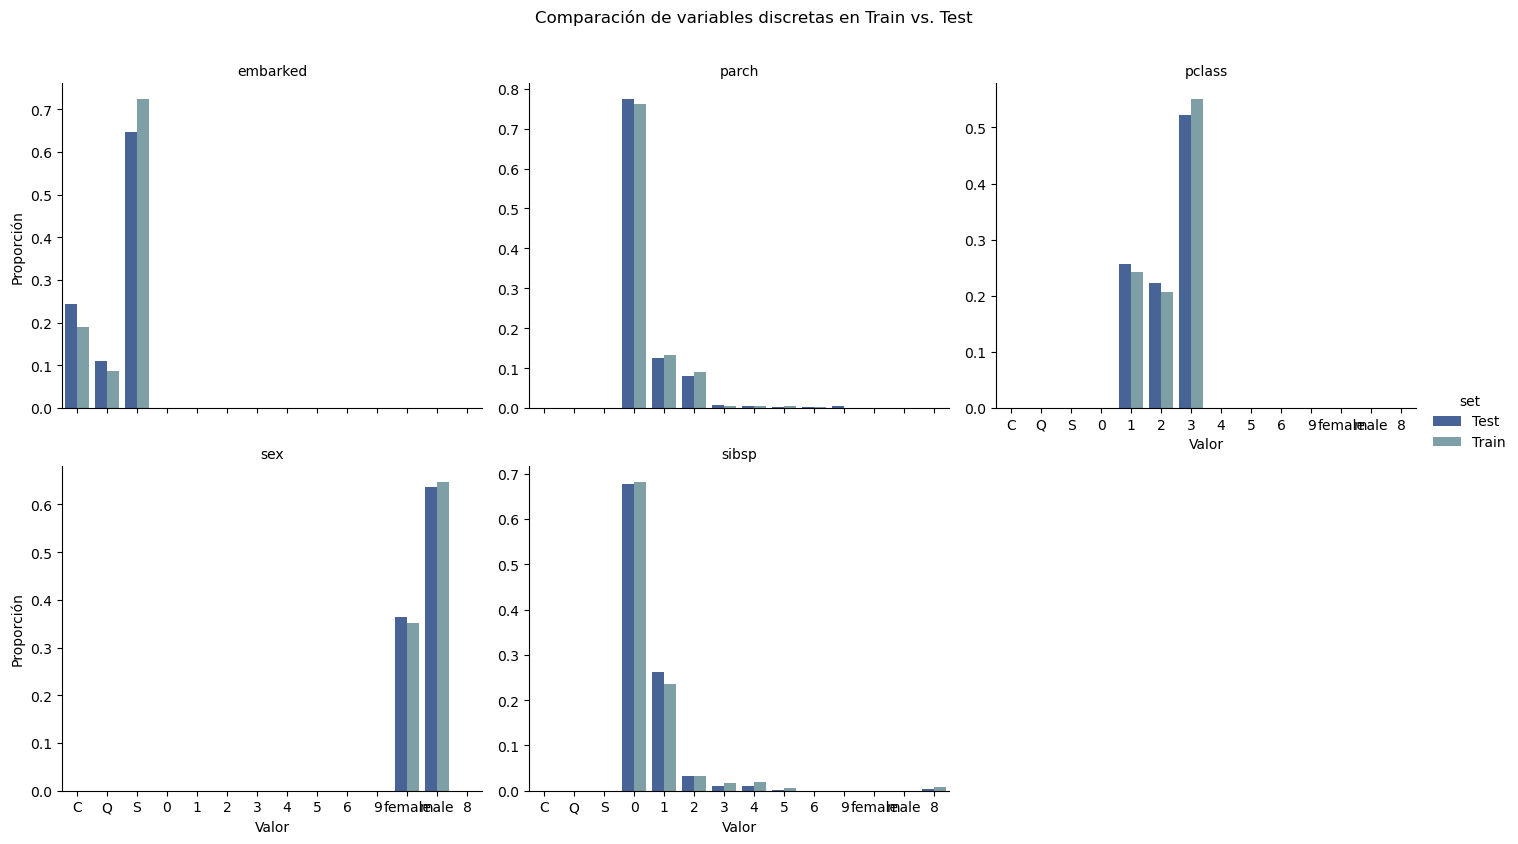

In [19]:
# Comparación (variables discretas)
vars_discretas = ['pclass', 'sibsp', 'parch', 'sex', 'embarked']
compare_discrete_variables(combined_df, vars_discretas)

**Caracteristicas Continuas**

In [20]:
# Comparación Distribuciones Continuas
def compare_train_test_distributions(combined_df, feature_list):
    """
    Grafica las distribuciones de las variables(numéricas) especificadas en feature_list
    tanto en el set de entrenamiento como en el set de prueba.
    
    Parámetros:
    -----------
    combined_df : DataFrame
        DataFrame combinado que contiene los datos de entrenamiento y prueba, con una columna 'Set' que indica el origen.
    feature_list : list
        Lista de nombres de columnas numéricas a comparar.
    """
    num_features = len(feature_list)
    fig, axes = plt.subplots(1, num_features, figsize=(6 * num_features, 5))

    if num_features == 1:
        axes = [axes]

    for i, feat in enumerate(feature_list):
        # Filtrar los datos de entrenamiento y prueba usando la columna 'Set'
        sns.kdeplot(data=train_df, x=feat, fill=True, color='#273176', label='Train', ax=axes[i])
        sns.kdeplot(data=test_df, x=feat, fill=True, color='#76A4AC', label='Test', ax=axes[i])
        axes[i].set_title(f'Distribución de {feat}: Train vs. Test', fontsize=14)
        axes[i].legend()

    plt.tight_layout()
    plt.show()

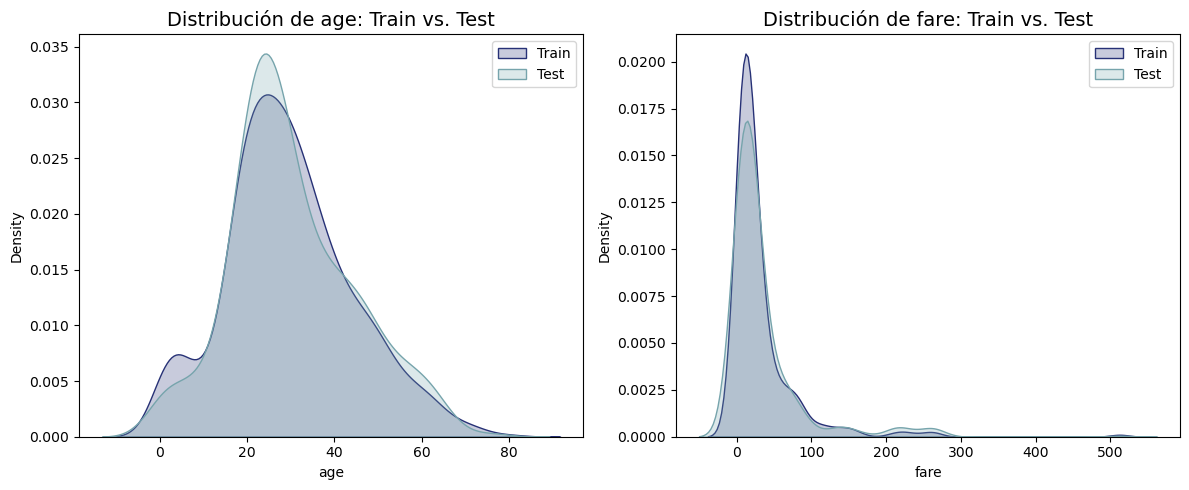

In [21]:
# Comparación de Age y Fare
compare_train_test_distributions(combined_df, feature_list=['age', 'fare'])  

**Valores Faltantes**

**Recuento**
- **Train**: `Age`, `Cabin` y `Embarked`.
- **Test**: `Age`, `Cabin` y `Fare`.

In [22]:
# Mostrar valores faltantes
def display_missing(df, set_name):
    """
    Muestra el número de valores faltantes (en absoluto y en porcentaje)
    en cada columna de un DataFrame.

    Parámetros:
    -----------
    df : DataFrame
        El DataFrame a analizar.
    set_name : str
        Nombre del conjunto de datos (por ejemplo, 'Train' o 'Test').
    """
    total_rows = df.shape[0]
    missing_values = df.isnull().sum()
    missing_pct = ((missing_values / total_rows) * 100).round(2)
    
    missing_summary = pd.DataFrame({
        "Valores Faltantes": missing_values,
        "Porcentaje (%)": missing_pct
    })
    missing_summary = missing_summary[missing_summary["Valores Faltantes"] > 0]
    
    print(f"\nValores faltantes en el conjunto: {set_name}")
    if missing_summary.empty:
        print("No hay valores faltantes en este conjunto.\n")
    else:
        display(missing_summary.sort_values("Porcentaje (%)", ascending=False))

    
    # Graficar valores faltantes usando missingno
    plt.figure(figsize=(30, 2))
    msno.bar(df, figsize=(30,2), color=palette_1)  # Cambiar color según preferencia 
    plt.title(f"Valores Faltantes: {set_name}")
    plt.show()


Valores faltantes en el conjunto: Train


Valores Faltantes  Porcentaje (%)
cabin                   687           77.10
age                     177           19.87
embarked                  2            0.22

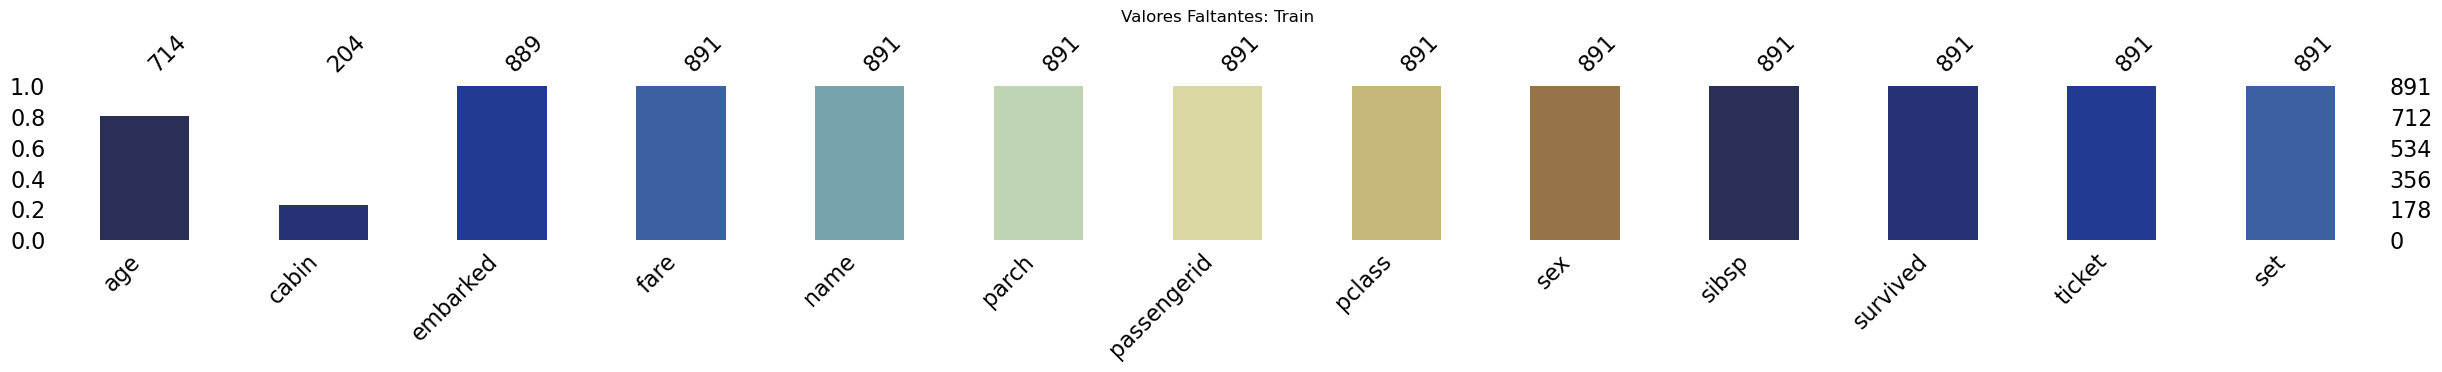


Valores faltantes en el conjunto: Test


Valores Faltantes  Porcentaje (%)
survived                418          100.00
cabin                   327           78.23
age                      86           20.57
fare                      1            0.24

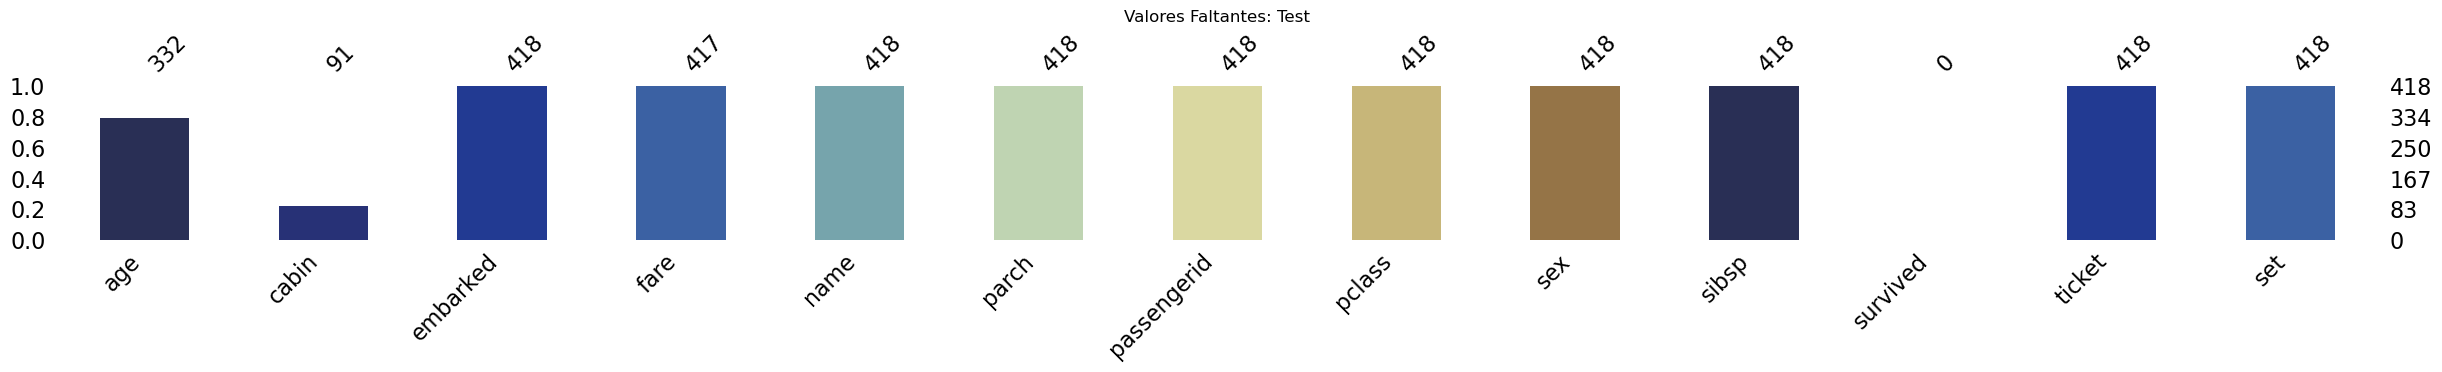

In [23]:
# Valores faltantes Train y Test
for set_name in ["Train", "Test"]:
    df = combined_df[combined_df["set"] == set_name]  # Filtrar por conjunto de datos
    display_missing(df, set_name)


In [24]:
# Copia de respaldo del DataFrame (pre-imputación)
combined_df_original=combined_df.copy()

**Imputación**

**Edad**

`Age` es una variable numérica y continua, consideramos tres enfoques para completar los valores nulos:


| Método | Ventaja | Desventaja | 
|------------------------|-----------------------|----------------------|
|**Método 1** (Aleatorio)| Introduce variabilidad en los datos, útil si la distribución de `Age` es importante.| Puede agregar ruido aleatorio no representativo.|
| **Método 2** (Mediana por `Pclass` y `Sex`)| Preciso, no introduce ruido y refleja patrones reales en los datos.| Puede no capturar la variabilidad natural de `Age`.|
| **Método 3** (Aleatorio dentro de `Pclass` y `Sex`)| Captura la variabilidad real de `Age` manteniendo correlaciones.| Puede afectar la reproducibilidad del modelo.|



El **Método 2**  es más preciso, estable y evita la introducción de ruido aleatorio.

In [25]:
# Filtrado columnas numéricas
df_numeric = combined_df.select_dtypes(include=[float, int])

# Matriz de correlación
combined_df_corr = df_numeric.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()

# Renombrar columnas
combined_df_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: "Correlation Coefficient"}, inplace=True)

# Correlaciones con 'Age'
display(combined_df_corr[combined_df_corr['Feature 1'] == 'age'])

Feature 1    Feature 2  Correlation Coefficient
0        age          age                 1.000000
9        age       pclass                 0.408106
18       age        sibsp                 0.243699
21       age         fare                 0.178740
26       age        parch                 0.150917
30       age     survived                 0.077221
41       age  passengerid                 0.028814

In [26]:
# Correlación pclass y survived
corr_pclass_survived = combined_df[['pclass', 'survived']].corr().iloc[0,1]
print(f'Correlación entre Pclass y Survived: {corr_pclass_survived:.6f}')

Correlación entre Pclass y Survived: -0.338481


Para imputar los valores faltantes en `Age`, se calcula la mediana de edad dentro de cada combinación de `Sex` y `Pclass`

In [27]:
# Mediana age por pclass-sex
age_medians = combined_df.groupby(['pclass', 'sex'])['age'].median().reset_index()

# Medianas calculadas
display(age_medians)
print('Median Age of all passengers: {}'.format(combined_df['age'].median()))

pclass     sex   age
0       1  female  36.0
1       1    male  42.0
2       2  female  28.0
3       2    male  29.5
4       3  female  22.0
5       3    male  25.0

Median Age of all passengers: 28.0


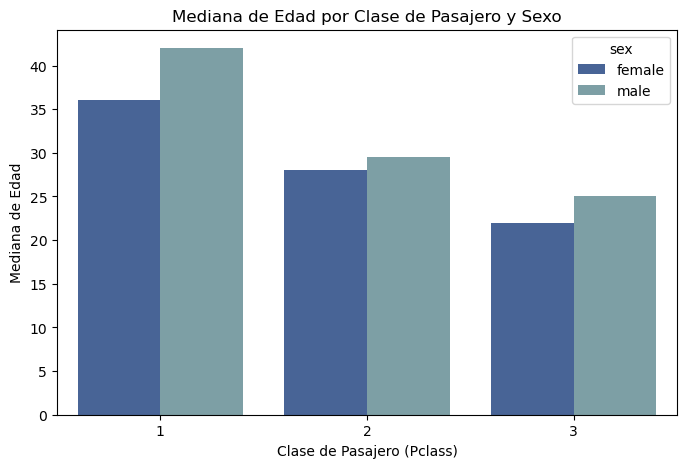

In [28]:
# Gráfico mediana age por pclass-sex
plt.figure(figsize=(8,5))
sns.barplot(data=age_medians, x="pclass", y="age", hue="sex", palette=palette_2)
plt.title("Mediana de Edad por Clase de Pasajero y Sexo")
plt.xlabel("Clase de Pasajero (Pclass)")
plt.ylabel("Mediana de Edad")
plt.show()


In [29]:
# Imputación age, mediana por pclass-sex
combined_df['age'] = combined_df.groupby(['sex', 'pclass'])['age'].transform(lambda x: x.fillna(x.median()))

**Embarked**

Característica categórica con tres posibles valores:

C → Cherbourg  
Q → Queenstown  
S → Southampton 

In [30]:
# Valores faltantes embarked
display(combined_df[combined_df['embarked'].isnull()])

age cabin embarked  fare                                       name  \
61   38.0   B28      NaN  80.0                        Icard, Miss. Amelie   
829  62.0   B28      NaN  80.0  Stone, Mrs. George Nelson (Martha Evelyn)   

     parch  passengerid  pclass     sex  sibsp  survived  ticket    set  
61       0           62       1  female      0       1.0  113572  Train  
829      0          830       1  female      0       1.0  113572  Train

In [31]:
# Moda embarked por sex-plclas
mode_Embarked=combined_df.groupby(['pclass', 'sex'])['embarked'].apply(lambda x: x.mode().iloc[0]).loc[(1, 'female')]
print(f'Moda de `Embarked` para cada combinación de `Sex` y `Pclass`: {mode_Embarked}')

Moda de `Embarked` para cada combinación de `Sex` y `Pclass`: C


**Evidencia histórica:**

- "Martha Evelyn Stone y su doncella, Amelie Icard, embarcaron en Southampton (S) el 10 de abril de 1912. Ambas viajaban en primera clase y ocupaban la cabina B-28."

In [32]:
# Imputar embarked con 'S'
combined_df['embarked'] = combined_df['embarked'].fillna('S')

**Fare**

Imputar `Fare` con la mediana de la tarifa pagada por pasajeros que comparten las mismas características:

- Clase de pasajero (Pclass=3)
- Sin familiares a bordo (Parch=0, SibSp=0)

In [33]:
# Valores faltantes fare
display(combined_df[combined_df['fare'].isnull()])

age cabin embarked  fare                name  parch  passengerid  \
1043  60.5   NaN        S   NaN  Storey, Mr. Thomas      0         1044   

      pclass   sex  sibsp  survived ticket   set  
1043       3  male      0       NaN   3701  Test

In [34]:
# Mediana fare por pasajeros de tercera clase sin familia
filtered_data = combined_df.groupby(['pclass', 'parch', 'sibsp'])['fare'].get_group((3, 0, 0))
med_fare = filtered_data.median()
print(f'Mediana de Fare para pasajeros de tercera clase sin familia: {med_fare}')

# Imputar fare con mediana 
combined_df['fare'] = combined_df['fare'].fillna(med_fare)

Mediana de Fare para pasajeros de tercera clase sin familia: 7.8542


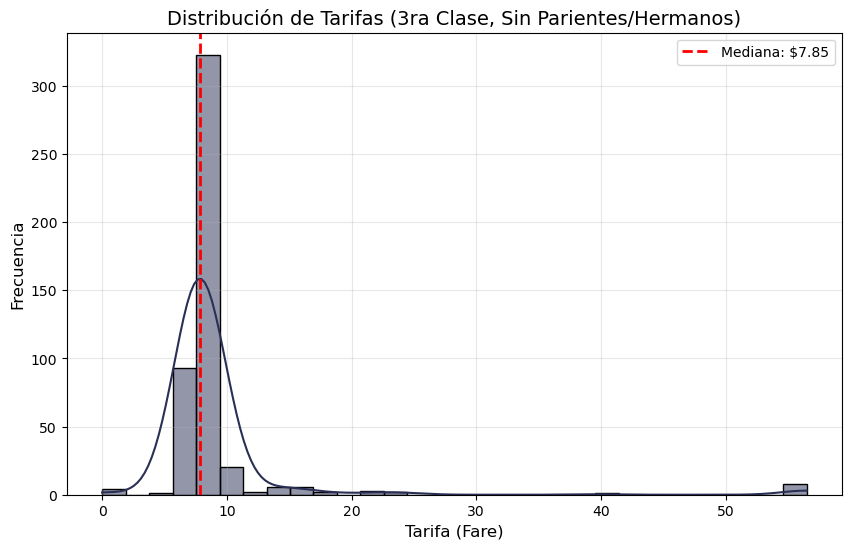

In [35]:
# Histograma
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data, bins=30, kde=True, color="#292F55")

# Línea mediana
plt.axvline(med_fare, color='red', linestyle='--', linewidth=2, 
           label=f'Mediana: ${med_fare:.2f}')

plt.title('Distribución de Tarifas (3ra Clase, Sin Parientes/Hermanos)', fontsize=14)
plt.xlabel('Tarifa (Fare)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

**Cabin**

No se imputara `Cabin`, en su lugar se extraera la primera letra de los valores disponibles para crear una nueva variable categórica llamada `Deck`.

- La primera letra de `Cabin` indica la cubierta (`Deck`) en la que se encontraba la cabina.
- Los valores faltantes se asignarán como **M** (Missing) para diferenciar pasajeros sin información de cabina y sin introducir sesgos arbritrarios.

In [36]:
# Columna deck, primera letra de la columna cabin
combined_df['deck'] = combined_df['cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

| **Cubierta (`Deck`)** | **Distribución de Clases (`Pclass`)** |
|-----------------|--------------------------------|
| **A, B, C**    | 100% Primera Clase |
| **D**          | 87% Primera Clase, 13% Segunda Clase |
| **E**          | 83% Primera Clase, 10% Segunda Clase, 7% Tercera Clase |
| **F**          | 62% Segunda Clase, 38% Tercera Clase |
| **G**          | 100% Tercera Clase |
| **T**          | Solo un pasajero (Primera Clase) |

In [37]:
# Pasajeros por deck-pclass 
combined_df_decks = combined_df.groupby(['deck', 'pclass']).count().drop(columns=['survived', 'sex', 'age', 'sibsp', 'parch','fare', 'embarked', 'cabin', 'passengerid', 'ticket']).rename(columns={'Name': 'Count'}).transpose()

In [38]:
# Distribución pclass-deck
def get_pclass_dist(df):
    """
    Calcula la distribución de clases de pasajeros (pclass) por cubierta (deck).
    
    Parámetros:
    -----------
    df : DataFrame
        DataFrame que contiene la información de las cubiertas y clases de pasajeros.
    
    Retorna:
    --------
    deck_counts : dict
        Diccionario con el conteo de pasajeros por cubierta y clase.
    deck_percentages : dict
        Diccionario con el porcentaje de pasajeros por cubierta y clase.
    """
    # Inicializar un diccionario para almacenar los conteos
    deck_counts = {deck: {pclass: 0 for pclass in range(1, 4)} for deck in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T']}
    
    # Calcular los conteos por cubierta y clase
    for deck in deck_counts:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count
            except KeyError:
                deck_counts[deck][pclass] = 0
    
    # Convertir a DataFrame para facilitar cálculos
    df_decks = pd.DataFrame(deck_counts)
    
    # Calcular los porcentajes
    deck_percentages = {deck: [(count / df_decks[deck].sum()) * 100 for count in df_decks[deck]] for deck in df_decks.columns}
    
    return deck_counts, deck_percentages

# Gráfico pclass-deck
def display_pclass_dist(percentages):
    """
    Muestra un gráfico de barras apiladas con la distribución de clases por cubierta.
    
    Parámetros:
    -----------
    percentages : dict
        Diccionario con los porcentajes de pasajeros por cubierta y clase.
    """
    # Convertir a DataFrame y transponer
    df_percentages = pd.DataFrame(percentages).transpose()
    
    # Nombres de las cubiertas
    deck_names = df_percentages.index
    
    # Posiciones de las barras
    bar_count = np.arange(len(deck_names))
    bar_width = 0.85
    
    # Porcentajes para cada clase
    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]
    
    # Crear el gráfico de barras apiladas
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='#223A92', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#BFD4B2', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')
    
    # Ajustar etiquetas y título
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    # Añadir leyenda
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)
    
    # Mostrar el gráfico
    plt.show()

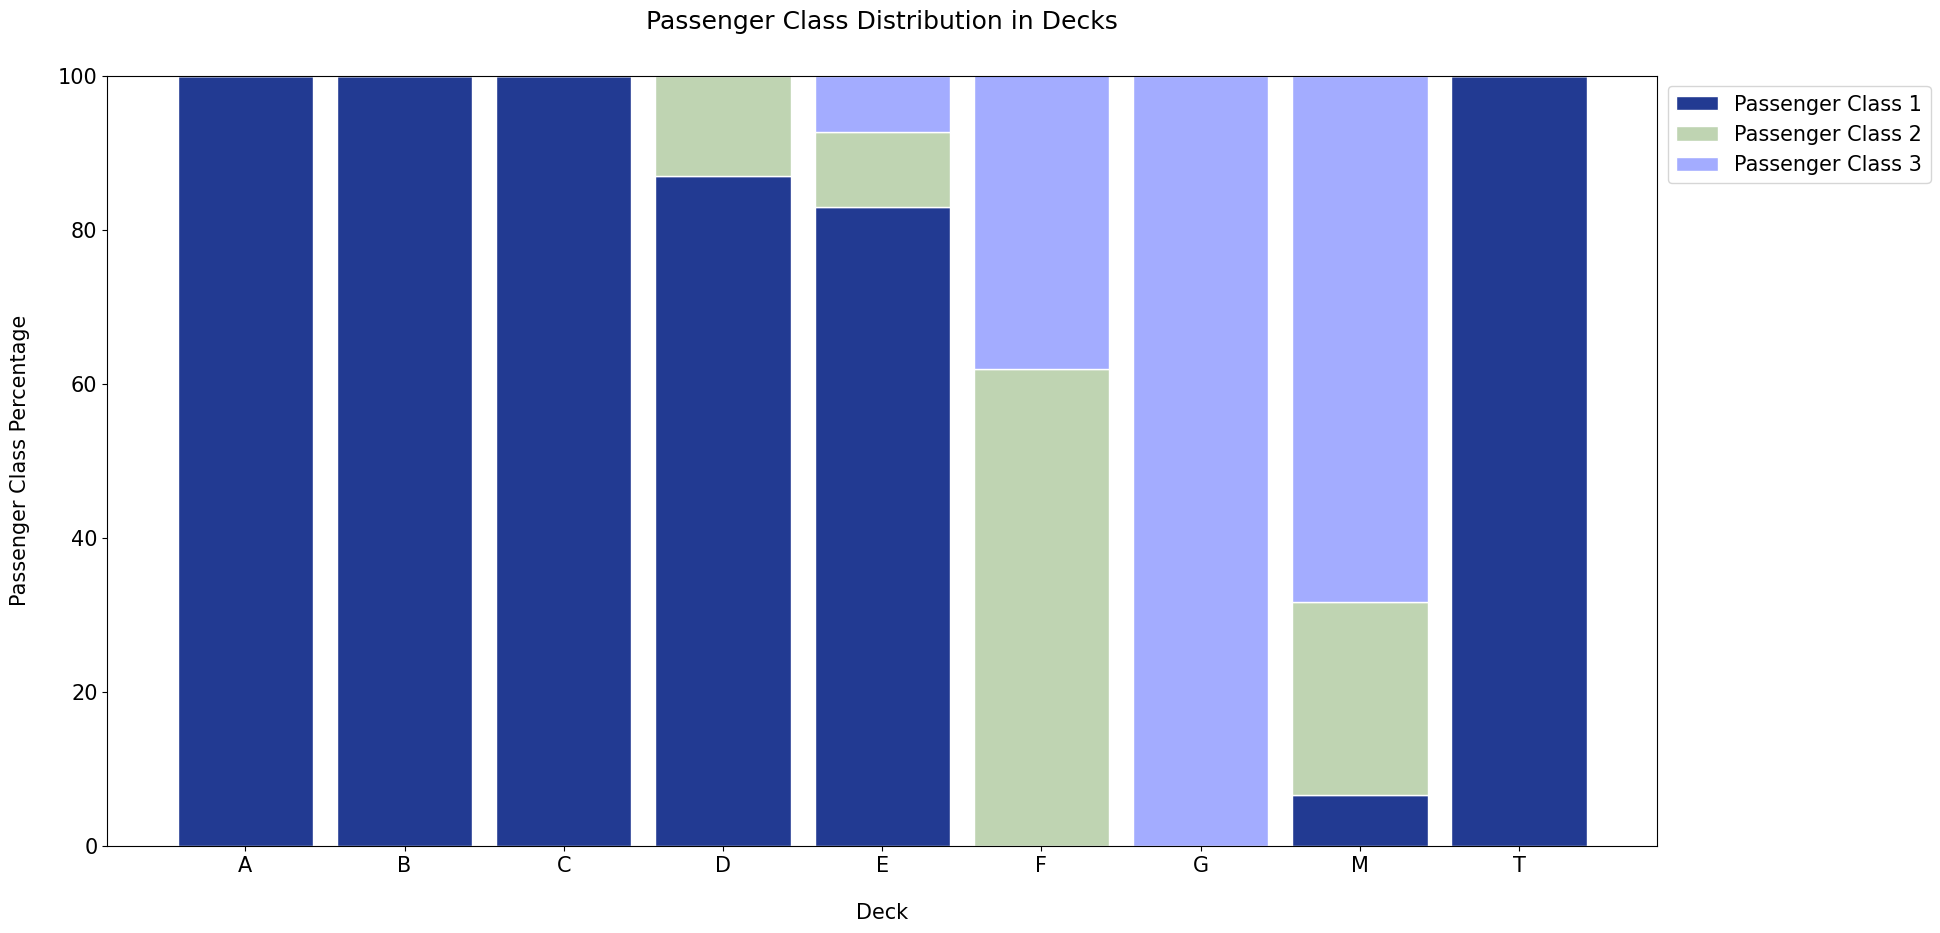

In [39]:
# Distribución pclass-deck
all_deck_count, all_deck_per = get_pclass_dist(combined_df_decks)
display_pclass_dist(all_deck_per)

In [40]:
# Cambiar cubierta T con A
idx = combined_df[combined_df['deck'] == 'T'].index
combined_df.loc[idx, 'deck'] = 'A'

In [41]:
# Cubiertas
combined_df['deck'].unique()

array(['M', 'C', 'E', 'G', 'D', 'A', 'B', 'F'], dtype=object)

Analizar la **tasa de supervivencia** por cubierta nos permite evaluar si la ubicación de la cabina influyó en la probabilidad de sobrevivir al desastre del Titanic.

- Cubiertas **B**, **C**, **D** y **E** presentan las tasas de supervivencia más altas. Estas cubiertas estaban ocupadas principalmente por pasajeros de primera clase, quienes tenían mejor acceso a los botes salvavidas.
- Cubierta **M** muestra la tasa de supervivencia más baja, ya que estaba ocupada mayormente por pasajeros de segunda y tercera clase. Además, muchos de los valores faltantes en `Cabin` fueron asignados a esta cubierta, lo que podría indicar que muchos de estos pasajeros estaban entre las víctimas y no se pudo recuperar su información de cabina.

Para facilitar la exploración de la supervivencia por cubierta, definimos dos funciones:

- get_survived_dict(): Calcula el número de pasajeros sobrevivientes y no sobrevivientes en cada cubierta.
- display_surv_dist(): Genera un gráfico de barras que visualiza la tasa de supervivencia por cubierta (Deck).

In [42]:
# Supervivencia por deck
combined_df_decks_survived = combined_df.groupby(['deck', 'survived']).count().drop(columns=['sex', 'age', 'sibsp', 'parch', 'fare','embarked', 'pclass', 'cabin', 'passengerid', 'ticket']).rename(columns={'Name':'Count'}).transpose()

In [43]:
# Proproción supervivencia por deck
def get_survived_dict(df):
    surv_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}}
    decks = df.columns.levels[0]    
    
    for deck in decks:
        for survive in range(0, 2):
            try:
                count = df[deck][survive][0]
                surv_counts[deck][survive] = count 
            except KeyError:
                surv_counts[deck][survive] = 0
                
    df_surv = pd.DataFrame(surv_counts)    
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]
        
    return surv_counts, surv_percentages

# Tasa de supervivencia por deck
def display_surv_dist(percentages):
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85
    
    not_survived = df_percentages[0]
    survived = df_percentages[1]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived, color='#223A92', edgecolor='white', width=bar_width, label='Not Survived')
    plt.bar(bar_count, survived, bottom=not_survived, color='#BFD4B2', edgecolor='white', width=bar_width, label='Survived')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage in Decks', size=18, y=1.05)   
    
    plt.show()

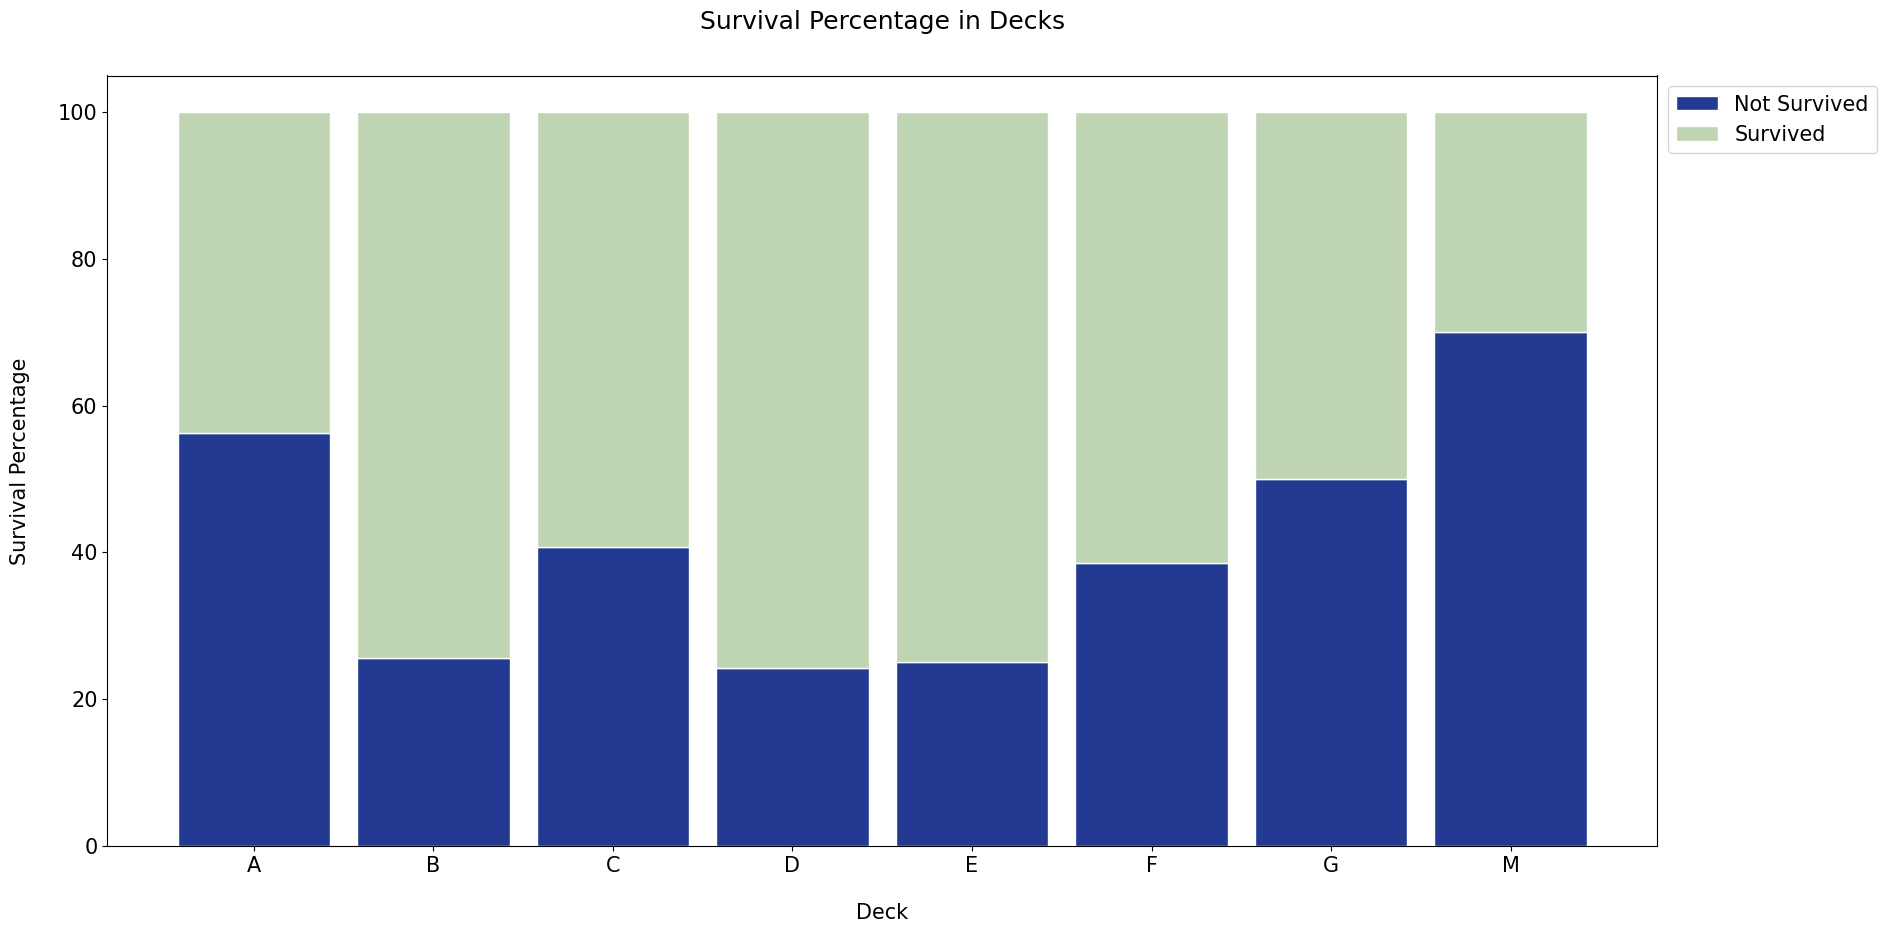

In [44]:
# Supervivencia por cubierta
all_surv_count, all_surv_per = get_survived_dict(combined_df_decks_survived)
display_surv_dist(all_surv_per)

| **Grupo** | **Cubiertas Incluidas** | **Motivo de la Agrupación** |
|-----------|-------------------------|-----------------------------|
| **ABC**   | A, B, C                 | Contienen exclusivamente pasajeros de primera clase. |
| **DE**    | D, E                     | Similar distribución de clases y tasas de supervivencia. |
| **FG**    | F, G                     | Se agrupan por características similares. |
| **M**     | M                         | Se mantiene separada por su diferencia en supervivencia y la cantidad de valores faltantes en `Cabin`. |


In [45]:
# Nuevas categorías deck
deck_mapping = {'A': 'ABC', 'B': 'ABC', 'C': 'ABC',
                'D': 'DE', 'E': 'DE',
                'F': 'FG', 'G': 'FG'}

# Agrupación en train y test
combined_df['deck'] = combined_df['deck'].replace(deck_mapping)
print(combined_df['deck'].value_counts())

deck
M      1014
ABC     182
DE       87
FG       26
Name: count, dtype: int64




**Resumen**


| **Variable**  | **Estrategia de Imputación** | **Justificación** |
|--------------|----------------------------|-------------------|
| **Age**     | Imputación con la **mediana** basada en `Pclass` y `Sex`. | Permite reflejar diferencias en la distribución de edades según la clase social y género. |
| **Embarked** | Imputación con **`S` (Southampton)**. | Basado en evidencia histórica sobre los pasajeros con valores faltantes. |
| **Fare**     | Imputación con la **mediana** de `Fare` para pasajeros de tercera clase sin familia (`Pclass=3`, `Parch=0`, `SibSp=0`). | Refleja el costo típico para pasajeros con características similares. |
| **Deck**     | Creación de la variable `Deck` a partir de la primera letra de `Cabin`. Los valores faltantes se etiquetan como **`M` (Missing)**. | Mantiene la información útil de `Cabin` y diferencia a los pasajeros sin información de cabina. |
| **Cabin**  | Eliminación de la columna `Cabin` | La nueva variable `Deck` conserva la información relevante de `Cabin`




**Verificación de Valores Faltantes**


Valores faltantes en el conjunto: Train
No hay valores faltantes en este conjunto.




Valores faltantes en el conjunto: Test


Valores Faltantes  Porcentaje (%)
survived                418           100.0

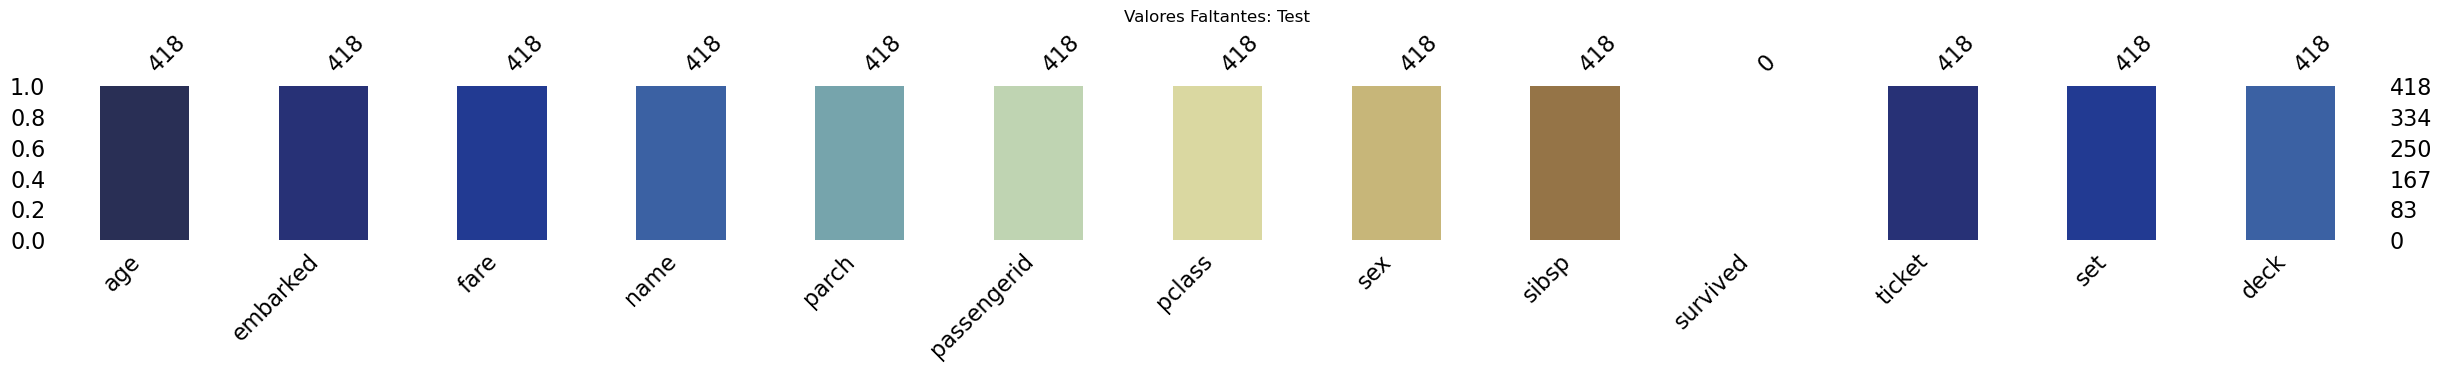

In [46]:
# Valores faltantes train/test
for set_name in ['Train', 'Test']:
    df = combined_df[combined_df['set'] == set_name].drop('cabin', axis=1)
    display_missing(df, set_name)

**Evaluación de la imputación** 

In [47]:
# Distribución antes/despues de imputacion (variables categoricas)
def compare_distributions_before_after_imputation(df_before, df_after, discrete_vars, label_before="Antes de la Imputación", label_after="Después de la Imputación"):
    """
    Compara la distribución de variables discretas antes y después de la imputación.
    
    Parámetros:
    -----------
    df_before : DataFrame
        DataFrame original (antes de la imputación).
    df_after : DataFrame
        DataFrame con valores imputados.
    discrete_vars : list
        Lista de nombres de columnas categóricas/discretas a comparar.
    label_before : str
        Etiqueta para el DataFrame antes de la imputación en la leyenda.
    label_after : str
        Etiqueta para el DataFrame después de la imputación en la leyenda.
    """
    
    # DataFrame combinando 
    df_before["dataset"] = label_before
    df_after["dataset"] = label_after
    combined = pd.concat([df_before, df_after])

    # Graficos
    g = sns.catplot(
        data=combined.melt(id_vars=["dataset"], value_vars=discrete_vars),
        x="value",
        hue="dataset",
        col="variable",
        kind="count",
        palette=palette,
        height=4,
        aspect=1.2,
        sharey=False
    )

    g.set_titles("{col_name}")
    g.set_xlabels("Valor")
    g.set_ylabels("Frecuencia")
    g.fig.suptitle("Comparación de Variables Discretas Antes y Después de la Imputación", y=1.05)
    
    plt.show()

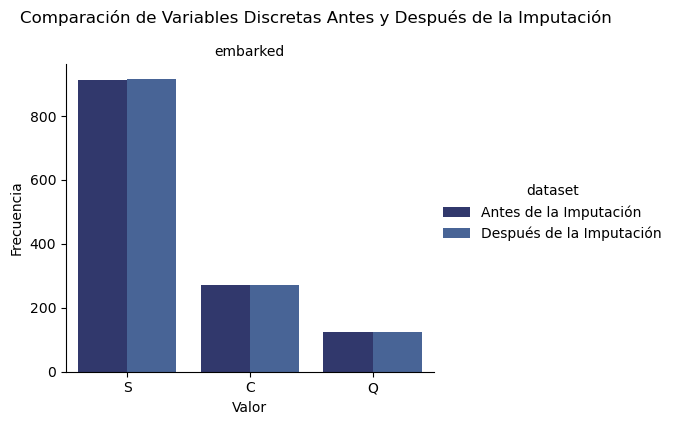

In [48]:
# Variables discretas a analizar
discrete_vars = ['embarked']

# Distribución antes y después (imputación)
compare_distributions_before_after_imputation(combined_df_original, combined_df, discrete_vars)

In [49]:
# Distribución antes/despues de imputacion (variables numéricas)
def compare_continuous_distributions_before_after_imputation(df_before, df_after, continuous_vars, label_before="Antes de la Imputación", label_after="Después de la Imputación"):
    """
    Compara la distribución de variables continuas antes y después de la imputación.
    
    Parámetros:
    -----------
    df_before : DataFrame
        DataFrame original (antes de la imputación).
    df_after : DataFrame
        DataFrame con valores imputados.
    continuous_vars : list
        Lista de nombres de columnas numéricas a comparar.
    label_before : str
        Etiqueta para el DataFrame antes de la imputación en la leyenda.
    label_after : str
        Etiqueta para el DataFrame después de la imputación en la leyenda.
    """
    
    fig, axes = plt.subplots(1, len(continuous_vars), figsize=(5 * len(continuous_vars), 4))
    
    if len(continuous_vars) == 1:
        axes = [axes]

    for ax, var in zip(axes, continuous_vars):
        sns.kdeplot(df_before[var].dropna(), ax=ax, label=label_before, color='#273176', fill=True, alpha=0.4)
        sns.kdeplot(df_after[var].dropna(), ax=ax, label=label_after, color='#76A4AC', fill=True, alpha=0.4)
        ax.set_title(f"Distribución de {var}")
        ax.set_xlabel(var)
        ax.set_ylabel("Densidad")
        ax.legend()
    
    fig.suptitle("Comparación de Variables Continuas Antes y Después de la Imputación", fontsize=14)
    plt.tight_layout()
    plt.show()

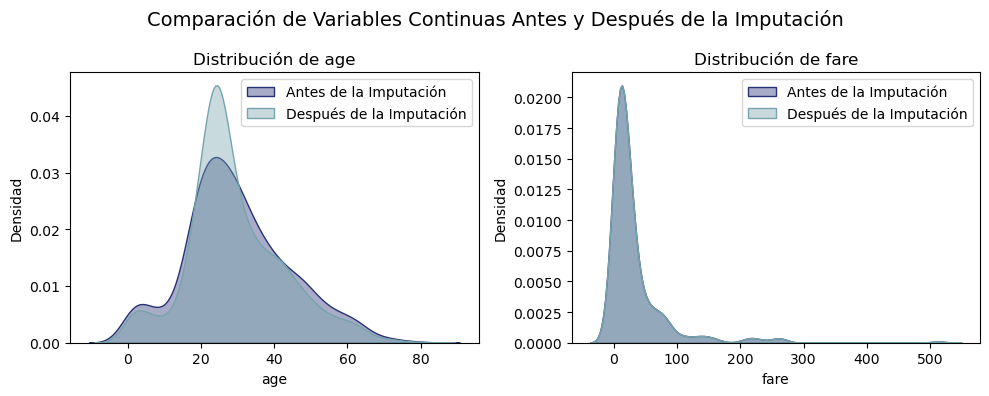

In [50]:
# Variables continuas a analizar
continuous_vars = ['age', 'fare']

# Distribución antes y después de imputación
compare_continuous_distributions_before_after_imputation(combined_df_original.copy(), combined_df.copy(), continuous_vars)

In [51]:
# Estadísticas antes y después de imputación (variacles numéricas)
stats_before = combined_df_original[continuous_vars].describe()
stats_after = combined_df[continuous_vars].describe()

# Concatenar resultados 
stats_comparison = pd.concat(
    [stats_before, stats_after], 
    axis=1, 
    keys=["Antes de la Imputación", "Después de la Imputación"]
)

stats_comparison = stats_comparison.round(2)  # Redondear a 2 decimales

# Tabla comparativa 
print("Comparación de Estadísticas Antes y Después de la Imputación:")
display(stats_comparison)

Comparación de Estadísticas Antes y Después de la Imputación:


Antes de la Imputación          Después de la Imputación         
                         age     fare                      age     fare
count                1046.00  1308.00                  1309.00  1309.00
mean                   29.88    33.30                    29.26    33.28
std                    14.41    51.76                    13.22    51.74
min                     0.17     0.00                     0.17     0.00
25%                    21.00     7.90                    22.00     7.90
50%                    28.00    14.45                    26.00    14.45
75%                    39.00    31.28                    36.00    31.28
max                    80.00   512.33                    80.00   512.33

**Outliers**

**Detección**

**detect_otuliers_izq** localiza outliers en un DataFrame usando el método del rango intercuartílico (IQR).

- Conjunto de Entrenamiento (Train)
    - Age: 40 valores atípicos detectados.
    - Fare: 116 valores atípicos detectados.
- Conjunto de Prueba (Test)
    - Age: 21 valores atípicos detectados.
    - Fare: 55 valores atípicos detectados.

In [52]:
# IQR-Outliers 
def detect_outliers_iqr(df, columnas):
    """
    Marca outliers en columnas numéricas usando IQR calculado solo a partir del conjunto de entrenamiento.
    Crea nuevas columnas binarias con el sufijo '_outlier' en df.
    
    Parámetros:
    -----------
    df : DataFrame
        DataFrame a emplear'
    columnas : list
        Lista de columnas numéricas a evaluar para detección de outliers
    
    Retorna:
    --------
        df : DataFrame
        Mismo DataFrame con columnas adicionales *_outlier
    """

    train_df = df[df["set"] == "Train"]

    for col in columnas:
        # IQR Train
        q1 = train_df[col].quantile(0.25)
        q3 = train_df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr

        # Marcar outliers 
        df[f"{col}_outlier"] = ((df[col] < lower) | (df[col] > upper)).astype(int)

    # Outliers por variable y conjunto
    print("\n OUTLIERS POR VARIABLE Y CONJUNTO:\n")
    for col in columnas:
        outlier_col = f"{col}_outlier"
        for subset in ["Train", "Test"]:
            count = df[df["set"] == subset][outlier_col].sum()
            print(f"{subset} - {col}_outlier: {count} valores")

    return df


In [53]:
# Outliers DataFrame
combined_df = detect_outliers_iqr(combined_df, columnas=['age', 'fare'])


 OUTLIERS POR VARIABLE Y CONJUNTO:

Train - age_outlier: 40 valores
Test - age_outlier: 21 valores
Train - fare_outlier: 116 valores
Test - fare_outlier: 55 valores


In [54]:
# tasa de supervivencia (outliers/ no outliers)
for col in ['age_outlier', 'fare_outlier']:
    print(f"\n Análisis para: {col} en el conjunto TRAIN")
    
    df_train = combined_df[combined_df['set'] == 'Train']
    
    display(
        df_train.groupby(col)['survived'].agg(
            tasa_supervivencia='mean',
            conteo='count'
        ).rename(index={0: "No Outlier", 1: "Outlier"})
    )


 Análisis para: age_outlier en el conjunto TRAIN


tasa_supervivencia  conteo
age_outlier                            
No Outlier             0.381904     851
Outlier                0.425000      40


 Análisis para: fare_outlier en el conjunto TRAIN


tasa_supervivencia  conteo
fare_outlier                            
No Outlier              0.339355     775
Outlier                 0.681034     116

**Distribución de la Variable Objetivo (Survived)**

- **Sobrevivientes (Class 1)**: 38.38% (342/891) del conjunto de entrenamiento.
- **No Sobrevivientes (Class 0)**: 61.82% (640/891) del conjunto de entrenamiento.
- El conjunto de datos muestra un moderado desbalance con más pasajeros que no sobrevivieron (61%) en comparación con los que sí (38%).
- Si bien la diferencia no es extrema, es importante considerar su impacto en el modelo.

342 of 891 passengers survived (38.38%).
549 of 891 passengers didn't survive (61.62%).


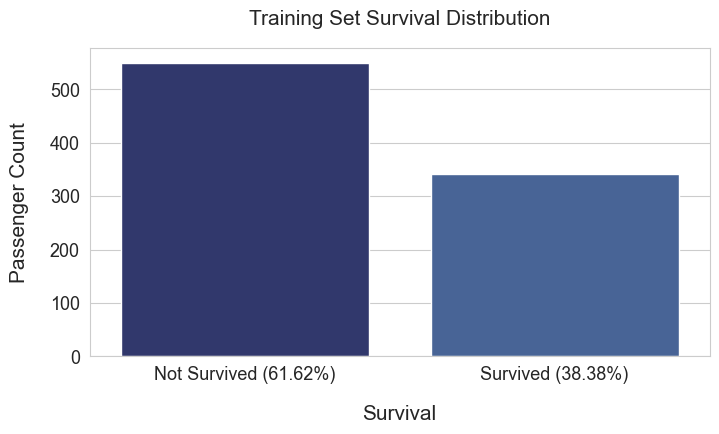

In [55]:
# Sobrevivientes y no sobrevivientes
survival_counts = train_df['survived'].value_counts()
survived, not_survived = survival_counts[1], survival_counts[0]
survived_per, not_survived_per = (survived / train_df.shape[0]) * 100, (not_survived / train_df.shape[0]) * 100
print(f"{survived} of {train_df.shape[0]} passengers survived ({survived_per:.2f}%).")
print(f"{not_survived} of {train_df.shape[0]} passengers didn't survive ({not_survived_per:.2f}%).")

plt.figure(figsize=(8, 4))
sns.set_style("whitegrid")
ax = sns.countplot(x="survived", data=train_df, palette=palette, hue="survived", legend=False)

ax.set_xlabel('Survival', size=15, labelpad=15)
ax.set_ylabel('Passenger Count', size=15, labelpad=15)
ax.set_xticks([0, 1])
ax.set_xticklabels([f"Not Survived ({not_survived_per:.2f}%)", f"Survived ({survived_per:.2f}%)"], size=13)
ax.tick_params(axis='y', labelsize=13)
ax.set_title('Training Set Survival Distribution', size=15, y=1.05)

plt.show()

**Correlaciones**

**Características Numéricas**

Correlación alta:

- Train Set → La correlación más alta es 0.5455 entre `Fare` y `Pclass`.
- Test Set → La correlación más alta es 0.5771 entre las mismas variables.

Correlaciones significativas (> 0.1):

- Train Set → Se identificaron 9 correlaciones con un coeficiente superior a 0.1.
- Test Set → Se encontraron 6 correlaciones por encima de 0.1.

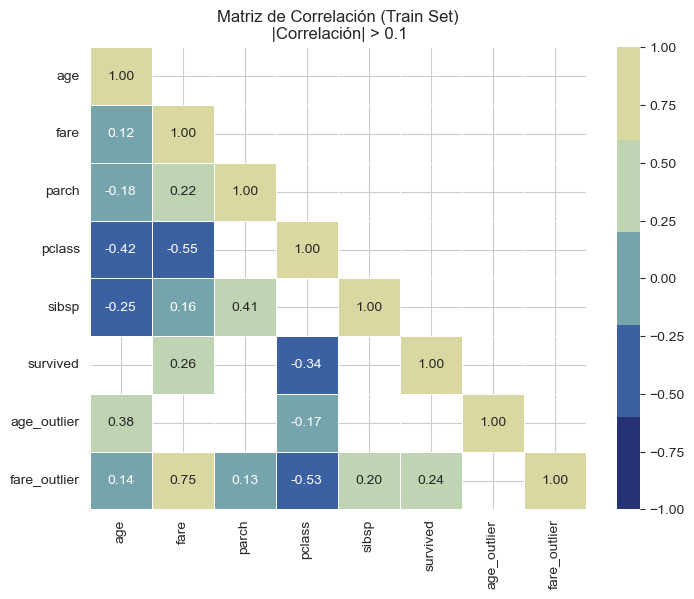

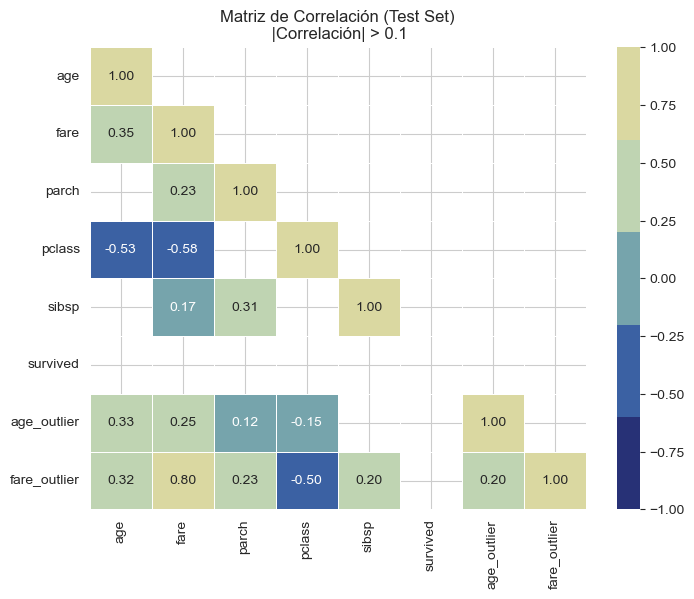

In [56]:
# Umbral correlación
threshold = 0.1  

for set_name in ['Train', 'Test']:
    df = combined_df[combined_df['set'] == set_name]
    df_corr = df.select_dtypes(include=[np.number]).drop(["passengerid"], axis=1, errors='ignore').corr()
    
    # Ocultar mitad SUPERIOR 
    mask_upper = np.triu(np.ones_like(df_corr, dtype=bool), k=1)  # True en la mitad superior
    
    # Correlaciones <= threshold (débiles)
    mask_weak = np.abs(df_corr) <= threshold
    
    # Combinación mascaras: 
    #   - Ocultar la mitad superior (mask_upper) 
    #   - ocultar correlaciones débiles en la mitad inferior (mask_weak)
    mask_final = mask_upper | (np.tril(np.ones_like(df_corr, dtype=bool)) & mask_weak)
    
    # Heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        df_corr,
        annot=True,
        fmt=".2f",
        cmap=palette,
        vmin=-1,
        vmax=1,
        mask=mask_final,  # Aplicar máscara combinada
        linewidths=0.5,
        cbar=True
    )
    plt.title(f'Matriz de Correlación ({set_name} Set)\n |Correlación| > {threshold}')
    plt.show()

**Correlación Bivariada**

**Características Categóricas**

- **Pclass**: Los pasajeros de primera clase tienen una tasa de supervivencia más alta en comparación con los de segunda y tercera clase.
- **Sex**: Las mujeres tienen una tasa de supervivencia significativamente más alta que los hombres.
- **Embarked**: Los pasajeros que embarcaron en Cherbourg tienen una tasa de supervivencia más alta en comparación con los que embarcaron en Southampton.
- **Parch y SibSp**: Los pasajeros con un solo miembro de la familia a bordo tienen una tasa de supervivencia más alta.

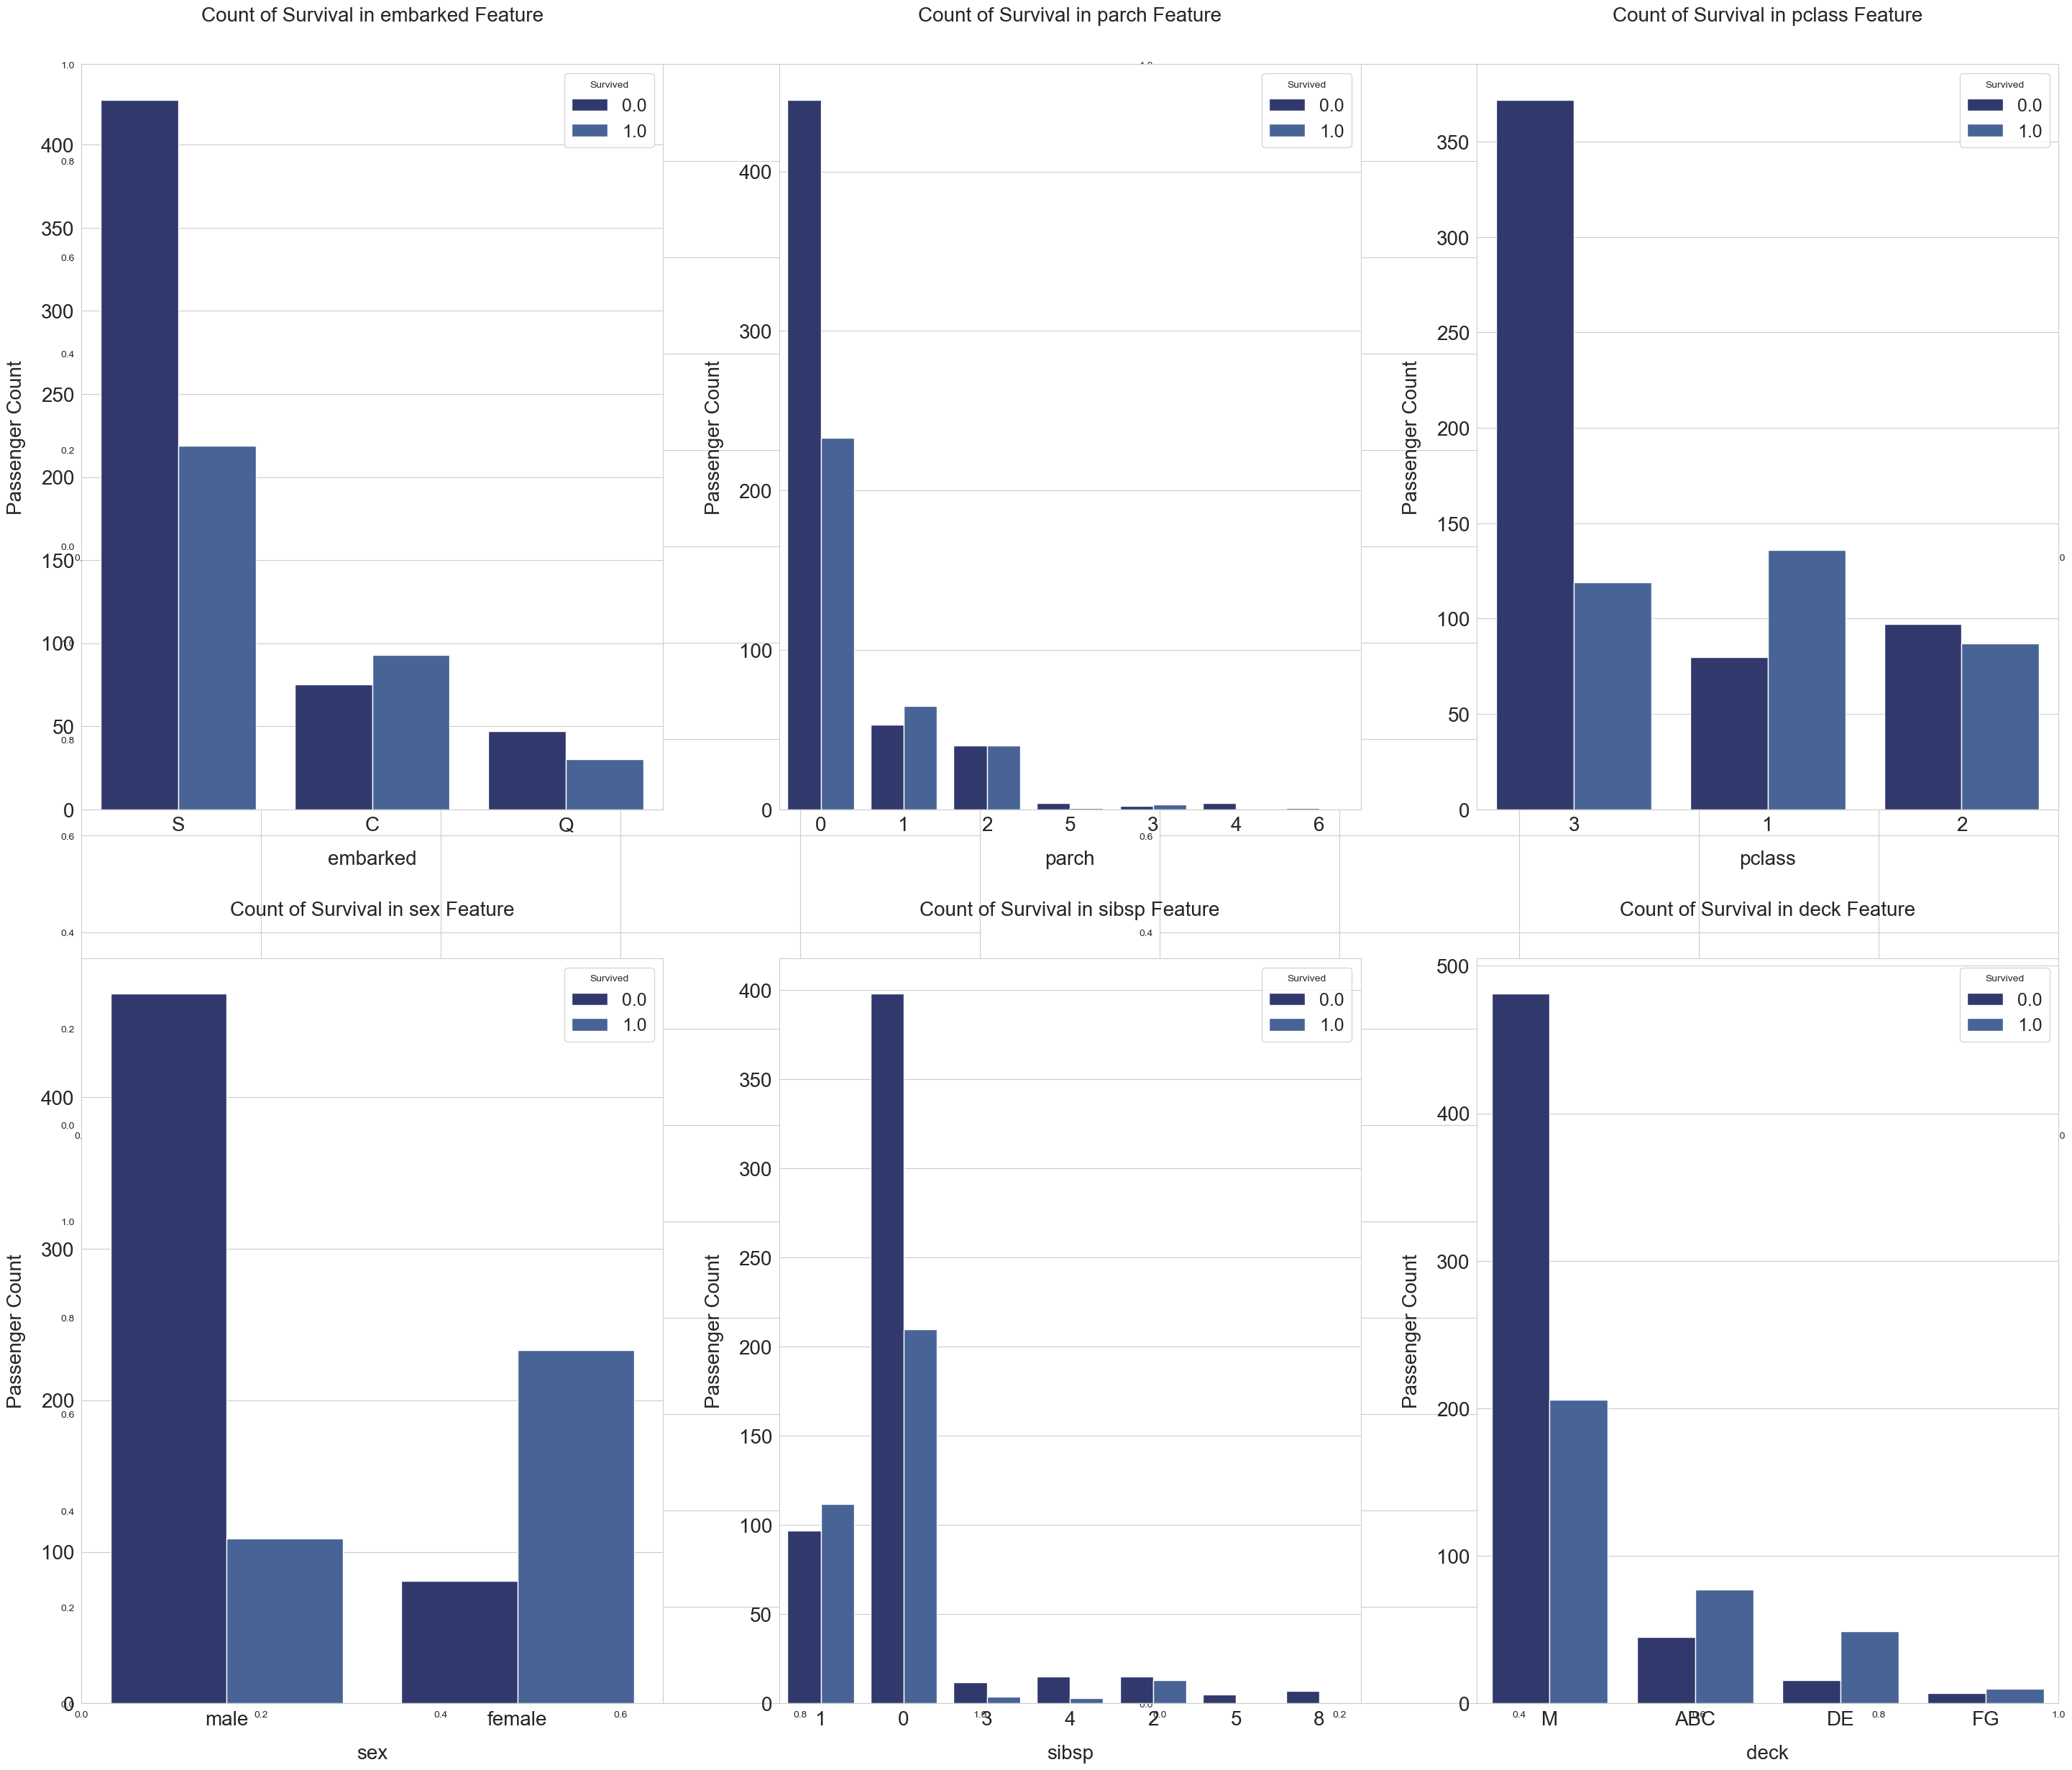

In [57]:
# Características categóricas
cat_features = ['embarked', 'parch', 'pclass', 'sex', 'sibsp', 'deck']

cat_features = [col for col in cat_features if col in combined_df.columns]

df_train = combined_df[combined_df['set'] == 'Train']

df_train.loc[:, 'survived'] = df_train['survived'].astype(str)

df_train.loc[:, cat_features] = df_train[cat_features].astype(str)

# Reemplazar NaN ("Unknown")
df_train.loc[:, cat_features] = df_train[cat_features].fillna("Unknown")

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, hue='survived', data=df_train, palette=palette)

    plt.xlabel(feature, size=20, labelpad=15)
    plt.ylabel('Passenger Count', size=20, labelpad=15)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)

    plt.legend(title="Survived", loc='upper right', prop={'size': 18})
    plt.title(f'Count of Survival in {feature} Feature', size=20, y=1.05)

plt.show()

**Características Continuas**

- **Bebés (edad <= 4)**: Tuvieron una alta tasa de sobrevivencia, lo que podría deberse a la prioridad dada a los niños durante el rescate.
- **Pasajeros de Mayor Edad (edad = 80)**: Aunque son pocos, los pasajeros de mayor edad también tuvieron una tasa de sobrevivencia notable.
- **Pasajeros de 15 a 25 años**: Una gran cantidad de personas en este rango de edad no sobrevivieron.
- **Rango de Edad de 15 a 35 años**: La mayoría de los pasajeros se encuentran en este rango de edad.

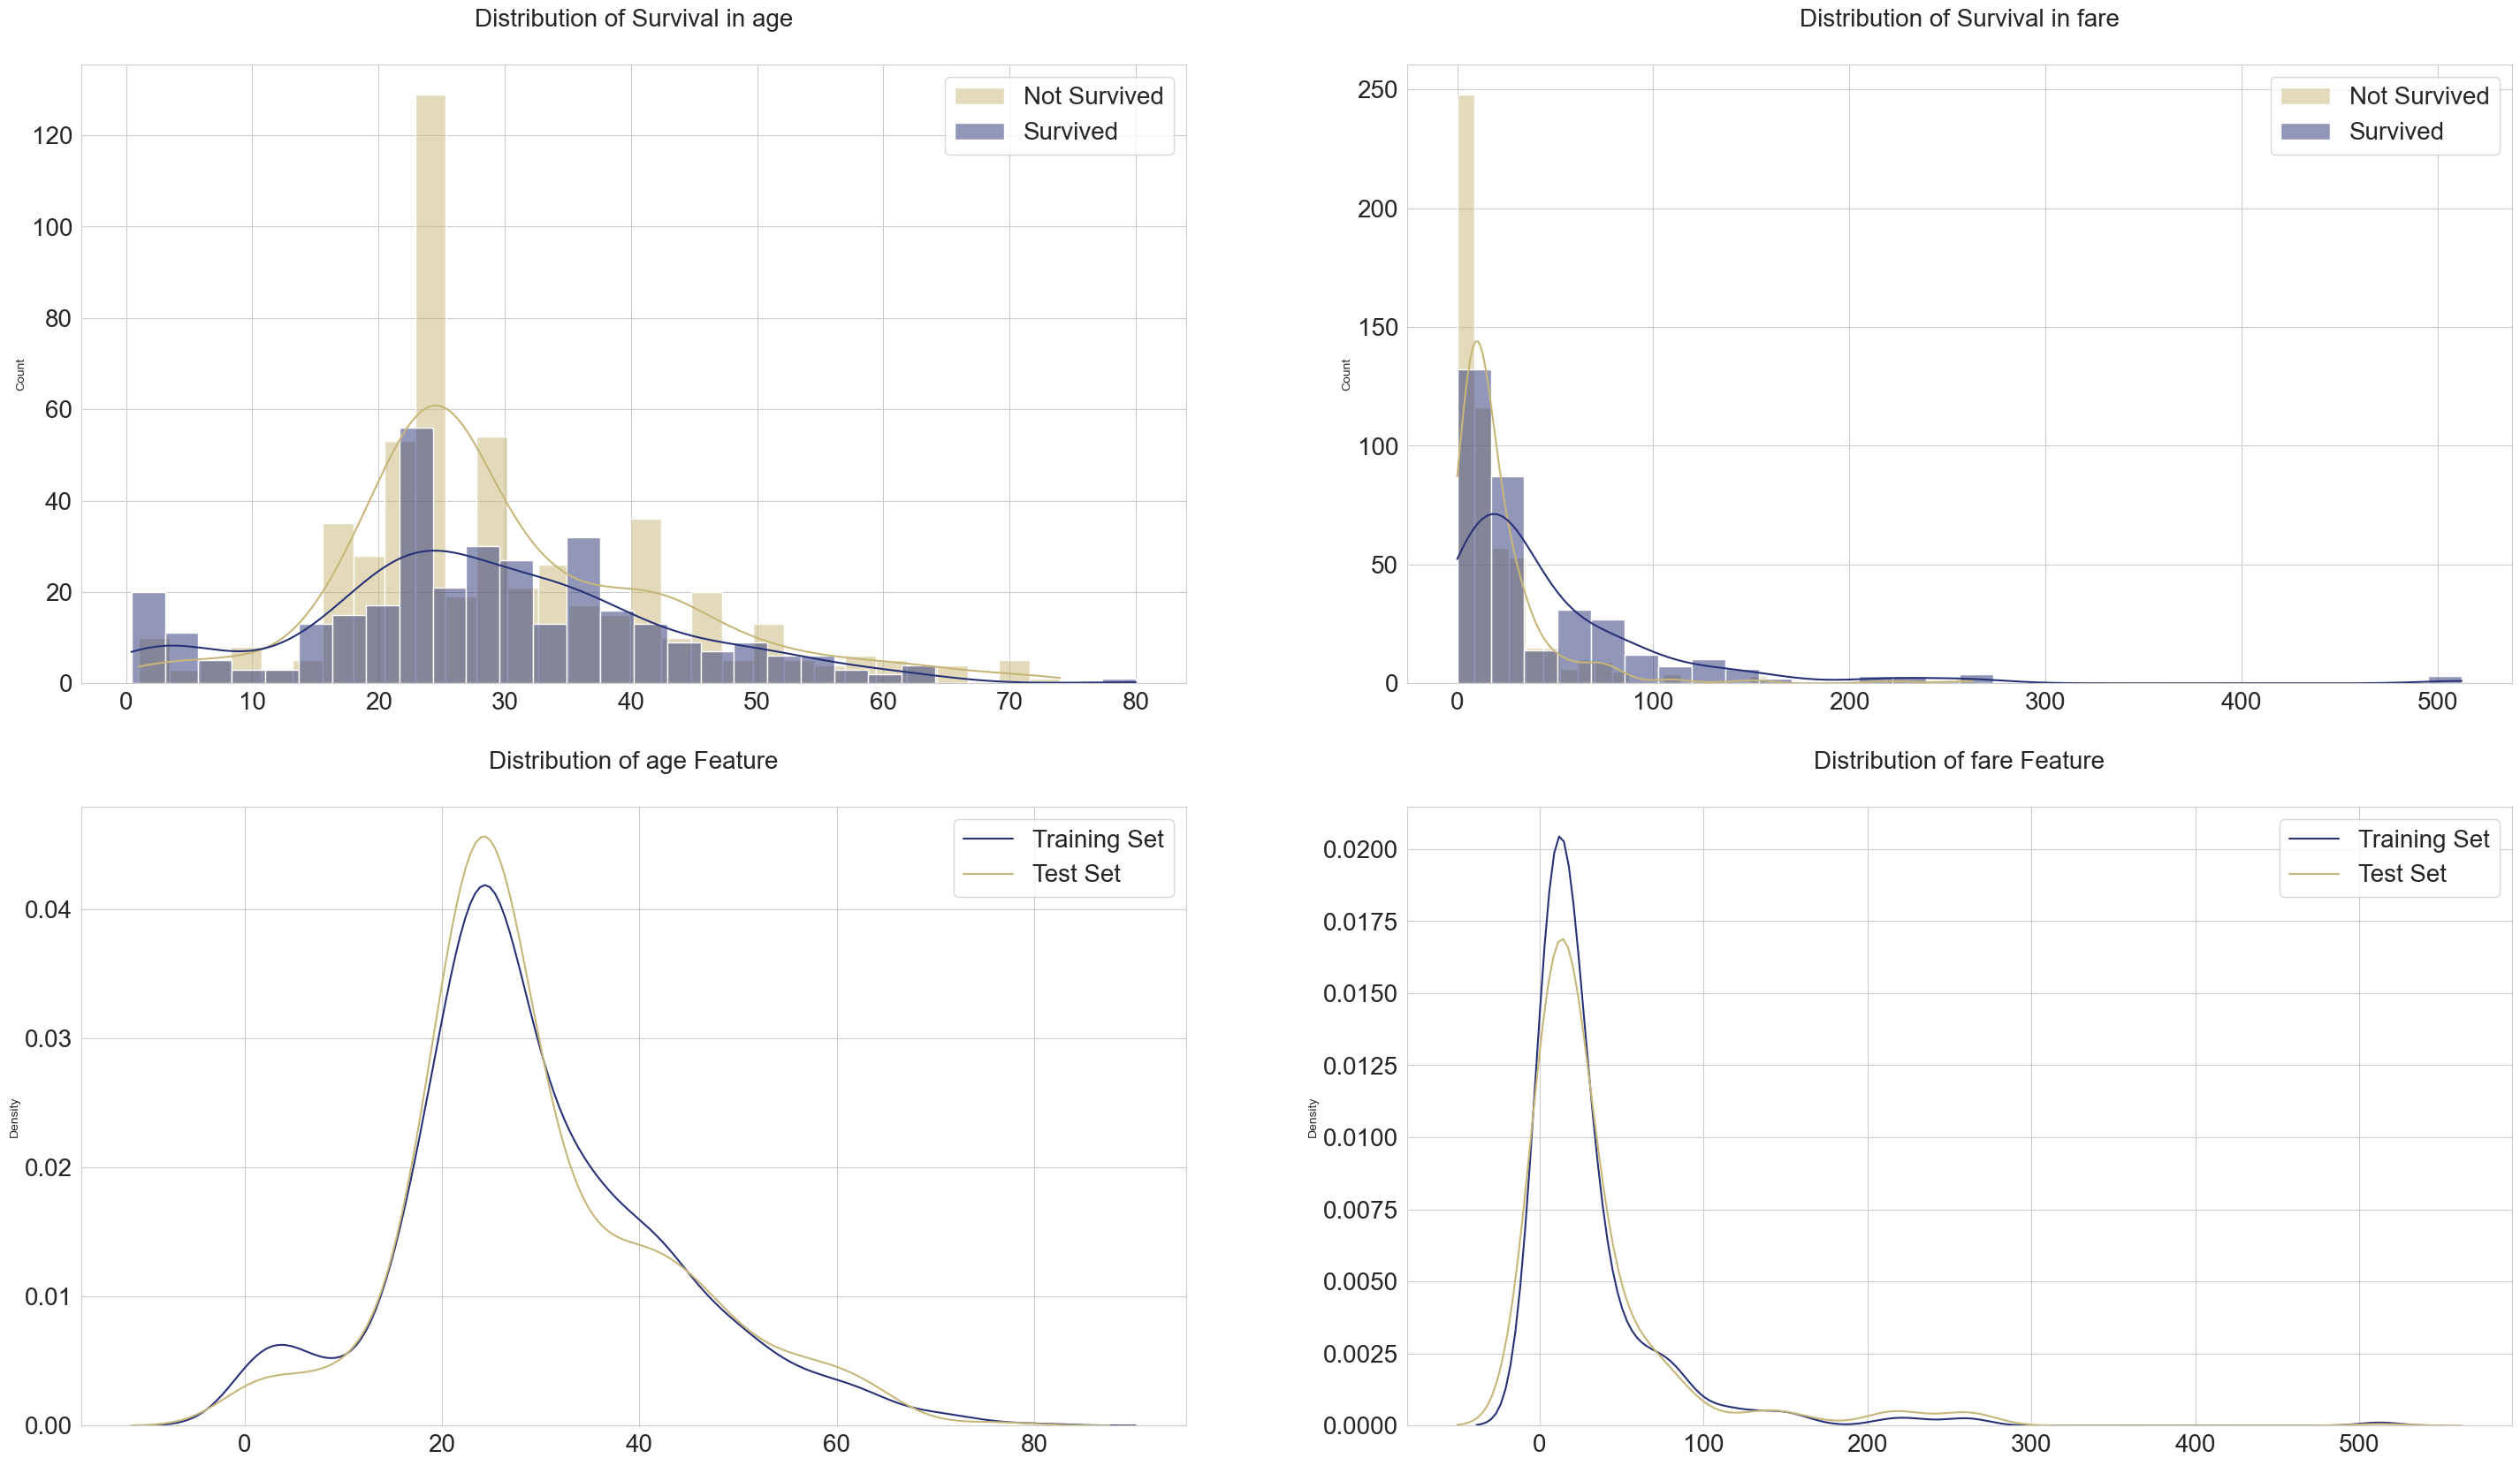

In [58]:
# DataFrames entrenamiento y prueba
df_train = combined_df[combined_df['set'] == 'Train']
df_test = combined_df[combined_df['set'] == 'Test']

# Características continuas
cont_features = ["age", "fare"]
surv = df_train['survived'] == 1

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):
    # Distribución de sobrevivientes y no sobrevivientes (histogramas)
    sns.histplot(df_train.loc[~surv, feature], label='Not Survived', bins=30, color='#C7B679', kde=True, ax=axs[0][i])
    sns.histplot(df_train.loc[surv, feature], label='Survived', bins=30, color='#273176', kde=True, ax=axs[0][i])

    # Distribución de características en los datasets de entrenamiento y prueba (densidad)
    sns.kdeplot(df_train[feature], label='Training Set', color='#273176', ax=axs[1][i])
    sns.kdeplot(df_test[feature], label='Test Set', color='#C7B679', ax=axs[1][i])

    axs[0][i].set_xlabel('')
    axs[1][i].set_xlabel('')

    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)

    axs[0][i].legend(loc='upper right', prop={'size': 20})
    axs[1][i].legend(loc='upper right', prop={'size': 20})
    axs[0][i].set_title(f'Distribution of Survival in {feature}', size=20, y=1.05)
    axs[1][i].set_title(f'Distribution of {feature} Feature', size=20, y=1.05)

plt.show()

**Correlación Múltiple**

**Pclass-Age-Survived**

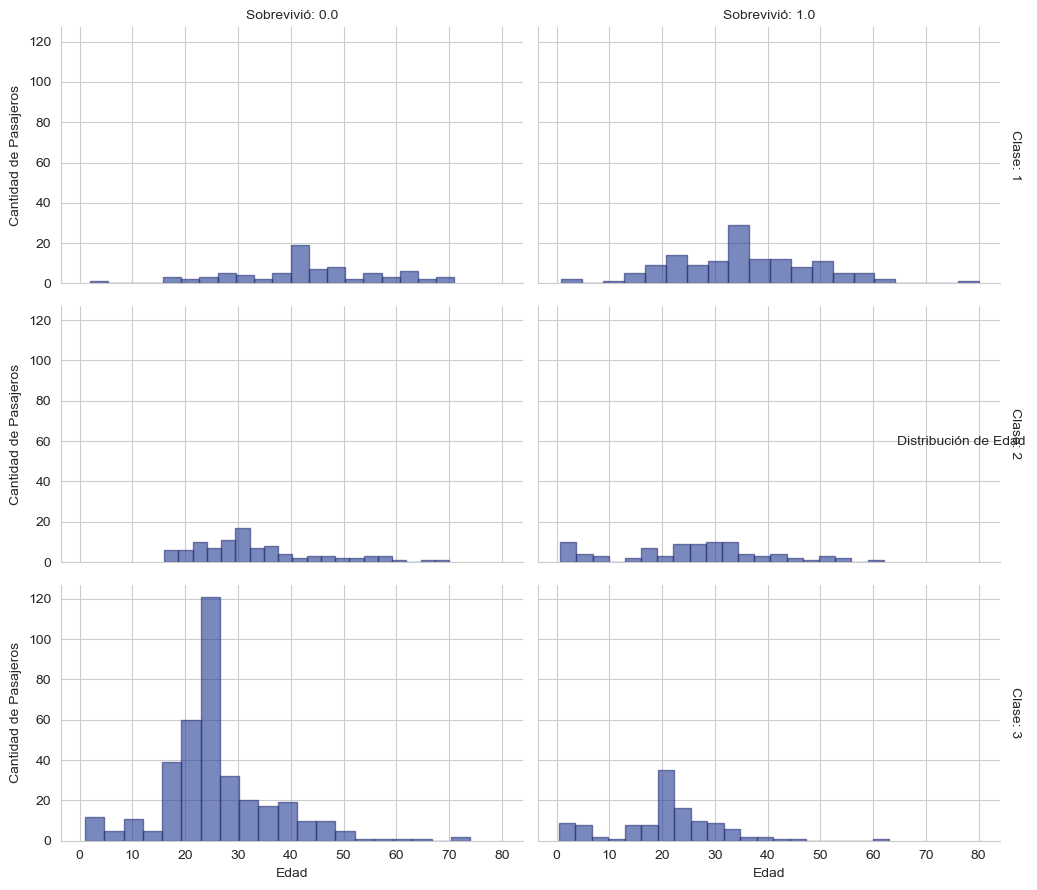

In [59]:
# FacetGrid 
grid = sns.FacetGrid(
    df_train, 
    col='survived',  # Columnas: Sobrevivió (0 o 1)
    row='pclass',    # Filas: Clase del pasajero (1, 2, 3)
    height=3,        # Altura de cada subgráfico
    aspect=1.5,      # Relación de aspecto (ancho/altura)
    palette=palette,  # Paleta colores
    margin_titles=True  # Títulos de filas y columnas en los márgenes
)

# Mapeo histogramas
grid.map(
    plt.hist, 
    'age',           
    alpha=0.6,       
    bins=20,         
    edgecolor=palette,    
    color='#223A92'
)

grid.set_titles(
    row_template="Clase: {row_name}",  
    col_template="Sobrevivió: {col_name}"  
)

grid.set_axis_labels(
    x_var="Edad",  
    y_var="Cantidad de Pasajeros"  
)

grid.add_legend(title="Distribución de Edad")  

plt.tight_layout()

plt.show()

**Sex-Pclass-Embarked-Survived**

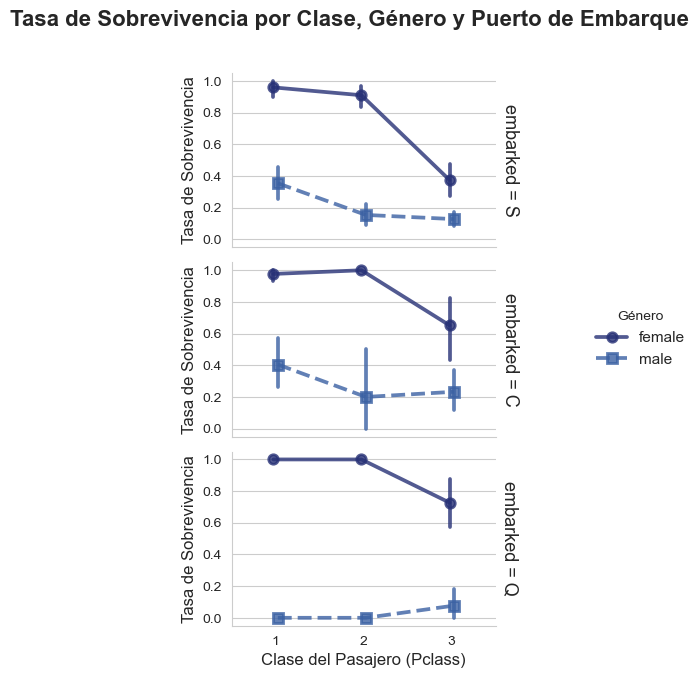

In [60]:
# Definir orden (variables categóricas)
pclass_order = sorted(df_train['pclass'].unique())  # Ordenar Pclass (1, 2, 3)
sex_order = sorted(df_train['sex'].unique())  # Ordenar Sex (female, male)

# Crear el FacetGrid por 'embarked'
grid = sns.FacetGrid(
    df_train, 
    row='embarked',  # Filas: Puerto de embarque (C, Q, S)
    height=2.2,      
    aspect=1.2,      
    margin_titles=True  
)

grid.map_dataframe(
    sns.pointplot, 
    x='pclass',       # Eje X: Clase pasajero
    y='survived',     # Eje Y: Tasa sobrevivencia
    hue='sex',        # Diferenciar por género
    palette=palette,  
    order=pclass_order,  # Orden clases
    hue_order=sex_order,  # Orden género
    dodge=True,       # Separar puntos por género
    markers=['o', 's'],  # Marcadores -género
    linestyles=["-", "--"],  # Estilos de línea -género
    alpha=0.8         
)

grid.set_axis_labels(
    x_var='Clase del Pasajero (Pclass)',  # Etiqueta eje X
    y_var='Tasa de Sobrevivencia',        # Etiqueta eje Y
    fontsize=12  # Tamaño de fuente
)

# Personalizar títulos de filas
grid.set_titles(
    'Puerto de Embarque: {row_name}',  
    size=13  
)

grid.fig.suptitle(
    'Tasa de Sobrevivencia por Clase, Género y Puerto de Embarque',  #
    fontsize=16,  
    fontweight="bold",  
    y=1.02  
)

grid.add_legend(
    title="Género",  
    fontsize=11  
)

plt.tight_layout()

plt.show()

**Fare-Sex-Embarked-Survived**

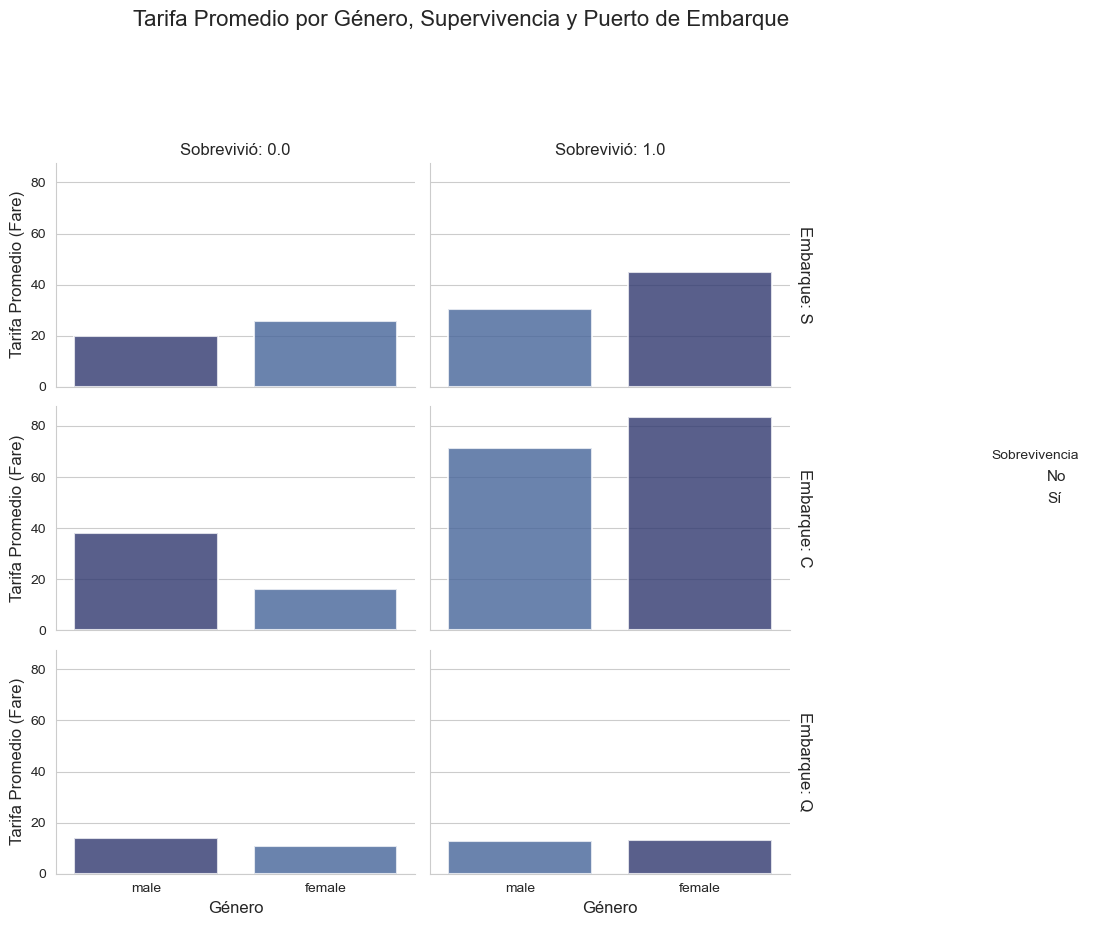

In [61]:
# FacetGrid filas embarked -columnas survived
grid = sns.FacetGrid(df_train, row='embarked', col='survived', height=3, aspect=1.4, margin_titles=True, despine=True)

grid.map_dataframe(sns.barplot, x='sex', y='fare', alpha=0.8, ci=None, palette=palette, linewidth=1.5, saturation=0.8)

grid.set_titles(row_template="Embarque: {row_name}", col_template="Sobrevivió: {col_name}",size=12)

grid.set_axis_labels("Género", "Tarifa Promedio (Fare)", fontsize=12)

grid.add_legend(title="Sobrevivencia", fontsize=11, title_fontsize=12, label_order=["No", "Sí"], bbox_to_anchor=(1.05, 0.5), loc='center left')

plt.subplots_adjust(top=0.85, right=0.85)
grid.fig.suptitle("Tarifa Promedio por Género, Supervivencia y Puerto de Embarque", fontsize=16, y=1.02)

plt.show()

##### Conclusión


**Características Continuas**

- Se han identificado patrones de división y picos en las distribuciones de variables continuas como `Age` y `Fare`.
- Modelos basados en árboles de decisión (como Random Forest o XGBoost) pueden capturar estos patrones fácilmente.
- Sin embargo, modelos lineales pueden tener dificultades para identificar estas relaciones sin una adecuada transformación de los datos (como binning o escalado).


**Características Categóricas**

- Cada categoría tiene distribuciones distintas y tasas de supervivencia diferentes, lo que indica que estas variables son relevantes para el modelo.
-  Se recomienda el uso de one-hot encoding para variables categóricas con pocas categorías, y posiblemente target encoding para variables con correlaciones fuertes con `Survived`.
- La combinación de ciertas características puede mejorar el rendimiento del modelo. Por ejemplo:

    - FamilySize = SibSp + Parch + 1 (Número total de familiares a bordo).
    - Fare_per_Person = Fare / FamilySize (Tarifa pagada por persona en el grupo).


**Creación de Nuevas Características**
- Durante el análisis exploratorio (EDA), se creó una nueva variable `Deck`, extraída de `Cabin`.
- Esta variable puede proporcionar información adicional sobre la ubicación del pasajero en el barco y su probabilidad de supervivencia.

In [62]:
# Respaldo DataFrame (post-imputación / limpieza)
combined_df_clean = combined_df.copy()


### Ingenieria de Características

**Codificación de Frecuencias**

In [63]:
# Extracción títulos
combined_df['title'] = combined_df['name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

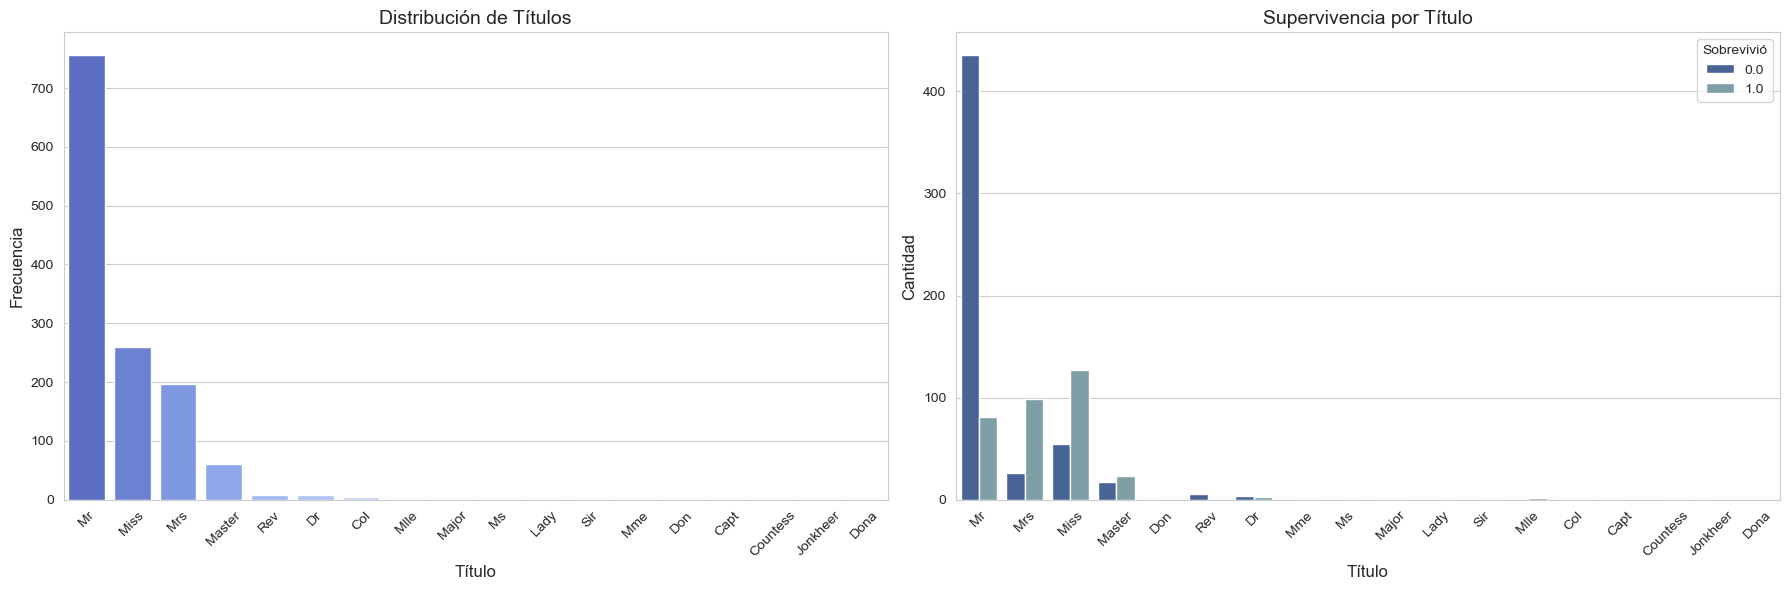

In [64]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
cm = "coolwarm"

# Gráfico-istribución de títulos
sns.barplot(
    x=combined_df['title'].value_counts().index, 
    y=combined_df['title'].value_counts().values, 
    ax=axs[0], 
    palette=cm
)

axs[0].set_title('Distribución de Títulos', fontsize=14)
axs[0].set_xlabel('Título', fontsize=12)
axs[0].set_ylabel('Frecuencia', fontsize=12)
axs[0].tick_params(axis='x', rotation=45)  # Rotar etiquetas para mejor visualización

# Gráfico-conteo de sobrevivientes por título
sns.countplot(
    x='title', 
    hue='survived', 
    data=combined_df, 
    ax=axs[1], 
    palette=palette_2
)

axs[1].set_title('Supervivencia por Título', fontsize=14)
axs[1].set_xlabel('Título', fontsize=12)
axs[1].set_ylabel('Cantidad', fontsize=12)
axs[1].tick_params(axis='x', rotation=45)
axs[1].legend(title="Sobrevivió", loc="upper right")

plt.tight_layout()

plt.show()

In [65]:
# Busqueda titulos raros
combined_df[combined_df['title'].str.contains('Dona|Jonkheer', case=False, na=False)]

age cabin embarked   fare                             name  parch  \
822   38.0   NaN        S    0.0  Reuchlin, Jonkheer. John George      0   
1305  39.0  C105        C  108.9     Oliva y Ocana, Dona. Fermina      0   

      passengerid  pclass     sex  sibsp  survived    ticket    set deck  \
822           823       1    male      0       0.0     19972  Train    M   
1305         1306       1  female      0       NaN  PC 17758   Test  ABC   

                       dataset  age_outlier  fare_outlier     title  
822   Después de la Imputación            0             0  Jonkheer  
1305  Después de la Imputación            0             1      Dona

In [66]:
# Creación Is_Married
combined_df['married'] = 0
combined_df['married'].loc[combined_df['title'] == 'Mrs'] = 1

In [67]:
combined_df[['married', 'survived']].groupby(['married'], as_index=False).mean()

married  survived
0        0  0.317232
1        1  0.792000

In [68]:
# Definición títulos
title_grouping = {
    'Miss/Mrs/Ms': ['Miss', 'Mrs', 'Ms', 'Mlle', 'Lady', 'Mme', 'Countess', 'Dona'],
    'Dr/Military/Noble/Clergy': ['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev']
}

In [69]:
# Agrupación títulos
def group_titles(title):
    for group, titles in title_grouping.items():
        if title in titles:
            return group
    return title  

In [70]:
# Aplicar agrupación
combined_df['title'] = combined_df['title'].apply(group_titles)

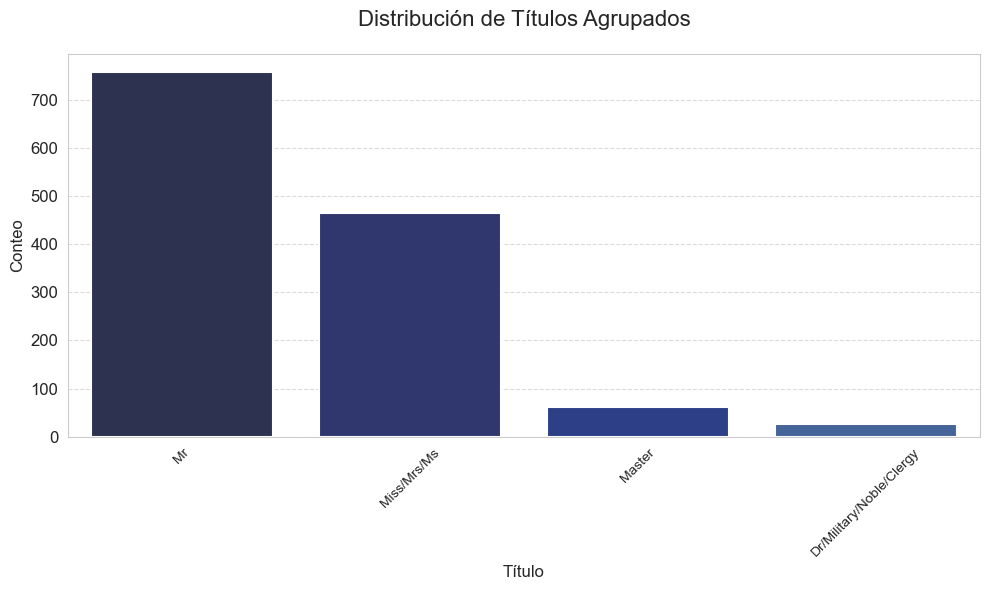

In [71]:
# Subplot
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar conteo de títulos agrupados
sns.barplot(x=combined_df['title'].value_counts().index, 
            y=combined_df['title'].value_counts().values, 
            ax=ax, palette=palette_1,  linewidth=1.5, saturation=0.8)

ax.set_title('Distribución de Títulos Agrupados', size=16, pad=20)
ax.set_xlabel("Título", fontsize=12)
ax.set_ylabel("Conteo", fontsize=12)

ax.tick_params(axis='x', labelsize=10, rotation=45)
ax.tick_params(axis='y', labelsize=12)

ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

In [72]:
# Tasa supervivencia por título
combined_df[['title', 'survived']].groupby(['title'], as_index=False).mean()

title  survived
0  Dr/Military/Noble/Clergy  0.285714
1                    Master  0.575000
2               Miss/Mrs/Ms  0.741214
3                        Mr  0.156673

**Creacion de Family_Size**

Family_Size se obtiene sumando:

    - SibSp: Número de hermanos o cónyuge a bordo.
    - Parch: Número de padres o hijos a bordo.
    - +1: Se suma 1 para incluir al pasajero mismo en el conteo.


| Family_Size | Categoría  | Descripción |
|------------|------------|------------------------------------|
| 1          | **"Solo"**   | Pasajeros sin familia a bordo.  |
| 2 - 4      | **"Pequeño"** | Familias pequeñas con mejor supervivencia. |
| 5 - 6      | **"Mediano"** | Familias de tamaño moderado con supervivencia variable. |
| 7 - 11     | **"Grande"**  | Familias grandes con menor probabilidad de supervivencia. |



In [73]:
# Creación family_size
combined_df['family_size'] = combined_df['sibsp'] + combined_df['parch'] + 1

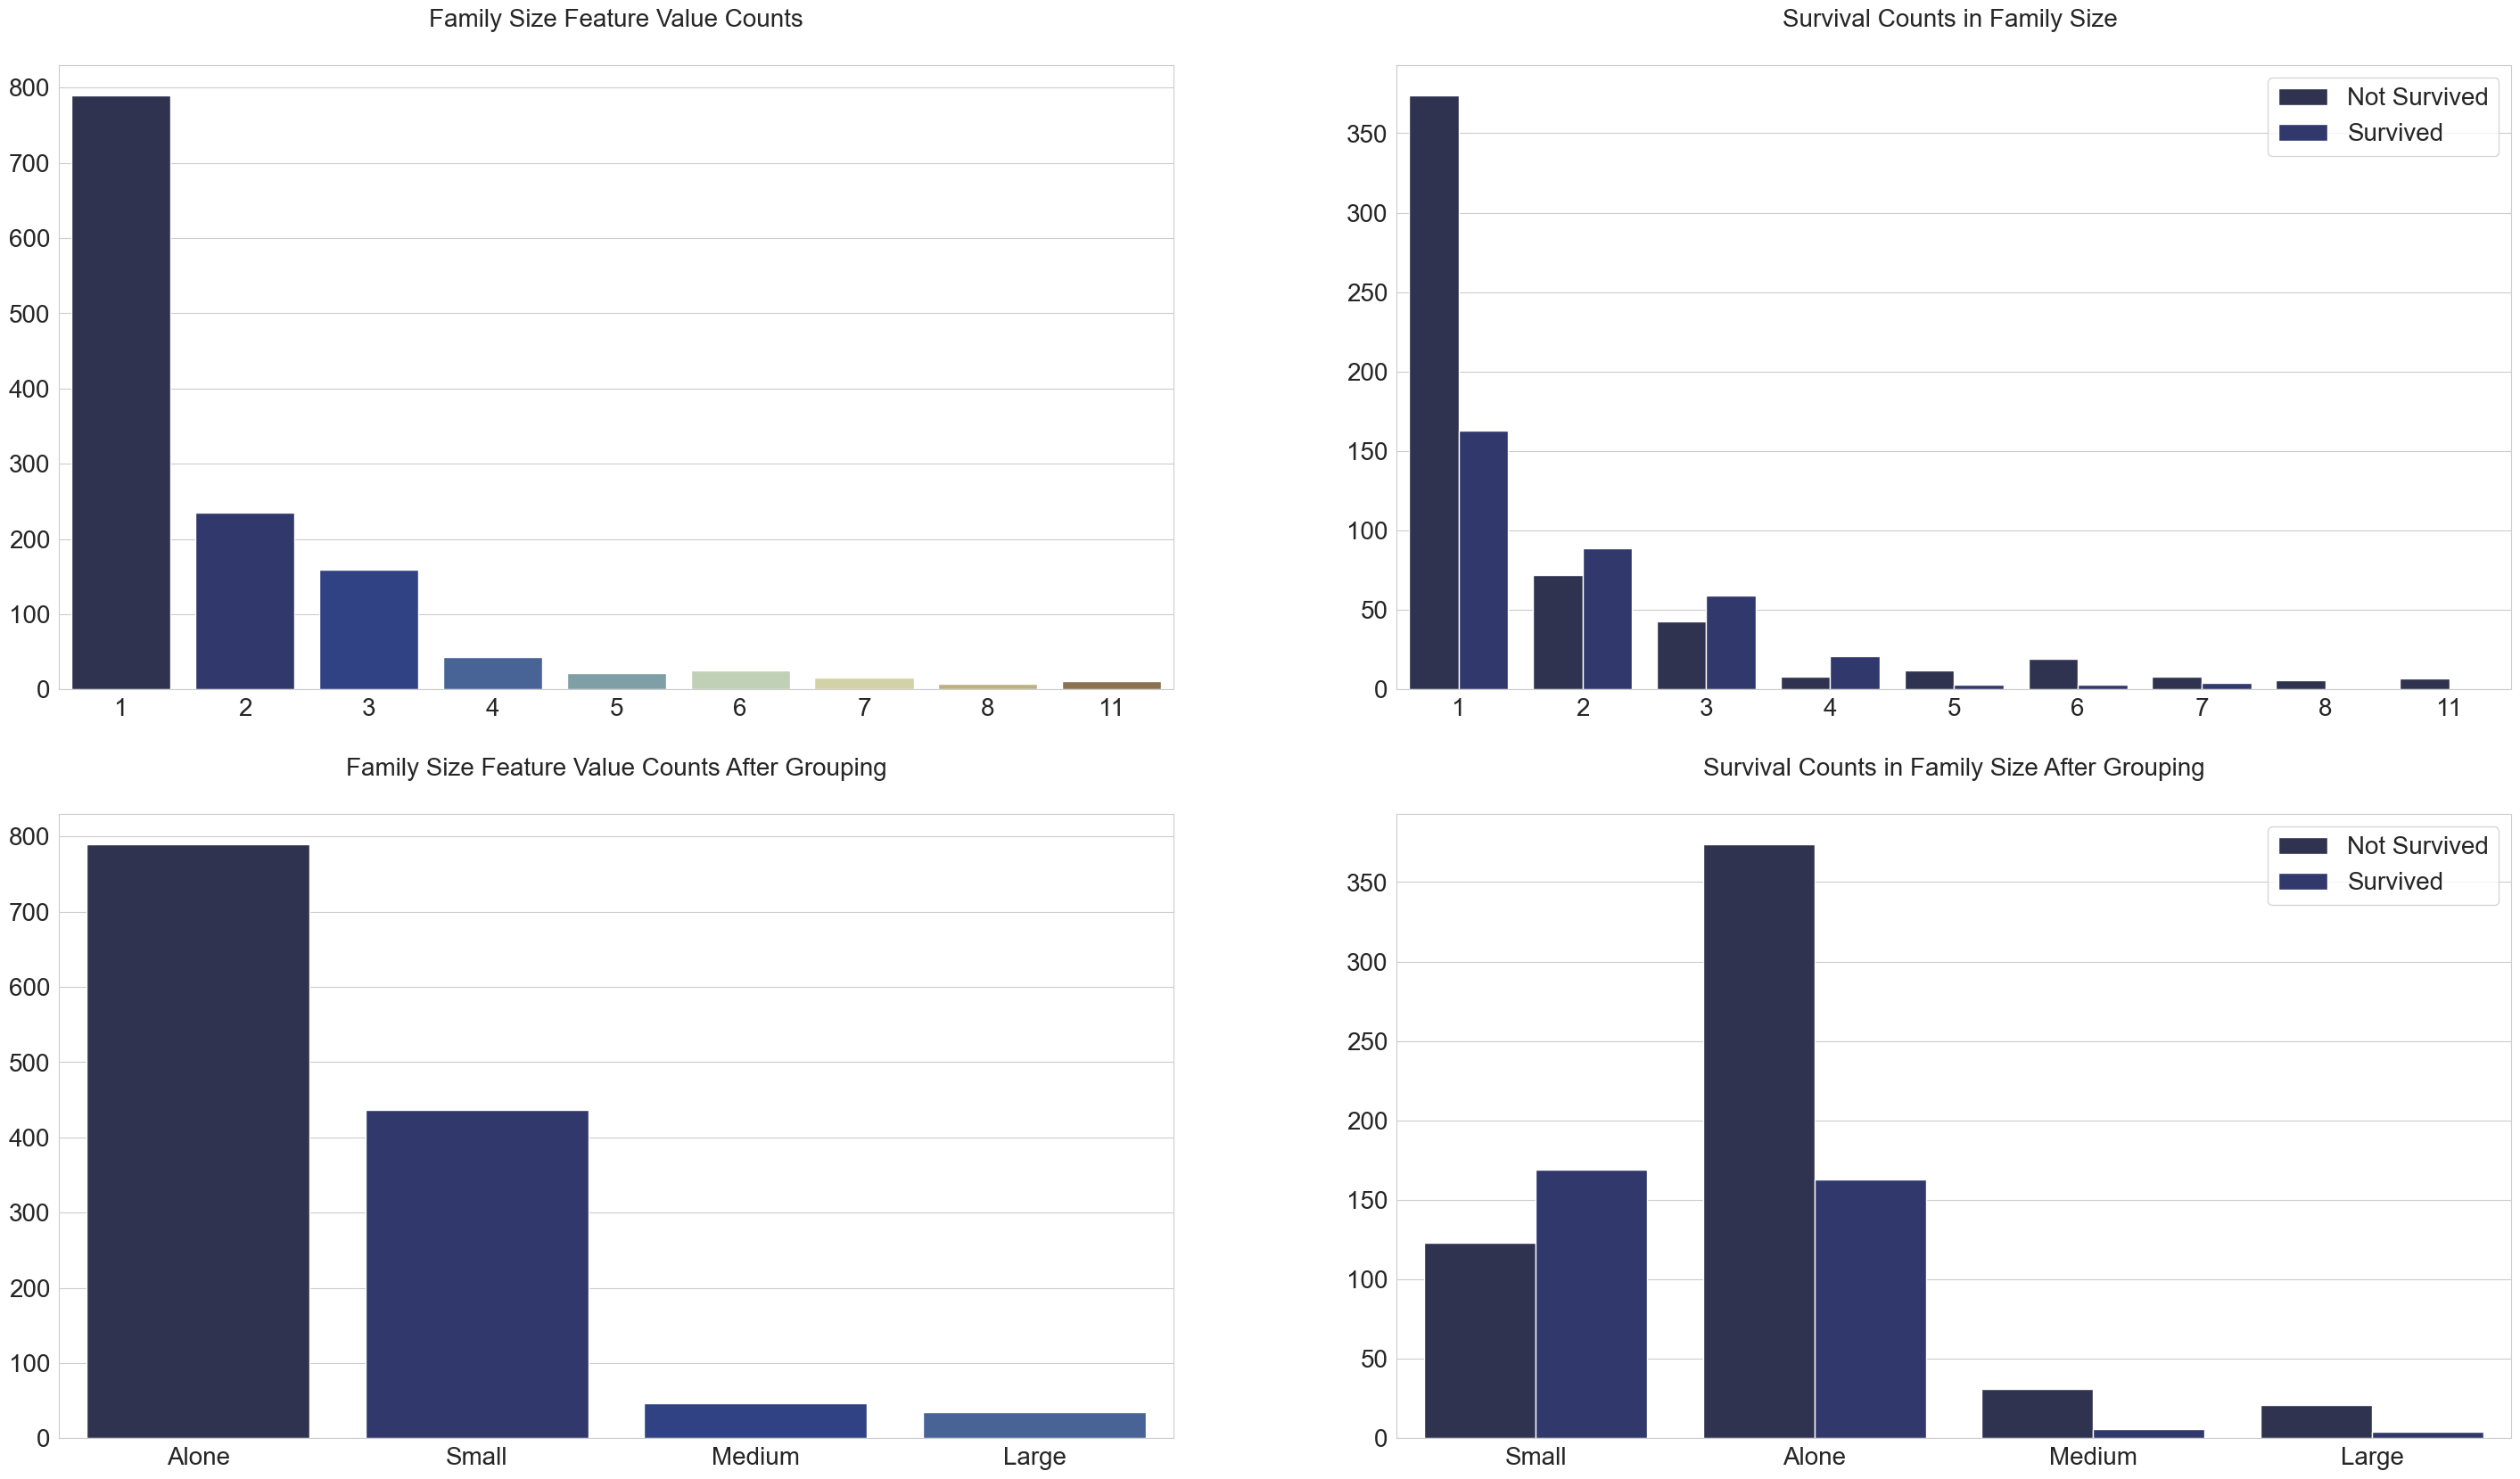

In [74]:
# Crear figura y subgráficos
fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

# Gráfico distribución de family_size
sns.barplot(x=combined_df['family_size'].value_counts().index, 
            y=combined_df['family_size'].value_counts().values, ax=axs[0][0], palette=palette_1)
sns.countplot(x='family_size', hue='survived', data=combined_df, ax=axs[0][1], palette=palette_1)

axs[0][0].set_title('Family Size Feature Value Counts', size=20, y=1.05)
axs[0][1].set_title('Survival Counts in Family Size ', size=20, y=1.05)

# Agrupar valores family_size
family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 
              6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}

combined_df['family_size_grouped'] = combined_df['family_size'].map(family_map)

# Graficar distribución después de agrupar
sns.barplot(x=combined_df['family_size_grouped'].value_counts().index, 
            y=combined_df['family_size_grouped'].value_counts().values, ax=axs[1][0], palette=palette_1)
sns.countplot(x='family_size_grouped', hue='survived', data=combined_df, ax=axs[1][1], palette=palette_1)

axs[1][0].set_title('Family Size Feature Value Counts After Grouping', size=20, y=1.05)
axs[1][1].set_title('Survival Counts in Family Size After Grouping', size=20, y=1.05)

for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')

plt.show()

**Ticket**

La variable `Ticket` contiene demasiados valores únicos para analizarlos individualmente, por lo que agruparlos por frecuencia facilita la identificación de patrones relevantes en la supervivencia de los pasajeros.

Aunque `Family_Size` captura la cantidad de familiares a bordo, muchos pasajeros viajaban en grupos que no se registraban como familia. Estos grupos podían estar conformados por:

- Amigos y conocidos que compraban boletos juntos.
- Niñeras o personal de servicio que acompañaban a familias de primera clase.
- Tripulación o trabajadores que compartían el mismo número de `Ticket`.

Dado que estos pasajeros no eran contabilizados como familia (`SibSp` o `Parch`), la frecuencia del `Ticket` (`Ticket_Frequency`) permite capturar relaciones adicionales entre pasajeros.

Una alternativa podría ser agrupar `Ticket` por su prefijo, sin embargo:

- Si los prefijos tienen significado, es probable que ya estén representados en `Pclass` o `Embarked`.
- La única información lógica que podría derivarse de los prefijos del `Ticket` ya está contenida en otras variables.
- Agrupar por frecuencia proporciona un mejor reflejo del tamaño del grupo con el que viaja un pasajero.

Relación entre Ticket_Frequency y Supervivencia:  
El análisis muestra que la tasa de supervivencia varía según el tamaño del grupo en el billete:
- Los grupos de 2 a 4 pasajeros tuvieron mayor supervivencia.
- Los pasajeros que viajaban solos (con un Ticket_Frequency = 1) tuvieron la tasa de supervivencia más baja.
- Los grupos grandes (más de 4 pasajeros) presentaron una caída drástica en la supervivencia.

Aunque Ticket_Frequency y Family_Size tienen un patrón similar, no se agrupan de la misma manera porque esto generaría una variable redundante con correlación casi perfecta con Family_Size.

- Si creáramos categorías idénticas, no aportaríamos información nueva al modelo.
- Ticket_Frequency nos permite capturar relaciones entre pasajeros que no son familiares directos.

In [75]:
# Creación ticket_frequency
combined_df['ticket_frequency'] = combined_df.groupby('ticket')['ticket'].transform('count')

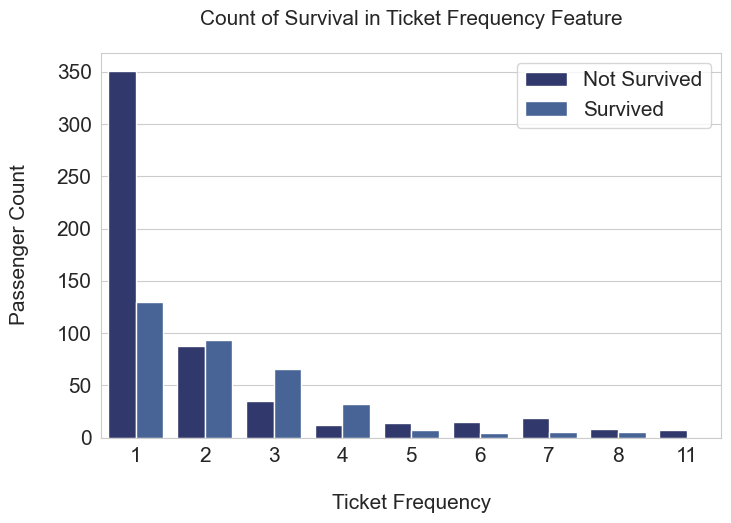

In [76]:
# Subplot
fig, axs = plt.subplots(figsize=(8, 5))
sns.countplot(x='ticket_frequency', hue='survived', data=combined_df, palette=palette)

plt.xlabel('Ticket Frequency', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Ticket Frequency'), size=15, y=1.05)

plt.show()

**Familia**

- La función **extract_surname** se utiliza para extraer los apellidos de los pasajeros a partir de la variable `name`.
- Se crea la variable `family`, que agrupa a los pasajeros con el mismo apellido, permitiendo analizar la supervivencia de familias enteras.
- Se genera una lista de apellidos que aparecen sólo en Train (familias no únicas).
- Para cada apellido en esa lista, se calcula la tasa de supervivencia familiar (más de un miembro).
- `family_survival_rate`, que representa la probabilidad de supervivencia promedio dentro de una familia.
- El mismo método se aplica para calcular la Tasa de Supervivencia de Boleto (`ticket_survival_rate`), agrupando pasajeros que compartían el mismo billete.
- Las variables `family_survival_rate_na` y `ticket_survival_rate_na` son indicadores de si la tasa de supervivencia fue calculada(1) o imputada(0) en Train.
- Se combinan ambas tasas de supervivencia (`family_survival_rate` y `ticket_survival_rate`) en una nueva característica:

$$
survival\_rate = \frac{family\_survival\_rate + ticket\_survival\_rate}{2}
$$


- También se promedian las variables binarias `family_survival_rate_na` y `ticket_survival_rate_na` en `survival_rate_na`, lo que indica si la información de supervivencia del pasajero es calculada o imputada.

In [77]:
# Extracción de apellidos
def extract_surname(data):    
    families = []
    
    for i in range(len(data)):        
        name = data.iloc[i]

        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        
        for c in string.punctuation:  # Ahora `string.punctuation` está definido
            family = family.replace(c, '').strip()
            
        families.append(family)
            
    return families

In [78]:
# Extracción de apellidos
combined_df['family'] = extract_surname(combined_df['name'])

In [79]:
# Separar DataFrame en entrenamiento
df_train = combined_df[combined_df['set'] == 'Train']

# Convertir columnas a tipo numérico (si hay errores, poner NaN)
df_train.loc[:, 'survived'] = pd.to_numeric(df_train['survived'], errors='coerce')
df_train.loc[:, 'family_size'] = pd.to_numeric(df_train['family_size'], errors='coerce')
df_train.loc[:, 'ticket_frequency'] = pd.to_numeric(df_train['ticket_frequency'], errors='coerce')

# Mediana 
df_family_survival_rate = df_train.groupby('family')[['survived', 'family_size']].median()
df_ticket_survival_rate = df_train.groupby('ticket')[['survived', 'ticket_frequency']].median()

# Almacenar tasas de supervivencia (train)
family_rates = {}
ticket_rates = {}

# Verificar existencia familia y con más de un miembro (train)
for family, row in df_family_survival_rate.iterrows():
    if row['family_size'] > 1:
        family_rates[family] = row['survived']

# Verificar existencia ticket y con más de un miembro (train)
for ticket, row in df_ticket_survival_rate.iterrows():
    if row['ticket_frequency'] > 1:
        ticket_rates[ticket] = row['survived']
        
# Tasas de supervivencia
print("Tasas de supervivencia por familia:")
print(family_rates)

print("\nTasas de supervivencia por ticket:")
print(ticket_rates)

Tasas de supervivencia por familia:
{'Abbott': 0.5, 'Abelson': 0.5, 'Ahlin': 0.0, 'Aks': 1.0, 'Allison': 0.0, 'AndersenJensen': 1.0, 'Andersson': 0.0, 'Andrews': 0.5, 'Angle': 1.0, 'Appleton': 1.0, 'ArnoldFranchi': 0.0, 'Asplund': 1.0, 'Astor': 1.0, 'Backstrom': 0.5, 'Baclini': 1.0, 'Barbara': 0.0, 'Baxter': 0.5, 'Beane': 1.0, 'Becker': 1.0, 'Beckwith': 1.0, 'Bishop': 1.0, 'Boulos': 0.0, 'Bourke': 0.0, 'Bowerman': 1.0, 'Braund': 0.0, 'Brown': 1.0, 'Bryhl': 0.0, 'Caldwell': 1.0, 'Caram': 0.0, 'Cardeza': 1.0, 'Carter': 1.0, 'Cavendish': 0.0, 'Chaffee': 0.0, 'Chambers': 1.0, 'Chapman': 0.0, 'Chibnall': 1.0, 'Christy': 1.0, 'Chronopoulos': 0.0, 'Clarke': 1.0, 'Collyer': 1.0, 'Compton': 1.0, 'Coutts': 1.0, 'Cribb': 0.0, 'Crosby': 0.5, 'Cumings': 1.0, 'Danbom': 0.0, 'Davidson': 0.0, 'Davies': 0.0, 'Davison': 1.0, 'Dean': 0.5, 'Dick': 1.0, 'Dodge': 1.0, 'Doling': 1.0, 'Douglas': 0.0, 'Drew': 1.0, 'Duff Gordon': 1.0, 'Duran y More': 1.0, 'Elias': 0.0, 'Eustis': 1.0, 'Faunthorpe': 1.0, 'Ford': 

In [80]:
# Tasa media de supervivencia (train)
mean_survival_rate = np.mean(df_train['survived'])

# Inicialización tasas de supervivencia e indicadores NA
family_survival_rate = []
family_survival_rate_na = []
ticket_survival_rate = []
ticket_survival_rate_na = []

# Cálculo tasas de supervivencia por familia - ticket
for i in range(len(combined_df)):
    # Cálculo Family_Survival_Rate y Family_Survival_Rate_NA
    if combined_df['family'].iloc[i] in family_rates:
        family_survival_rate.append(family_rates[combined_df['family'].iloc[i]])
        family_survival_rate_na.append(1)
    else:
        family_survival_rate.append(mean_survival_rate)
        family_survival_rate_na.append(0)
    
    # Cálculo Ticket_Survival_Rate y Ticket_Survival_Rate_NA
    if combined_df['ticket'].iloc[i] in ticket_rates:
        ticket_survival_rate.append(ticket_rates[combined_df['ticket'].iloc[i]])
        ticket_survival_rate_na.append(1)
    else:
        ticket_survival_rate.append(mean_survival_rate)
        ticket_survival_rate_na.append(0)

# Añadir columnas combined_df
combined_df.loc[:, 'family_survival_rate'] = family_survival_rate
combined_df.loc[:, 'family_survival_rate_na'] = family_survival_rate_na
combined_df.loc[:, 'ticket_survival_rate'] = ticket_survival_rate
combined_df.loc[:, 'ticket_survival_rate_na'] = ticket_survival_rate_na

In [81]:
# Cálculo Survival_Rate y Survival_Rate_NA en combined_df
combined_df.loc[:, 'survival_rate'] = (combined_df['ticket_survival_rate'] + combined_df['family_survival_rate']) / 2
combined_df.loc[:, 'survival_rate_na'] = (combined_df['ticket_survival_rate_na'] + combined_df['family_survival_rate_na']) / 2

**Características sintéticas**

**Age*Pclass**  
 `Age` * `Pclass` crea una nueva variable que combina los efectos de ambas características.

In [82]:
# Creación age* class
combined_df['age*class'] = combined_df.age * combined_df.pclass

In [83]:
# Asegurar que 'survived' es numérico
combined_df['survived'] = pd.to_numeric(combined_df['survived'], errors='coerce')

# Tasa de superviviencia por bins
for bins in [4, 6, 8, 10, 13, 15]:
    combined_df['age*classband'] = pd.qcut(combined_df['age*class'], bins, duplicates='drop')
    print(f"\nBins: {bins}")
    print(combined_df[['age*classband', 'survived']].groupby(['age*classband'], observed=False).mean())


Bins: 4
               survived
age*classband          
(0.509, 42.0]  0.632911
(42.0, 62.0]   0.388350
(62.0, 75.0]   0.257143
(75.0, 222.0]  0.241379

Bins: 6
               survived
age*classband          
(0.509, 36.0]  0.694915
(36.0, 49.0]   0.463415
(49.0, 62.0]   0.349650
(62.0, 75.0]   0.257143
(75.0, 84.0]   0.375000
(84.0, 222.0]  0.200000

Bins: 8
               survived
age*classband          
(0.509, 30.0]  0.677419
(30.0, 42.0]   0.584071
(42.0, 54.0]   0.411765
(54.0, 62.0]   0.356322
(62.0, 69.0]   0.407407
(69.0, 75.0]   0.138686
(75.0, 93.0]   0.333333
(93.0, 222.0]  0.172414

Bins: 10
               survived
age*classband          
(0.509, 26.0]  0.729167
(26.0, 38.0]   0.635417
(38.0, 48.0]   0.436893
(48.0, 54.0]   0.377049
(54.0, 62.0]   0.356322
(62.0, 66.0]   0.408602
(66.0, 75.0]   0.164474
(75.0, 78.0]   0.222222
(78.0, 99.0]   0.347826
(99.0, 222.0]  0.139785

Bins: 13
                  survived
age*classband             
(0.509, 22.0]     0.730769
(22.0, 3

**Información Mutua vs Número de Bins**

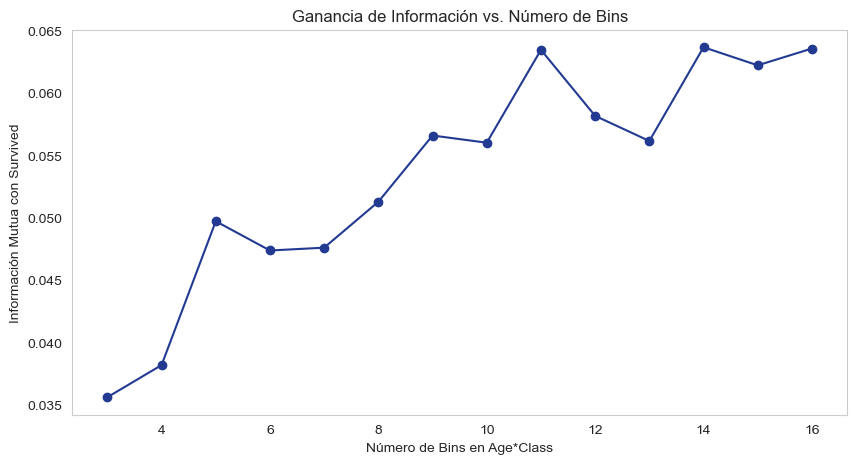

In [84]:
# Graficar información mutua vs. número de bins
bin_counts = list(range(3, 17))  
mi_scores = []  

for bins in bin_counts:
    combined_df['age*classband'] = pd.qcut(combined_df['age*class'], bins, duplicates='drop')  # Evitar duplicados
    mi = mutual_info_score(combined_df['age*classband'].astype(str), combined_df['survived'].astype(str))  # Convertir a str
    mi_scores.append(mi)

plt.figure(figsize=(10, 5))
plt.plot(bin_counts, mi_scores, marker='o', linestyle='-', color='#223A92')
plt.xlabel("Número de Bins en Age*Class")
plt.ylabel("Información Mutua con Survived")
plt.title("Ganancia de Información vs. Número de Bins")
plt.grid()
plt.show()

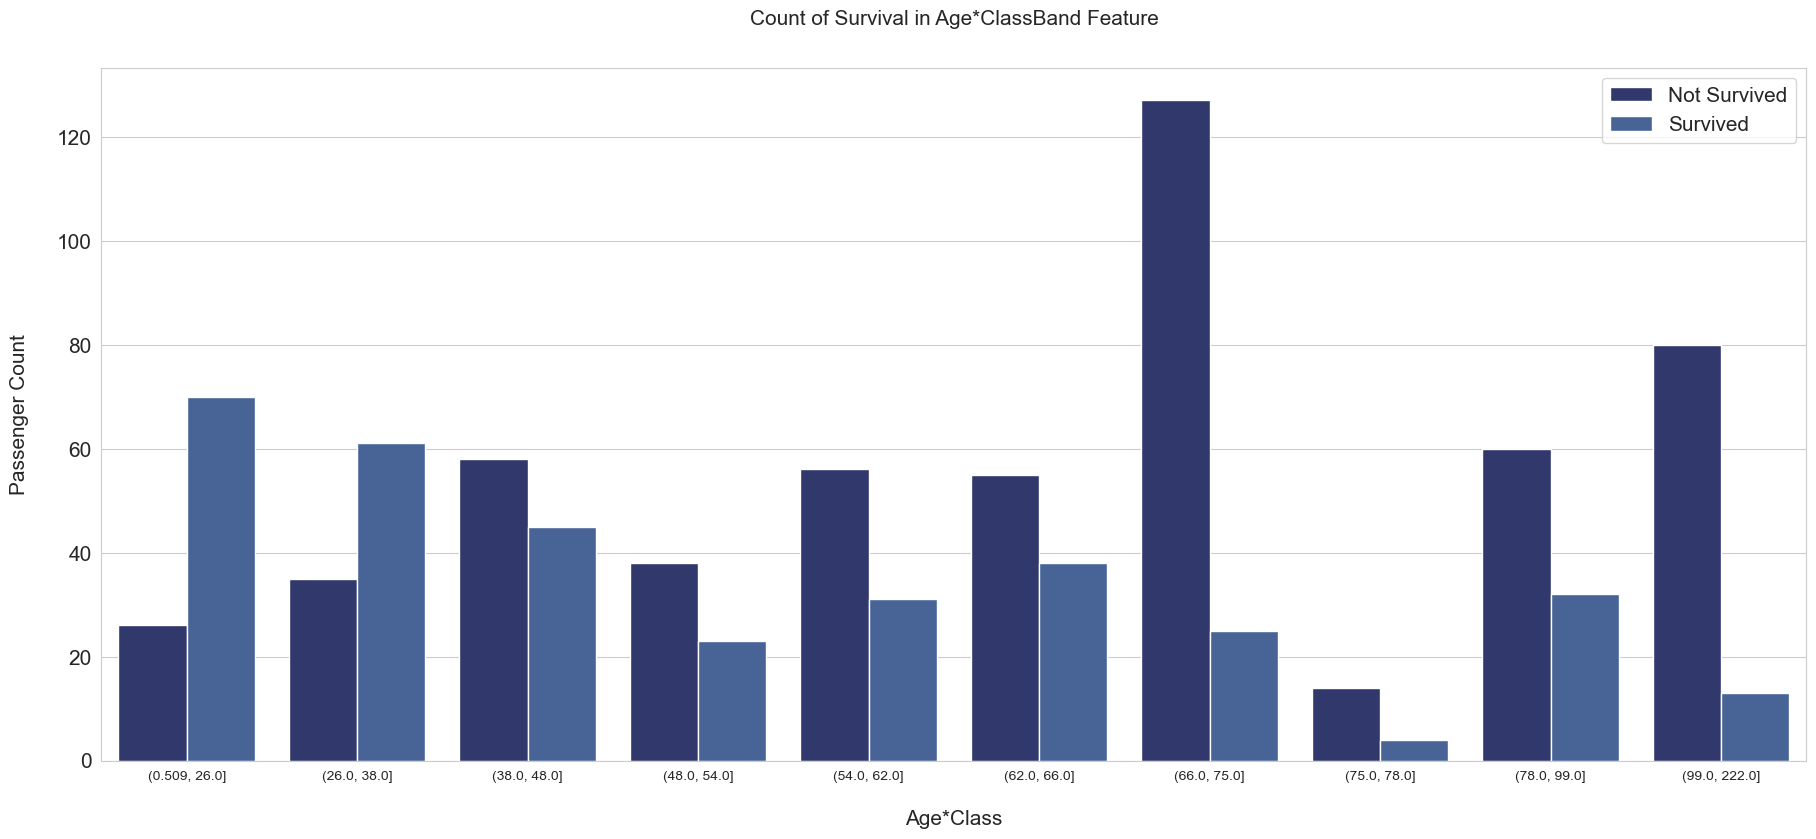

In [85]:
# Tasa de supervivencia por bins considerados
bins = 10
combined_df['age*classband'] = pd.qcut(combined_df['age*class'], bins)

fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='age*classband', hue='survived', data=combined_df, palette=palette)

plt.xlabel('Age*Class', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Age*ClassBand'), size=15, y=1.05)

plt.show()

**NameLength**

In [86]:
# Creación namelength
combined_df['namelength'] = combined_df['name'].apply(len)

In [87]:
# # Tasa de superviviencia por bins
for bins in [4, 6, 8, 10, 13, 15]:
    combined_df['namelengthband'] = pd.qcut(combined_df['namelength'], bins, duplicates='drop')
    print(f"\nBins: {bins}")
    print(combined_df[['namelengthband', 'survived']].groupby(['namelengthband'], observed=False).mean())


Bins: 4
                survived
namelengthband          
(11.999, 20.0]  0.230453
(20.0, 25.0]    0.325581
(25.0, 30.0]    0.364929
(30.0, 82.0]    0.626126

Bins: 6
                survived
namelengthband          
(11.999, 19.0]  0.220588
(19.0, 22.0]    0.307692
(22.0, 25.0]    0.328467
(25.0, 28.0]    0.316901
(28.0, 35.0]    0.496815
(35.0, 82.0]    0.694030

Bins: 8
                survived
namelengthband          
(11.999, 18.0]  0.214286
(18.0, 20.0]    0.252427
(20.0, 23.0]    0.307692
(23.0, 25.0]    0.346939
(25.0, 27.0]    0.292929
(27.0, 30.0]    0.428571
(30.0, 39.0]    0.512000
(39.0, 82.0]    0.773196

Bins: 10
                survived
namelengthband          
(11.999, 17.0]  0.222222
(17.0, 19.0]    0.219298
(19.0, 21.0]    0.303797
(21.0, 23.2]    0.298701
(23.2, 25.0]    0.346939
(25.0, 27.0]    0.292929
(27.0, 29.0]    0.426667
(29.0, 32.0]    0.455556
(32.0, 41.2]    0.574713
(41.2, 82.0]    0.780488

Bins: 13
                survived
namelengthband          
(11

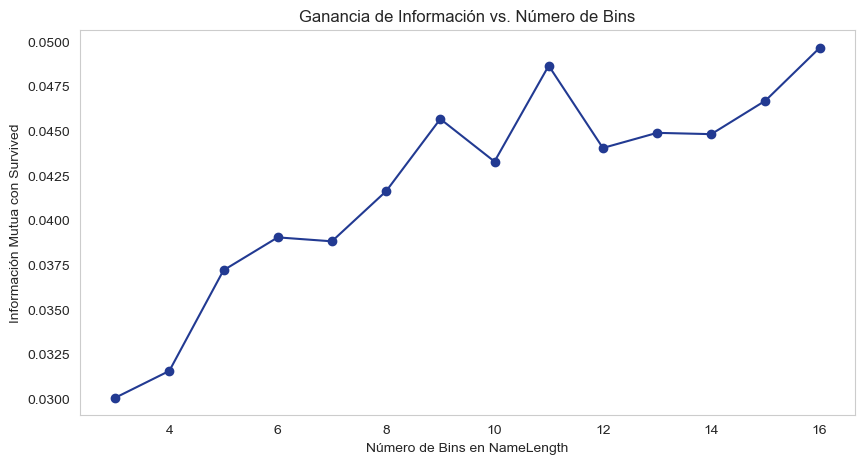

In [88]:
# Graficar la información mutua vs. número de bins
bin_counts = list(range(3, 17))  
mi_scores = [] 

for bins in bin_counts:
    combined_df['namelengthband'] = pd.qcut(combined_df['namelength'], bins, duplicates='drop')  # Evitar duplicados
    mi = mutual_info_score(combined_df['namelengthband'].astype(str), combined_df['survived'].astype(str))  # Convertir a str
    mi_scores.append(mi)

plt.figure(figsize=(10, 5))
plt.plot(bin_counts, mi_scores, marker='o', linestyle='-', color='#223A92')
plt.xlabel("Número de Bins en NameLength")
plt.ylabel("Información Mutua con Survived")
plt.title("Ganancia de Información vs. Número de Bins")
plt.grid()
plt.show()

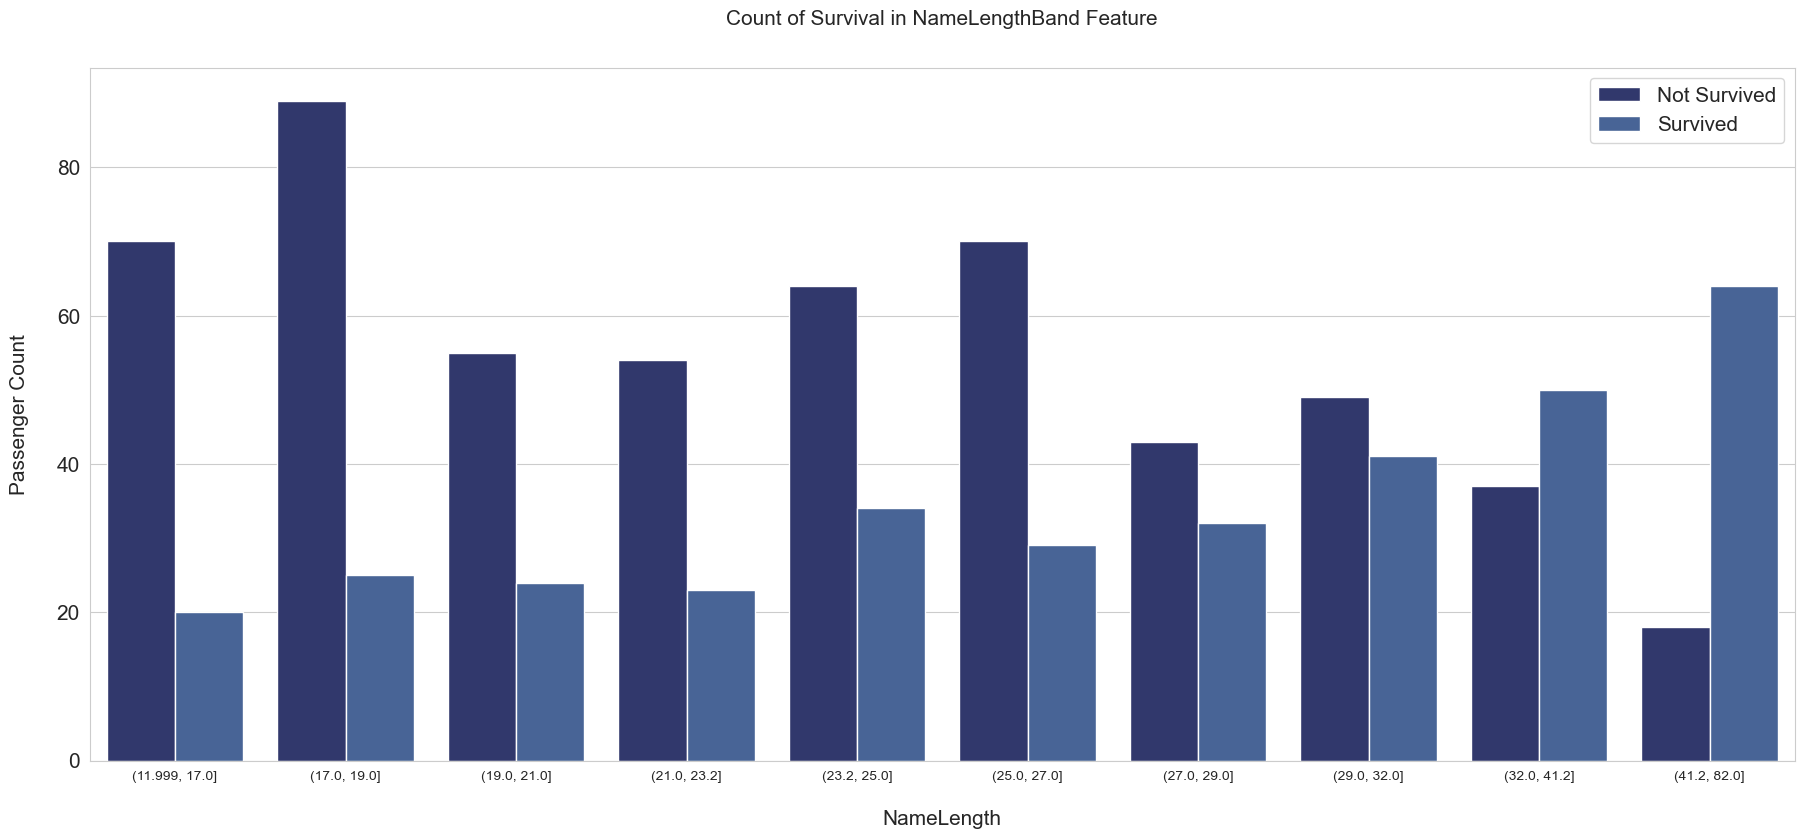

In [89]:
# Tasa de supervivencia por bins considerados
bins = 10
combined_df['namelengthband'] = pd.qcut(combined_df['namelength'], bins)

fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='namelengthband', hue='survived', data=combined_df, palette=palette)

plt.xlabel('NameLength', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('NameLengthBand'), size=15, y=1.05)

plt.show()

**Fare/PClass**

In [90]:
# Creación fareperclass
combined_df['fareperclass'] = combined_df['fare'] / combined_df['pclass']

In [91]:
# Tasa de superviviencia por bins
for bins in [4, 6, 8, 10, 13, 15]:
    combined_df['fareperclassband'] = pd.qcut(combined_df['fareperclass'], bins, duplicates='drop')
    print(f"\nBins: {bins}")
    print(combined_df[['fareperclassband', 'survived']].groupby(['fareperclassband'], observed=False).mean())


Bins: 4
                   survived
fareperclassband           
(-0.001, 2.632]    0.198198
(2.632, 6.419]     0.307018
(6.419, 23.183]    0.401786
(23.183, 512.329]  0.635945

Bins: 6
                  survived
fareperclassband          
(-0.001, 2.592]   0.206452
(2.592, 2.887]    0.190789
(2.887, 6.419]    0.370629
(6.419, 13.0]     0.385542
(13.0, 42.4]      0.458015
(42.4, 512.329]   0.722222

Bins: 8
                  survived
fareperclassband          
(-0.001, 2.583]   0.208633
(2.583, 2.632]    0.180723
(2.632, 3.439]    0.201754
(3.439, 6.419]    0.412281
(6.419, 10.425]   0.333333
(10.425, 23.183]  0.476636
(23.183, 59.4]    0.532110
(59.4, 512.329]   0.740741

Bins: 10
                  survived
fareperclassband          
(-0.001, 2.526]   0.142857
(2.526, 2.618]    0.298851
(2.618, 2.683]    0.179245
(2.683, 4.818]    0.276316
(4.818, 6.419]    0.388889
(6.419, 8.04]     0.402439
(8.04, 13.86]     0.363636
(13.86, 30.0]     0.500000
(30.0, 78.02]     0.573034
(78.02, 512.

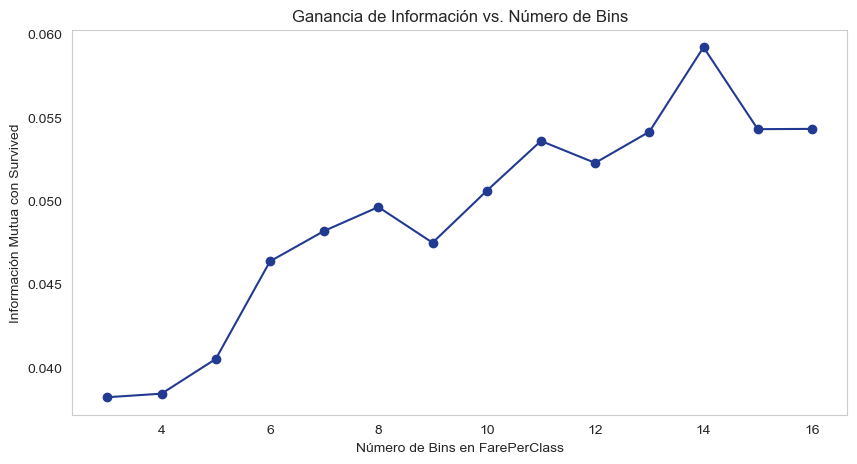

In [92]:
# Graficar la información mutua vs. número de bins
bin_counts = list(range(3, 17))  
mi_scores = []  

for bins in bin_counts:
    combined_df['fareperclassband'] = pd.qcut(combined_df['fareperclass'], bins, duplicates='drop')  # Evitar duplicados
    mi = mutual_info_score(combined_df['fareperclassband'].astype(str), combined_df['survived'].astype(str))  # Convertir a str
    mi_scores.append(mi)

plt.figure(figsize=(10, 5))
plt.plot(bin_counts, mi_scores, marker='o', linestyle='-', color='#223A92')
plt.xlabel("Número de Bins en FarePerClass")
plt.ylabel("Información Mutua con Survived")
plt.title("Ganancia de Información vs. Número de Bins")
plt.grid()
plt.show()

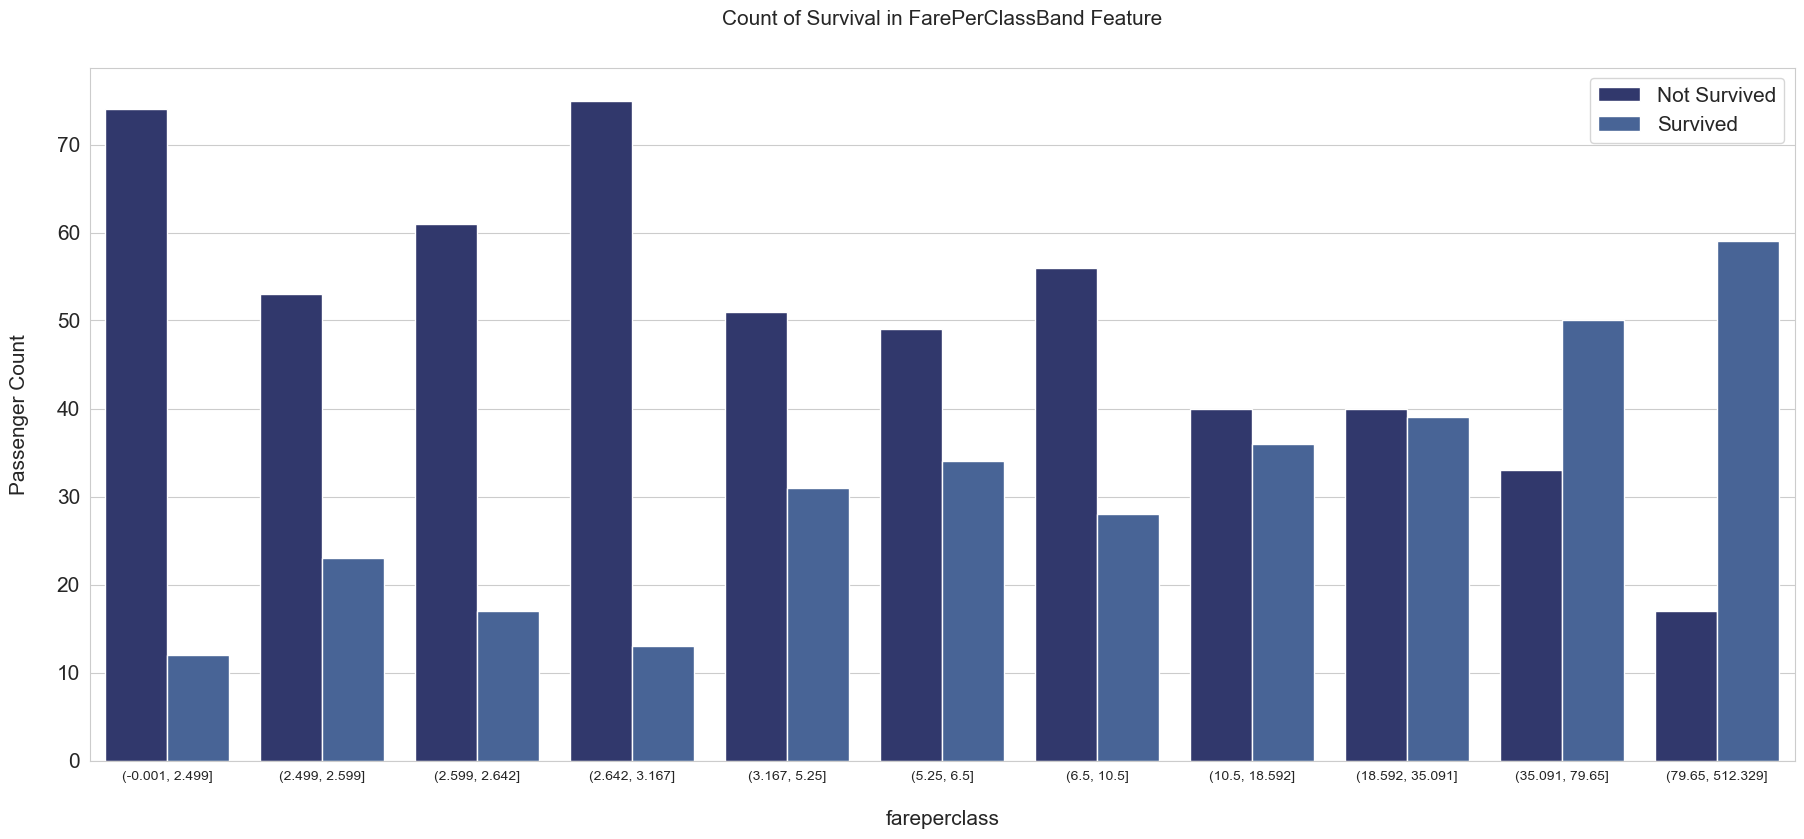

In [93]:
# Tasa de superviviencia por bins considerados
bins = 11
combined_df['fareperclassband'] = pd.qcut(combined_df['fareperclass'], bins)

fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='fareperclassband', hue='survived', data=combined_df, palette=palette)

plt.xlabel('fareperclass', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('FarePerClassBand'), size=15, y=1.05)

plt.show()

**HasCabin**

In [94]:
# Creación hascabin
combined_df['hascabin'] = combined_df['cabin'].notna().astype(int)

In [95]:
# Tasa de superviviencia
combined_df[['hascabin', 'survived']].groupby(['hascabin'], as_index=False).mean() 

hascabin  survived
0         0  0.299854
1         1  0.666667

#### 2.3 Categorización de valores continuos

**Fare**

In [96]:
# Tasa de superviviencia por bins
for bins in [4, 6, 8, 10, 13, 15]:
    combined_df['fareband'] = pd.qcut(combined_df['fare'], bins, duplicates='drop')
    print(f"\nBins: {bins}")
    print(combined_df[['fareband', 'survived']].groupby(['fareband'], observed=False).mean())


Bins: 4
                   survived
fareband                   
(-0.001, 7.896]    0.197309
(7.896, 14.454]    0.303571
(14.454, 31.275]   0.441048
(31.275, 512.329]  0.600000

Bins: 6
                 survived
fareband                 
(-0.001, 7.775]  0.205128
(7.775, 8.662]   0.190789
(8.662, 14.454]  0.366906
(14.454, 26.0]   0.436242
(26.0, 53.1]     0.435065
(53.1, 512.329]  0.695035

Bins: 8
                  survived
fareband                  
(-0.001, 7.75]    0.207143
(7.75, 7.896]     0.180723
(7.896, 9.844]    0.205357
(9.844, 14.454]   0.401786
(14.454, 24.15]   0.436364
(24.15, 31.275]   0.445378
(31.275, 69.55]   0.481818
(69.55, 512.329]  0.723810

Bins: 10
                  survived
fareband                  
(-0.001, 7.57]    0.141304
(7.57, 7.854]     0.298851
(7.854, 8.05]     0.179245
(8.05, 10.5]      0.230769
(10.5, 14.454]    0.428571
(14.454, 21.558]  0.425287
(21.558, 26.82]   0.511364
(26.82, 41.579]   0.381443
(41.579, 78.02]   0.529412
(78.02, 512.329]  0.

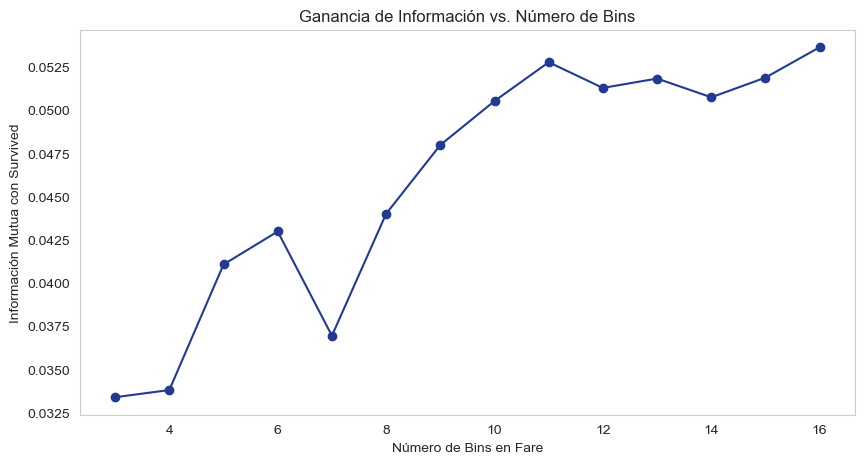

In [97]:
# Graficar la información mutua vs. número de bins
bin_counts = list(range(3, 17))  
mi_scores = [] 

for bins in bin_counts:
    combined_df['fareband'] = pd.qcut(combined_df['fare'], bins, duplicates='drop')  # Evitar duplicados
    mi = mutual_info_score(combined_df['fareband'].astype(str), combined_df['survived'].astype(str))  # Convertir a str
    mi_scores.append(mi)


plt.figure(figsize=(10, 5))
plt.plot(bin_counts, mi_scores, marker='o', linestyle='-', color='#223A92')
plt.xlabel("Número de Bins en Fare")
plt.ylabel("Información Mutua con Survived")
plt.title("Ganancia de Información vs. Número de Bins")
plt.grid()
plt.show()

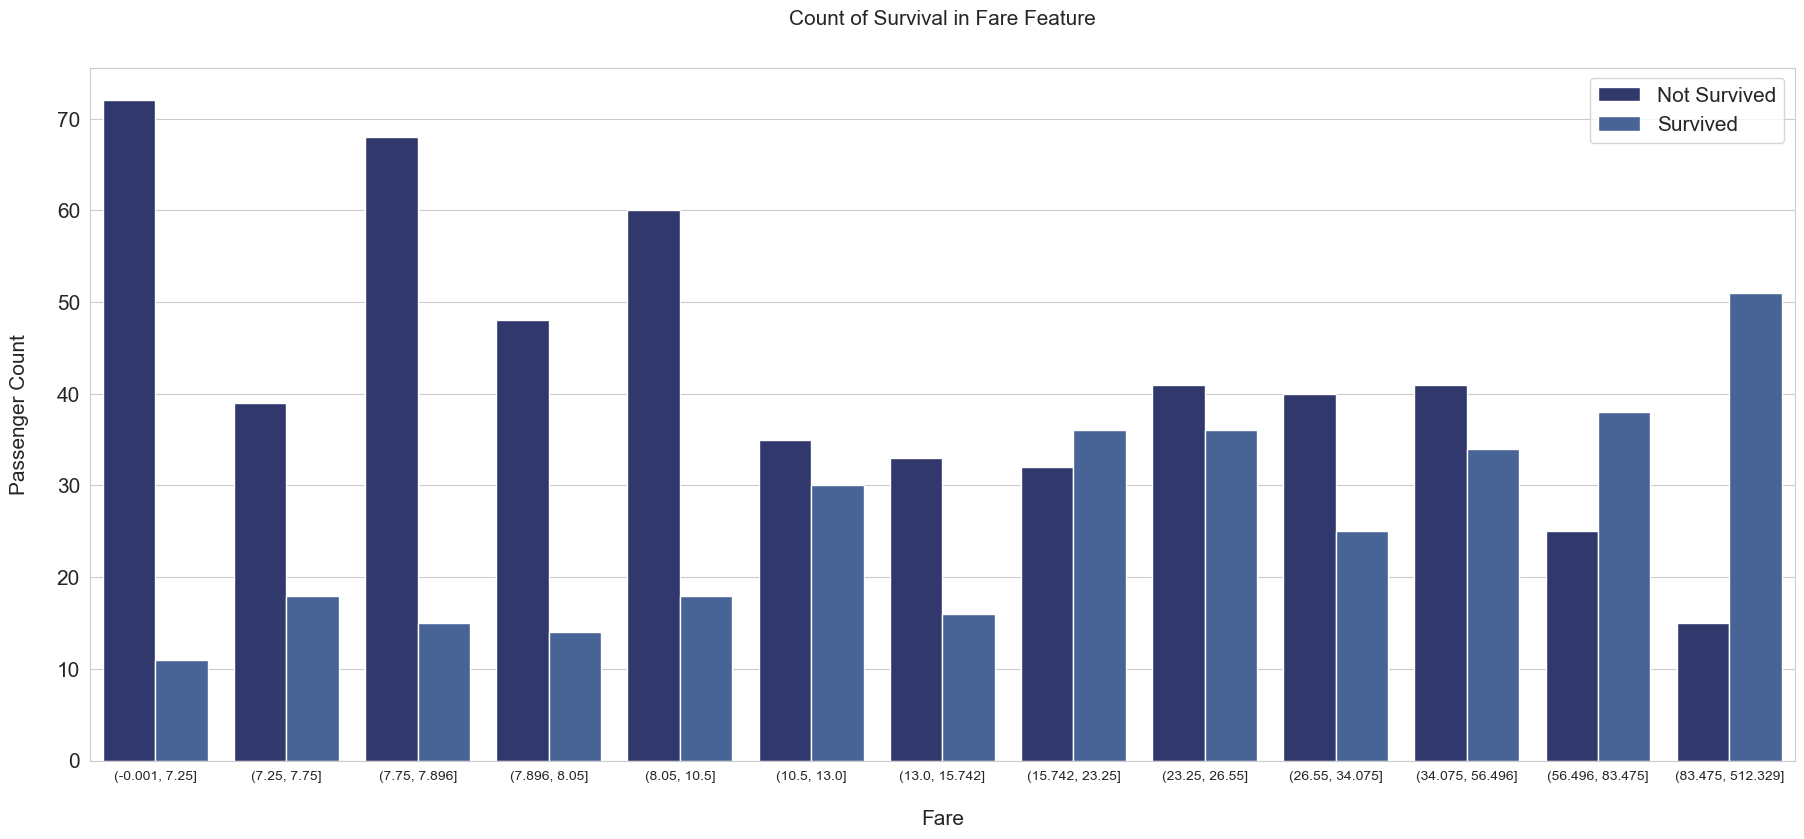

In [98]:
# Tasa de superviviencia por número de bins considerado
bins = 13
combined_df['fareband'] = pd.qcut(combined_df['fare'], bins)

fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='fareband', hue='survived', data=combined_df, palette=palette)

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Fare'), size=15, y=1.05)

plt.show()

**Edad**

In [99]:
# Tasa de superviviencia por bins (age)
for bins in [4, 6, 8, 10, 13, 15]:
    combined_df['ageband'] = pd.qcut(combined_df['age'], bins, duplicates='drop')
    print(f"\nBins: {bins}")
    print(combined_df[['ageband', 'survived']].groupby(['ageband'], observed=False).mean())


Bins: 4
               survived
ageband                
(0.169, 22.0]  0.450549
(22.0, 26.0]   0.225275
(26.0, 36.0]   0.459091
(36.0, 80.0]   0.356481

Bins: 6
               survived
ageband                
(0.169, 19.0]  0.481707
(19.0, 24.0]   0.412903
(24.0, 26.0]   0.154412
(26.0, 32.0]   0.413043
(32.0, 42.0]   0.437870
(42.0, 80.0]   0.364341

Bins: 8
               survived
ageband                
(0.169, 18.0]  0.503597
(18.0, 22.0]   0.395522
(22.0, 25.0]   0.213415
(25.0, 26.0]   0.333333
(26.0, 30.0]   0.396040
(30.0, 36.0]   0.512605
(36.0, 45.0]   0.345133
(45.0, 80.0]   0.368932

Bins: 10
               survived
ageband                
(0.169, 16.0]  0.550000
(16.0, 21.0]   0.307692
(21.0, 22.0]   0.521739
(22.0, 25.0]   0.213415
(25.0, 26.0]   0.333333
(26.0, 29.5]   0.394737
(29.5, 34.0]   0.425532
(34.0, 40.0]   0.505263
(40.0, 48.0]   0.318681
(48.0, 80.0]   0.387500

Bins: 13
               survived
ageband                
(0.169, 14.0]  0.584416
(14.0, 19.0]   0.

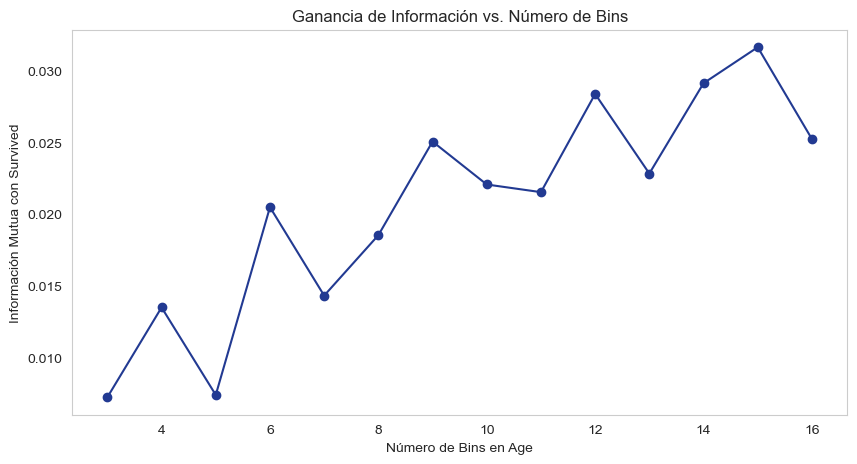

In [100]:
# Graficar la información mutua vs. número de bins
bin_counts = list(range(3, 17))  
mi_scores = []  

for bins in bin_counts:
    combined_df['ageband'] = pd.qcut(combined_df['age'], bins, duplicates='drop')  # Evitar duplicados
    mi = mutual_info_score(combined_df['ageband'].astype(str), combined_df['survived'].astype(str))  # Convertir a str
    mi_scores.append(mi)

plt.figure(figsize=(10, 5))
plt.plot(bin_counts, mi_scores, marker='o', linestyle='-', color='#223A92')
plt.xlabel("Número de Bins en Age")
plt.ylabel("Información Mutua con Survived")
plt.title("Ganancia de Información vs. Número de Bins")
plt.grid()
plt.show()

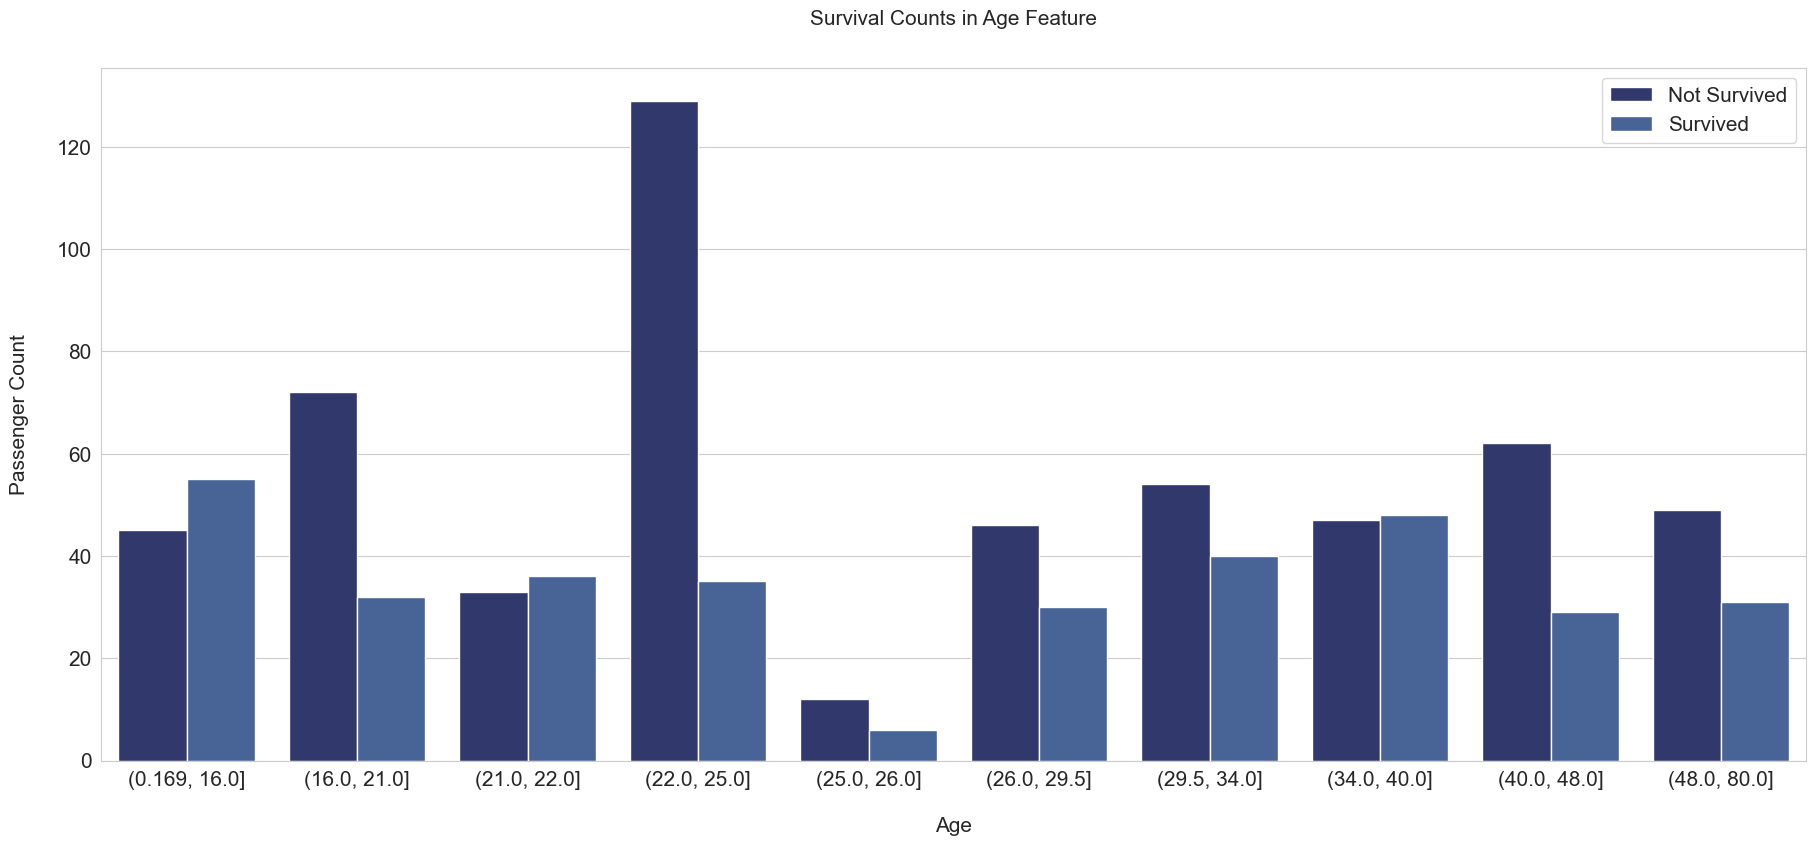

In [101]:
# Tasa de supervivencia por bins considerados
bins = 10 
combined_df['ageband'] = pd.qcut(combined_df['age'], bins)

fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='ageband', hue='survived', data=combined_df, palette=palette)

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Survival Counts in {} Feature'.format('Age'), size=15, y=1.05)

plt.show()

In [102]:
# Respaldo DataFrame (post-creación de características)
combined_df_features=combined_df.copy()

In [103]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   age                      1309 non-null   float64 
 1   cabin                    295 non-null    object  
 2   embarked                 1309 non-null   object  
 3   fare                     1309 non-null   float64 
 4   name                     1309 non-null   object  
 5   parch                    1309 non-null   int64   
 6   passengerid              1309 non-null   int64   
 7   pclass                   1309 non-null   int64   
 8   sex                      1309 non-null   object  
 9   sibsp                    1309 non-null   int64   
 10  survived                 891 non-null    float64 
 11  ticket                   1309 non-null   object  
 12  set                      1309 non-null   object  
 13  deck                     1309 non-null   object  
 14  dataset 

**Análisis de Variables**

| **Conservar**             | **Eliminar**             | **Revisar**                   |
|---------------------------|--------------------------|-------------------------------|
| pclass                    | name                     | deck                          |
| sex                       | ticket                   | cabin                         |
| age                       | passengerid              | namelength                    |
| fare                      | set                      | namelengthband                |
| sibsp                     | dataset                  | age*classband                 |
| parch                     | family                   | fare_outlier                  |
| embarked                  | survival_rate            | age_outlier                   |
| title                     | family_survival_rate     | fareperclassband              |
| married                   | ticket_survival_rate     | family_size_grouped           |
| family_size               |                          |                               |
| ticket_frequency          |                          |                               |
| family_survival_rate_na   |                          |                               |
| ticket_survival_rate_na   |                          |                               |
| survival_rate_na          |                          |                               |
| hascabin                  |                          |                               |
| fareband                  |                          |                               |
| ageband                   |                          |                               |
| fareperclass              |                          |                               |
| age*class                 |                          |                               |




In [104]:
# Variables a eliminar 
drop_features= [ 'name', 'ticket', 'family', 'namelength', 'age', 'cabin', 'fare', 'age*class', 'fareperclass']

# variables a perservar
preserve_features = list(set(combined_df.columns) - set(drop_features))
print(f"Variables percervadas {len(preserve_features)}:", preserve_features)

Variables percervadas 29: ['survival_rate_na', 'namelengthband', 'family_size_grouped', 'fareperclassband', 'fare_outlier', 'married', 'hascabin', 'age*classband', 'ticket_frequency', 'deck', 'passengerid', 'family_survival_rate', 'age_outlier', 'family_survival_rate_na', 'set', 'parch', 'survived', 'ticket_survival_rate', 'pclass', 'embarked', 'ticket_survival_rate_na', 'family_size', 'sibsp', 'dataset', 'ageband', 'survival_rate', 'fareband', 'sex', 'title']


In [105]:
# DataFrame limpio
combined_df= combined_df[preserve_features]

In [106]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   survival_rate_na         1309 non-null   float64 
 1   namelengthband           1309 non-null   category
 2   family_size_grouped      1309 non-null   object  
 3   fareperclassband         1309 non-null   category
 4   fare_outlier             1309 non-null   int32   
 5   married                  1309 non-null   int64   
 6   hascabin                 1309 non-null   int32   
 7   age*classband            1309 non-null   category
 8   ticket_frequency         1309 non-null   int64   
 9   deck                     1309 non-null   object  
 10  passengerid              1309 non-null   int64   
 11  family_survival_rate     1309 non-null   float64 
 12  age_outlier              1309 non-null   int32   
 13  family_survival_rate_na  1309 non-null   int64   
 14  set     

### Selección de características Relevantes

**Variables Numéricas**

In [107]:
# Filtrar conjunto de entrenamiento
train_df = combined_df[combined_df['set'] == 'Train']

# Selección variables numéricas
numeric_features = train_df.select_dtypes(include=['int64', 'float64']).columns
display(f"Variables numéricas {len(numeric_features)}:",numeric_features)

'Variables numéricas 14:'

Index(['survival_rate_na', 'married', 'ticket_frequency', 'passengerid',
       'family_survival_rate', 'family_survival_rate_na', 'parch', 'survived',
       'ticket_survival_rate', 'pclass', 'ticket_survival_rate_na',
       'family_size', 'sibsp', 'survival_rate'],
      dtype='object')

In [108]:
# Eliminación características no numéricas
no_numeric_features=['passengerid', 'pclass', 'married']

# Variables numéricas
numeric_features = list(set(numeric_features) - set(no_numeric_features))
display(f"Total variables numéricas {len(numeric_features)}:",numeric_features)

'Total variables numéricas 11:'

['survival_rate_na',
 'sibsp',
 'parch',
 'survived',
 'ticket_frequency',
 'ticket_survival_rate',
 'survival_rate',
 'family_survival_rate',
 'ticket_survival_rate_na',
 'family_survival_rate_na',
 'family_size']

In [109]:
# Correlación con survived
correlation_with_target = train_df[numeric_features].corrwith(train_df['survived']).abs().sort_values(ascending=False)
significant_numeric_features = correlation_with_target[correlation_with_target > 0.1].index.tolist()

# Matriz de correlación entre variables predictoras
correlation_matrix = train_df[significant_numeric_features].corr().abs()

# Identificación y eliminación variables redundantes (alta multicolinealidad)
threshold = 0.8
high_correlation_pairs = (correlation_matrix > threshold) & (correlation_matrix < 1.0)
variables_to_drop = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if high_correlation_pairs.iloc[i, j]:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            
            if correlation_with_target[colname_i] > correlation_with_target[colname_j]:
                variables_to_drop.add(colname_j)
            else:
                variables_to_drop.add(colname_i)

# Eliminación variables redundantes
significant_numeric_features = [col for col in significant_numeric_features if col not in variables_to_drop]

display(f"Variables numéricas seleccionadas {len(significant_numeric_features)}:", significant_numeric_features)

'Variables numéricas seleccionadas 3:'

['survived', 'survival_rate', 'ticket_survival_rate_na']

In [110]:
# Variables numéricas no seleccionadas
non_selected_numeric_features = [col for col in numeric_features if col not in significant_numeric_features]
display(f"Variables numéricas NO seleccionadas {len(non_selected_numeric_features)}:",non_selected_numeric_features)

'Variables numéricas NO seleccionadas 8:'

['survival_rate_na',
 'sibsp',
 'parch',
 'ticket_frequency',
 'ticket_survival_rate',
 'family_survival_rate',
 'family_survival_rate_na',
 'family_size']

**Variables Categóricas** 

In [111]:
# Selección variables categóricas
categorical_features = train_df.select_dtypes(include=['category', 'int32', 'object']).columns
display(f"Variables seleccionadas {len(categorical_features)}:",categorical_features)

'Variables seleccionadas 15:'

Index(['namelengthband', 'family_size_grouped', 'fareperclassband',
       'fare_outlier', 'hascabin', 'age*classband', 'deck', 'age_outlier',
       'set', 'embarked', 'dataset', 'ageband', 'fareband', 'sex', 'title'],
      dtype='object')

In [112]:
# Total características categoricas
categorical_features = list(set(categorical_features) | set(no_numeric_features))

# Eliminación características sin interés
drop_categorical_features=['set', 'dataset', 'passengerid']
categorical_features = list(set(categorical_features) - set(drop_categorical_features))

# Características categóricas
display(f"Total variables categóricas {len(categorical_features)}:",categorical_features)

'Total variables categóricas 15:'

['namelengthband',
 'pclass',
 'family_size_grouped',
 'embarked',
 'fareperclassband',
 'fare_outlier',
 'married',
 'hascabin',
 'ageband',
 'age*classband',
 'deck',
 'fareband',
 'sex',
 'title',
 'age_outlier']

In [113]:
# Prueba de chi-cuadrado
chi2_scores, _ = chi2(train_df[categorical_features].apply(LabelEncoder().fit_transform), train_df['survived'])
chi2_results = pd.Series(chi2_scores, index=categorical_features)
significant_categorical_features = chi2_results[chi2_results > 0.05].index.tolist()
display(f"Variables Categóricas seleccionadas {len(significant_categorical_features)}:",significant_categorical_features)

'Variables Categóricas seleccionadas 15:'

['namelengthband',
 'pclass',
 'family_size_grouped',
 'embarked',
 'fareperclassband',
 'fare_outlier',
 'married',
 'hascabin',
 'ageband',
 'age*classband',
 'deck',
 'fareband',
 'sex',
 'title',
 'age_outlier']

In [114]:
# Selección características significantes (categíricas-numéricas)
selected_features = significant_numeric_features + significant_categorical_features
display(f"Total variables seleccionadas(numéricas + categóricas) {len(selected_features)}:", selected_features)

'Total variables seleccionadas(numéricas + categóricas) 18:'

['survived',
 'survival_rate',
 'ticket_survival_rate_na',
 'namelengthband',
 'pclass',
 'family_size_grouped',
 'embarked',
 'fareperclassband',
 'fare_outlier',
 'married',
 'hascabin',
 'ageband',
 'age*classband',
 'deck',
 'fareband',
 'sex',
 'title',
 'age_outlier']

In [115]:
# Variables no seleccionadas 
unselected_features = list(set(combined_df.columns) - set(selected_features)) 

# Variables a eliminadr
print(f"Variables a eliminar {len(unselected_features)}:", unselected_features)


Variables a eliminar 11: ['survival_rate_na', 'sibsp', 'dataset', 'parch', 'ticket_frequency', 'ticket_survival_rate', 'passengerid', 'family_survival_rate', 'family_size', 'family_survival_rate_na', 'set']


Las variables `passengerid` y `set` no debe eliminarse en combined_df

In [116]:
# Variables a eliminar 
features= ['survival_rate_na', 'sibsp', 'family_size', 'family_survival_rate_na', 'ticket_survival_rate', 'family_survival_rate', 'ticket_frequency', 'dataset', 'parch']

# Variables seleccionadas
excluded_features = list(set(combined_df.columns) - set(features))
print(f"Variables seleccionadas {len(excluded_features)}:", excluded_features)

Variables seleccionadas 20: ['namelengthband', 'family_size_grouped', 'fareperclassband', 'fare_outlier', 'married', 'hascabin', 'age*classband', 'deck', 'passengerid', 'age_outlier', 'set', 'survived', 'pclass', 'embarked', 'ticket_survival_rate_na', 'ageband', 'survival_rate', 'fareband', 'sex', 'title']


In [117]:
# DataFrame con características relevantes
combined_df = combined_df[excluded_features]

In [118]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   namelengthband           1309 non-null   category
 1   family_size_grouped      1309 non-null   object  
 2   fareperclassband         1309 non-null   category
 3   fare_outlier             1309 non-null   int32   
 4   married                  1309 non-null   int64   
 5   hascabin                 1309 non-null   int32   
 6   age*classband            1309 non-null   category
 7   deck                     1309 non-null   object  
 8   passengerid              1309 non-null   int64   
 9   age_outlier              1309 non-null   int32   
 10  set                      1309 non-null   object  
 11  survived                 891 non-null    float64 
 12  pclass                   1309 non-null   int64   
 13  embarked                 1309 non-null   object  
 14  ticket_s

In [119]:
# Renombrar columnas
combined_df = combined_df.rename(columns={
    'fareband': 'fare',
    'namelengthband': 'namelength',
    'ageband': 'age',
    'age*classband': 'age*class',
    'fareperclassband': 'fareperclass'
    
})

In [120]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   namelength               1309 non-null   category
 1   family_size_grouped      1309 non-null   object  
 2   fareperclass             1309 non-null   category
 3   fare_outlier             1309 non-null   int32   
 4   married                  1309 non-null   int64   
 5   hascabin                 1309 non-null   int32   
 6   age*class                1309 non-null   category
 7   deck                     1309 non-null   object  
 8   passengerid              1309 non-null   int64   
 9   age_outlier              1309 non-null   int32   
 10  set                      1309 non-null   object  
 11  survived                 891 non-null    float64 
 12  pclass                   1309 non-null   int64   
 13  embarked                 1309 non-null   object  
 14  ticket_s

**Transformación de características**

In [121]:
# Variables categóricas (nominales)
nominal_features = ['sex', 'deck']

# Inicialización LabelEncoder
encoder = LabelEncoder()

for col in nominal_features:
    combined_df[col] = encoder.fit_transform(combined_df[col])


In [122]:
# Variables categóricas (ordinales)
ordinal_features = ['fareperclass', 'age', 'fare', 'namelength', 'pclass', 'age*class', 'family_size_grouped']

# Inicialización OrdinalEncoder
encoder = OrdinalEncoder()

combined_df[ordinal_features] = encoder.fit_transform(combined_df[ordinal_features])

In [123]:
# Variables no numéricas
no_numerical_features = ['embarked', 'title']
encoded_features = []  

# Inicialización OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')  # Evita colinealidad y errores por valores desconocidos

#OneHotEncoder combined_df
for feature in no_numerical_features :
    encoded_feat = encoder.fit_transform(combined_df[[feature]])  
    n = combined_df[feature].nunique()  

    # Crear nombres de columnas
    cols = ['{}_{}'.format(feature, i) for i in range(1, n)]  # Se usa `range(1, n)` si `drop='first'` está activado

    # Convertir a DataFrame
    encoded_df = pd.DataFrame(encoded_feat, columns=cols, index=combined_df.index)
    
    # Guardar nuevas columnas codificadas
    encoded_features.append(encoded_df)

# Concatenar columnas codificadas con `combined_df`
combined_df = pd.concat([combined_df, *encoded_features], axis=1)

# Eliminar  columnas originales categóricas
combined_df.drop(columns=no_numerical_features , inplace=True)

In [124]:
# Variables numéricas
numeric_features = ['survival_rate']

# Inicialización StandardScaler
scaler = StandardScaler()
combined_df[numeric_features] = scaler.fit_transform(combined_df[numeric_features])

**Train Set / Test Set**

In [125]:
# Función para dividir el DataFrame combinado en los conjuntos de entrenamiento y prueba originales
def divide_df(all_data):
    """Divide el DataFrame combinado en los conjuntos de entrenamiento y prueba."""
    train_data = all_data.loc[:890].copy()  # Las primeras 891 filas corresponden al conjunto de entrenamiento
    test_data = all_data.loc[891:].drop('survived', axis=1).copy()  # El resto son el conjunto de prueba
    return train_data, test_data

# Separar nuevamente en Train y Test con la función divide_df()
df_train_cut, df_test_cut = divide_df(combined_df)

# Eliminar que columnas de separacion y comparacion
df_train_cut = df_train_cut.drop(['set', 'dataset'], axis=1, errors='ignore')
df_test_cut = df_test_cut.drop(['set', 'dataset'], axis=1, errors='ignore')

# Verificación de la carga y combinación de datos
print(f"Training Set - Filas: {df_train_cut.shape[0]}, Columnas: {df_train_cut.shape[1]}")
print(f"Test Set - Filas: {df_test_cut.shape[0]}, Columnas: {df_test_cut.shape[1]}")
print(f"combined_df - Filas: {combined_df.shape[0]}, Columnas: {combined_df.shape[1]}")

Training Set - Filas: 891, Columnas: 22
Test Set - Filas: 418, Columnas: 21
combined_df - Filas: 1309, Columnas: 23


In [126]:
# Renombrar datasets
x_train = df_train_cut.drop(['survived', 'passengerid'], axis=1, errors='ignore')
y_train = df_train_cut['survived']
x_test  = df_test_cut.drop(['passengerid', 'set', 'dataset'], axis=1, errors='ignore').copy()
print('x_train shape: {}'.format(x_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('x_test shape: {}'.format(x_test.shape))

x_train shape: (891, 20)
y_train shape: (891,)
x_test shape: (418, 20)


**Modelación**

**Modelo Baseline**

Baseline Accuracy -Regla de Género: 0.7868


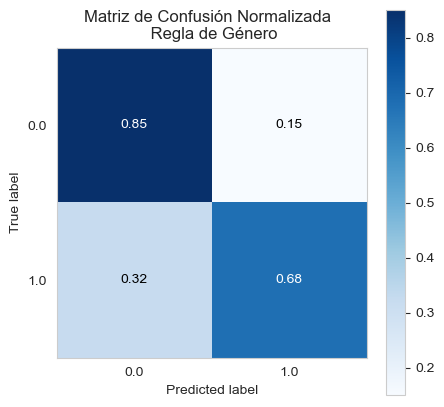

In [127]:
# Modelbaseline- regla de género
y_pred_baseline = (x_train["sex"] == 0).astype(int)  # Predicción manual
baseline_accuracy = accuracy_score(y_train, y_pred_baseline)
print(f"Baseline Accuracy {'-Regla de Género'}: {baseline_accuracy:.4f}")

skplt.metrics.plot_confusion_matrix(y_train, y_pred_baseline, normalize=True, figsize=(5,5))
plt.title(f"Matriz de Confusión Normalizada  \n {'Regla de Género'}")
plt.show()

# Regla: "Las mujeres y los niños menores de 10 años sobreviven"
#y_pred_baseline = ((X_train["sex"] == 0) | (train["Age"] < 10)).astype(int)  # Predicción manual
#baseline_accuracy = accuracy_score(Y_train, y_pred_baseline)
#print(f"Baseline Accuracy {'-Mujeres y Niños'}: {baseline_accuracy:.4f}")
#skplt.metrics.plot_confusion_matrix(Y_train, y_pred_baseline, normalize=True, figsize=(5,5))
#plt.title(f"Matriz de Confusión Normalizada  \n {'Mujeres y Niños'}")
#plt.show()


**Clasificadores**

In [128]:
# Modelos (clasificadores):
classifiers = [
    SVC(probability=True),
    DecisionTreeClassifier(),
    AdaBoostClassifier(),
    RandomForestClassifier(),
    ExtraTreesClassifier(),
    GradientBoostingClassifier(),
    MLPClassifier(),
    KNeighborsClassifier(),
    LogisticRegression(),
    LinearDiscriminantAnalysis(),
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
]

# Validación cruzada (KFold)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

# Selección por rendimiento
selected_models = []
results = []

for clf in classifiers:
    name = clf.__class__.__name__
    scores = cross_val_score(clf, x_train, y=y_train, cv=kfold, scoring='accuracy')
    mean_score = scores.mean()
    std_score = scores.std()

    if mean_score >= baseline_accuracy:
        print(f"Entrenando {name}...")
        clf.fit(x_train, y_train)  
        selected_models.append((name, clf))
        results.append({
            "Model": name,
            "Mean Accuracy": mean_score,
            "Std Accuracy": std_score
        })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Mean Accuracy", ascending=False)
        
print(f'Modelos Evaluados: {len(classifiers)}')
print(f'Modelos con Desempeño mayor al Modelo Baseline: {len(selected_models)}')
display(results_df)

Entrenando SVC...
Entrenando DecisionTreeClassifier...
Entrenando AdaBoostClassifier...
Entrenando RandomForestClassifier...
Entrenando ExtraTreesClassifier...
Entrenando GradientBoostingClassifier...
Entrenando MLPClassifier...
Entrenando KNeighborsClassifier...
Entrenando LogisticRegression...
Entrenando LinearDiscriminantAnalysis...
Entrenando XGBClassifier...
Modelos Evaluados: 11
Modelos con Desempeño mayor al Modelo Baseline: 11


Model  Mean Accuracy  Std Accuracy
6                MLPClassifier       0.883278      0.010883
3       RandomForestClassifier       0.878796      0.016826
2           AdaBoostClassifier       0.877679      0.022782
5   GradientBoostingClassifier       0.876561      0.016887
8           LogisticRegression       0.872061      0.014756
9   LinearDiscriminantAnalysis       0.872054      0.016809
10               XGBClassifier       0.867579      0.021396
4         ExtraTreesClassifier       0.864189      0.012081
0                          SVC       0.854115      0.022619
1       DecisionTreeClassifier       0.830544      0.023808
7         KNeighborsClassifier       0.830507      0.020378

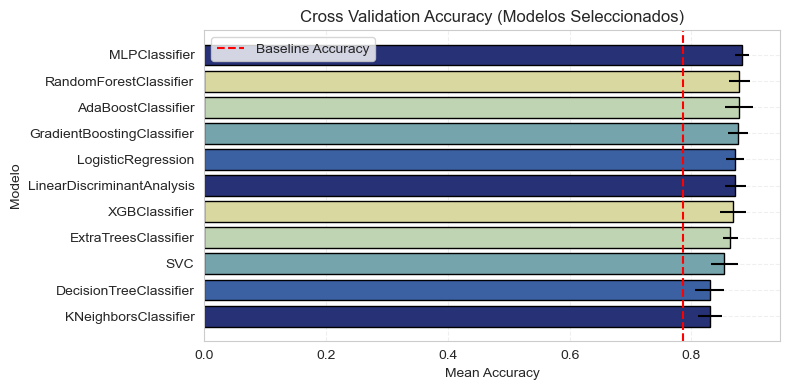

In [129]:
# Ordenamietno - accuracy 
results_df = results_df.sort_values(by="Mean Accuracy", ascending=True)

# Variables
models = results_df["Model"]
mean_acc = results_df["Mean Accuracy"]
std_acc = results_df["Std Accuracy"]

# Gráfico
plt.figure(figsize=(8, 4))
plt.barh(models, mean_acc, xerr=std_acc, color=palette, edgecolor="black")
plt.axvline(x=baseline_accuracy, color="red", linestyle="--", label="Baseline Accuracy")
plt.title("Cross Validation Accuracy (Modelos Seleccionados)")
plt.xlabel("Mean Accuracy")
plt.ylabel("Modelo")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


**Ajuste de hiperparámetros**

Modelos seleccionados:  
- ExtraTreesClassifier
- RandomForestClassifier
- LinearDiscriminantAnalysis
- LogisticRegression
- GradientBoostingClassifier
- AdaBoostClassifier
- MLPClassifier

In [130]:
# Modelos y rango de hiperparámetos (GridSearch)
models_and_parameters = {
    "ExtraTrees": {
        "model": ExtraTreesClassifier(random_state=42),
        "params": {
            "n_estimators": [200, 300, 500],
            "max_depth": [None, 10, 20],
            "min_samples_split": [5, 10, 15],
            "min_samples_leaf": [2, 4, 6],
            "max_features": ["sqrt", "log2"]
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [200, 300, 500],
            "max_depth": [6, 8, 10],
            "min_samples_split": [5, 10, 15],
            "min_samples_leaf": [2, 4, 6],
            "max_features": ["sqrt"]
        }
    },
    "GradientBoosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "n_estimators": [200, 300, 400],
            "learning_rate": [0.01, 0.03, 0.05],
            "max_depth": [2],  # regularización fuerte
            "min_samples_leaf": [4, 6, 8],
            "subsample": [0.6, 0.7, 0.8]
        }
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "params": {
            "n_estimators": [200, 400, 600],
            "learning_rate": [0.01, 0.05, 0.1]
        }
    },
    "MLP": {
        "model": MLPClassifier(random_state=42, max_iter=1000, early_stopping=True),
        "params": {
            "hidden_layer_sizes": [(100,), (100, 50), (150, 75), (128,)],
            "activation": ['relu', 'tanh'],
            "alpha": [0.0001, 0.001, 0.01, 0.1],
            "solver": ['adam', 'lbfgs']
        }
    },
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=1000, random_state=42),
        "params": {
            "C": [0.01, 0.1, 1.0, 10, 100],
            "solver": ['liblinear', 'lbfgs'],
            "penalty": ['l2']
        }
    },
    "LDA": {
        "model": LinearDiscriminantAnalysis(),
        "params": {
            "solver": ['svd', 'lsqr', 'eigen'],
            "shrinkage": [None, 'auto']
        }
    }
}

In [131]:
# Validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Resultados
best_models_dict = {}
results = []

# RandomizedSearchCV
for name, mp in models_and_parameters.items():
    print(f"Ajuste de hiperparámetros: {name}...")
    
    search = RandomizedSearchCV(
        estimator=mp["model"],
        param_distributions=mp["params"],
        cv=cv,
        scoring="accuracy",
        n_iter=20,  #  Ajuste -tiempo/complejidad
        random_state=42,
        n_jobs=-1
    )
    
    search.fit(x_train, y_train)  
    best_models_dict[name] = search.best_estimator_
    results.append({
        "Model": name,
        "Best Score": search.best_score_,
        "Best Params": search.best_params_
    })

# Resultados ordenados
df_results = pd.DataFrame(results).sort_values(by="Best Score", ascending=False)
display(df_results)

Ajuste de hiperparámetros: ExtraTrees...
Ajuste de hiperparámetros: RandomForest...
Ajuste de hiperparámetros: GradientBoosting...
Ajuste de hiperparámetros: AdaBoost...
Ajuste de hiperparámetros: MLP...
Ajuste de hiperparámetros: LogisticRegression...
Ajuste de hiperparámetros: LDA...


Model  Best Score  \
2    GradientBoosting    0.877691   
0          ExtraTrees    0.877660   
3            AdaBoost    0.876574   
6                 LDA    0.874321   
1        RandomForest    0.874302   
5  LogisticRegression    0.873191   
4                 MLP    0.873172   

                                         Best Params  
2  {'subsample': 0.7, 'n_estimators': 300, 'min_s...  
0  {'n_estimators': 500, 'min_samples_split': 5, ...  
3       {'n_estimators': 200, 'learning_rate': 0.01}  
6            {'solver': 'lsqr', 'shrinkage': 'auto'}  
1  {'n_estimators': 300, 'min_samples_split': 15,...  
5  {'solver': 'liblinear', 'penalty': 'l2', 'C': 10}  
4  {'solver': 'adam', 'hidden_layer_sizes': (150,...

**Curvas de Aprendizaje** 

In [132]:
# Curva de aprendizaje
def plot_learning_curve(estimator, title, X, y, ax, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Genera la curva de aprendizaje para un modelo dado y la dibuja en un subplot específico.
    """
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Ejemplos de entrenamiento")
    ax.set_ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)

    ax.grid()
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Train")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validación")
    ax.legend(loc="best")

In [133]:
# Mejores modelos entrenados
best_models_list = [
    ("ExtraTrees", best_models_dict["ExtraTrees"]),
    ("MLP", best_models_dict["MLP"]),
    ("Gradient Boosting", best_models_dict["GradientBoosting"]),
    ("Linear Discriminant", best_models_dict["LDA"]),
    ("Random Forest", best_models_dict["RandomForest"]),
    ( "AdaBoost", best_models_dict[ "AdaBoost"]),
    ("LogisticRegression", best_models_dict["LogisticRegression"])
]

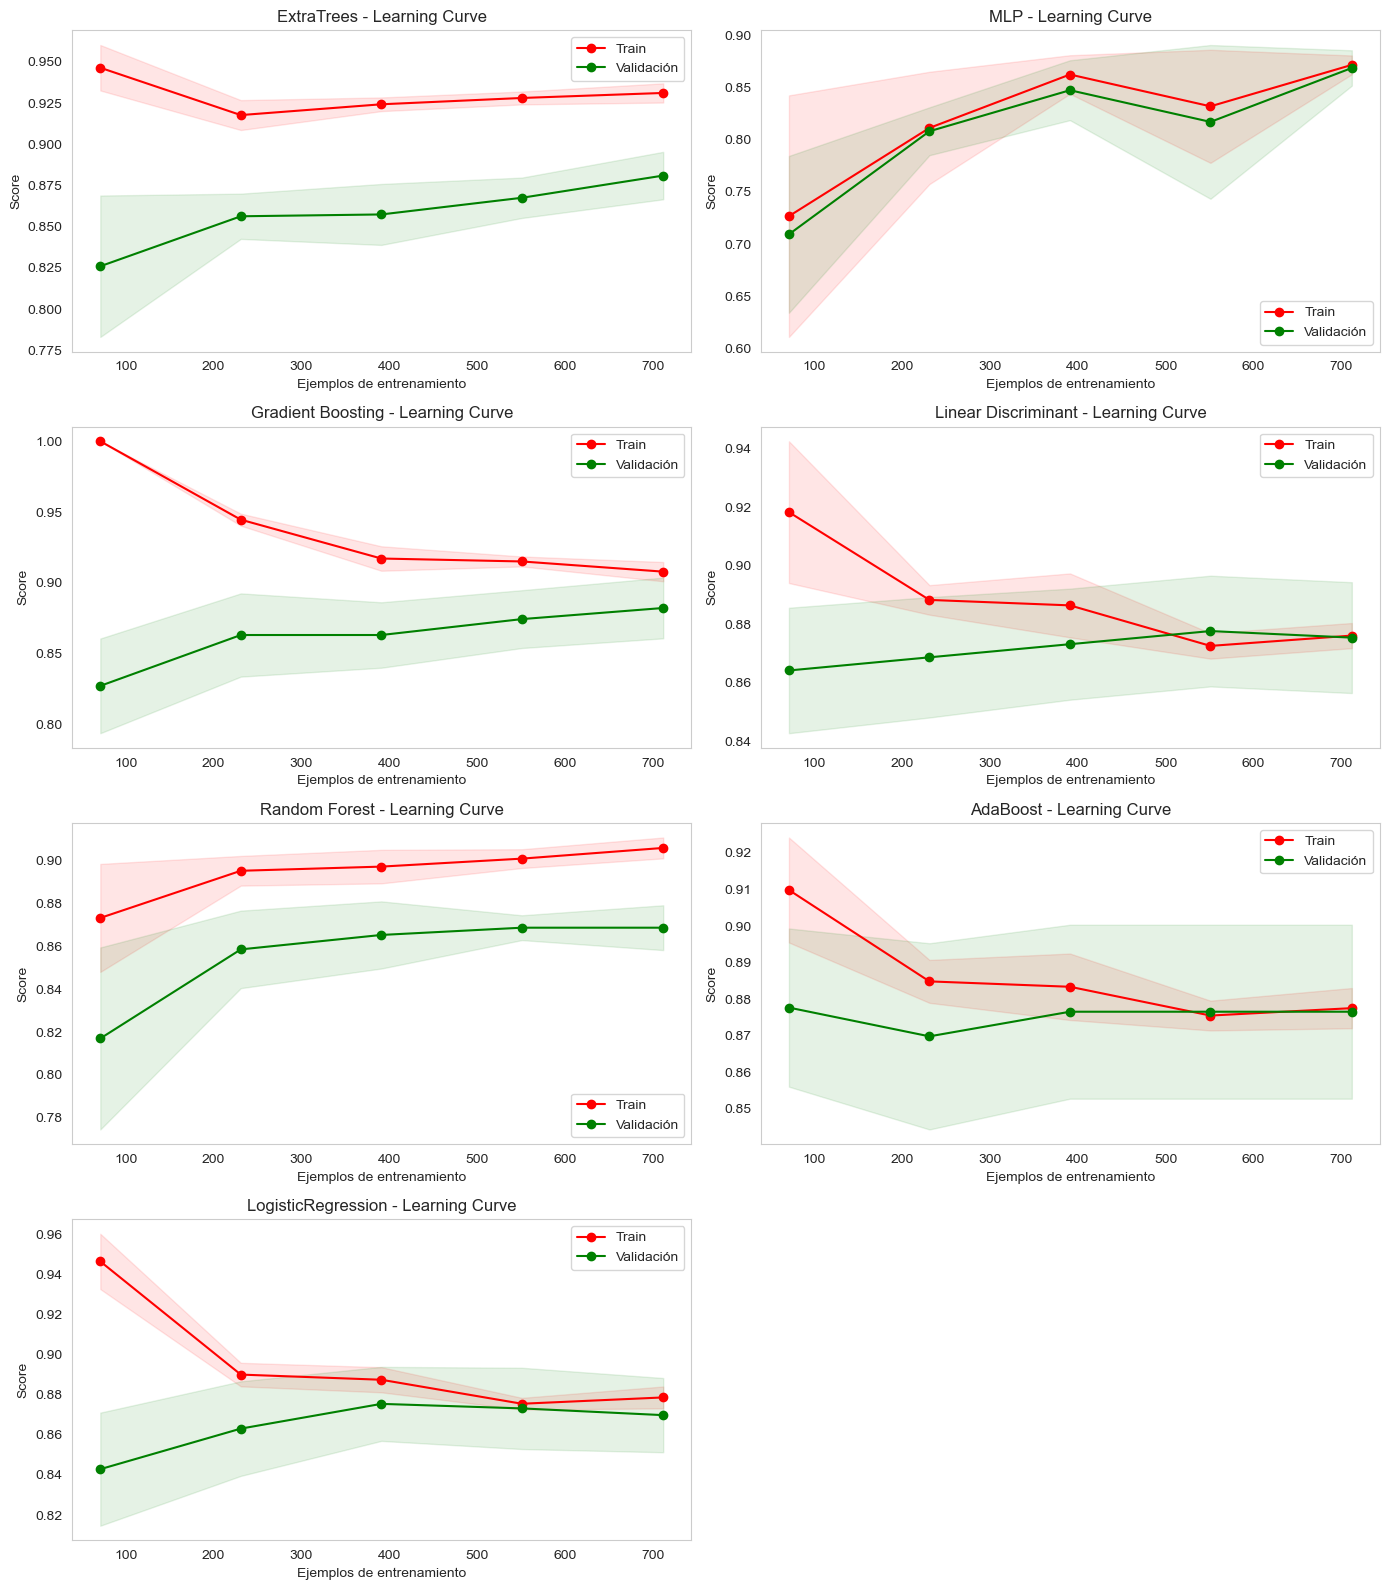

In [134]:
# Subplots
n = len(best_models_list)
ncols = 2
nrows = (n + 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, nrows * 4))
axes = axes.flatten()

# Curvas por modelo
for i, (nombre, modelo) in enumerate(best_models_list):
    plot_learning_curve(modelo, f"{nombre} - Learning Curve", x_train, y_train, ax=axes[i], cv=kfold)

# Eliminación gráficos vacíos 
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

| **Modelo**            | **Diagnóstico**   | **Acción**            |
|------------------------|--------------------|--------------------------------|
| MLPClassifier          |  Excelente        | Modelo final candidato         |
| Gradient Boosting      |  Muy sólido       | Mantener                       |
| Random Forest          |  Estable          | Mantener                       |
| Extra Trees            |  Bueno            | Opcional                       |
| AdaBoost               |  Aceptable        | Mantener si es ligero          |
| Logistic/LDA           |  Underfitting     | Mantener solo como baseline    |

**Bias-Variance** 

In [135]:
# Métricas de aprendizaje
def summarize_learning_curves(models, X, y, cv):
    from sklearn.model_selection import learning_curve

    summary = []

    for name, model in models.items():
        train_sizes, train_scores, val_scores = learning_curve(
            estimator=model,
            X=X,
            y=y,
            cv=cv,
            scoring='accuracy',
            train_sizes=np.linspace(0.1, 1.0, 5),
            n_jobs=-1
        )

        train_mean = train_scores.mean(axis=1)[-1]  # último punto (tamaño completo)
        val_mean = val_scores.mean(axis=1)[-1]
        gap = abs(train_mean - val_mean)

        summary.append({
            "Model": name,
            "Train Score": train_mean,
            "Validation Score": val_mean,
            "Overfit Gap": gap
        })

    return pd.DataFrame(summary).sort_values(by="Validation Score", ascending=False)

In [136]:
# Validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Resumen
df_summary = summarize_learning_curves(best_models_dict, x_train, y_train, cv)

# Ordenar df_summary - overfitting 
df_summary = df_summary.sort_values(by="Overfit Gap", ascending=True)
display(df_summary)

Model  Train Score  Validation Score  Overfit Gap
3            AdaBoost     0.877528          0.876574     0.000954
6                 LDA     0.876124          0.874321     0.001803
5  LogisticRegression     0.877528          0.873191     0.004337
4                 MLP     0.878652          0.872048     0.006603
1        RandomForest     0.907584          0.873178     0.034406
2    GradientBoosting     0.909551          0.869826     0.039724
0          ExtraTrees     0.932303          0.875413     0.056891

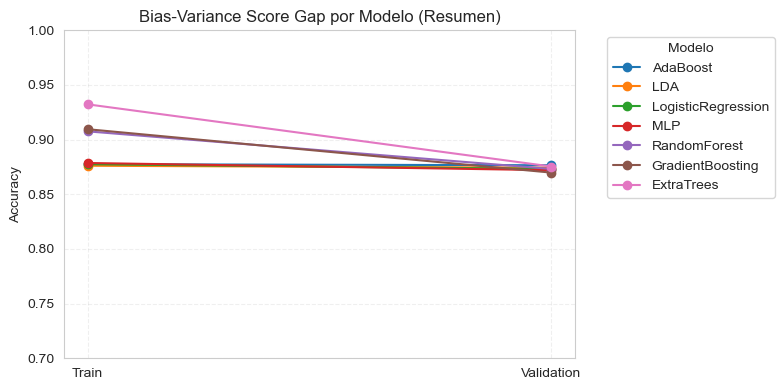

In [137]:
# Gráfico tipo bias-variance
plt.figure(figsize=(8, 4))

for i, row in df_summary.iterrows():
    plt.plot(
        [0, 1],
        [row["Train Score"], row["Validation Score"]],
        marker="o",
        label=row["Model"]
    )

plt.xticks([0, 1], ['Train', 'Validation'])
plt.ylim(0.7, 1.0)
plt.ylabel("Accuracy")
plt.title("Bias-Variance Score Gap por Modelo (Resumen)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(title="Modelo", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Importancia de Características**  

Características más relevantes globalmente

| **Característica**     | **Descripción / Motivo de relevancia**                             |
|------------------------|---------------------------------------------------------------------|
| `survival_rate`        | Tasa de supervivencia derivada (familiar o grupal), muy predictiva |
| `sex`                  | Género, uno de los factores más determinantes en el Titanic        |
| `title_*`              | Título codificado (`Mr`, `Mrs`, `Miss`, etc.), indica rol social   |
| `fare`                 | Tarifa pagada, refleja clase económica y condiciones de viaje      |
| `namelength` / `age*class` | Variables sintéticas, capturan edad relativa y longitud del nombre (proxy social) |


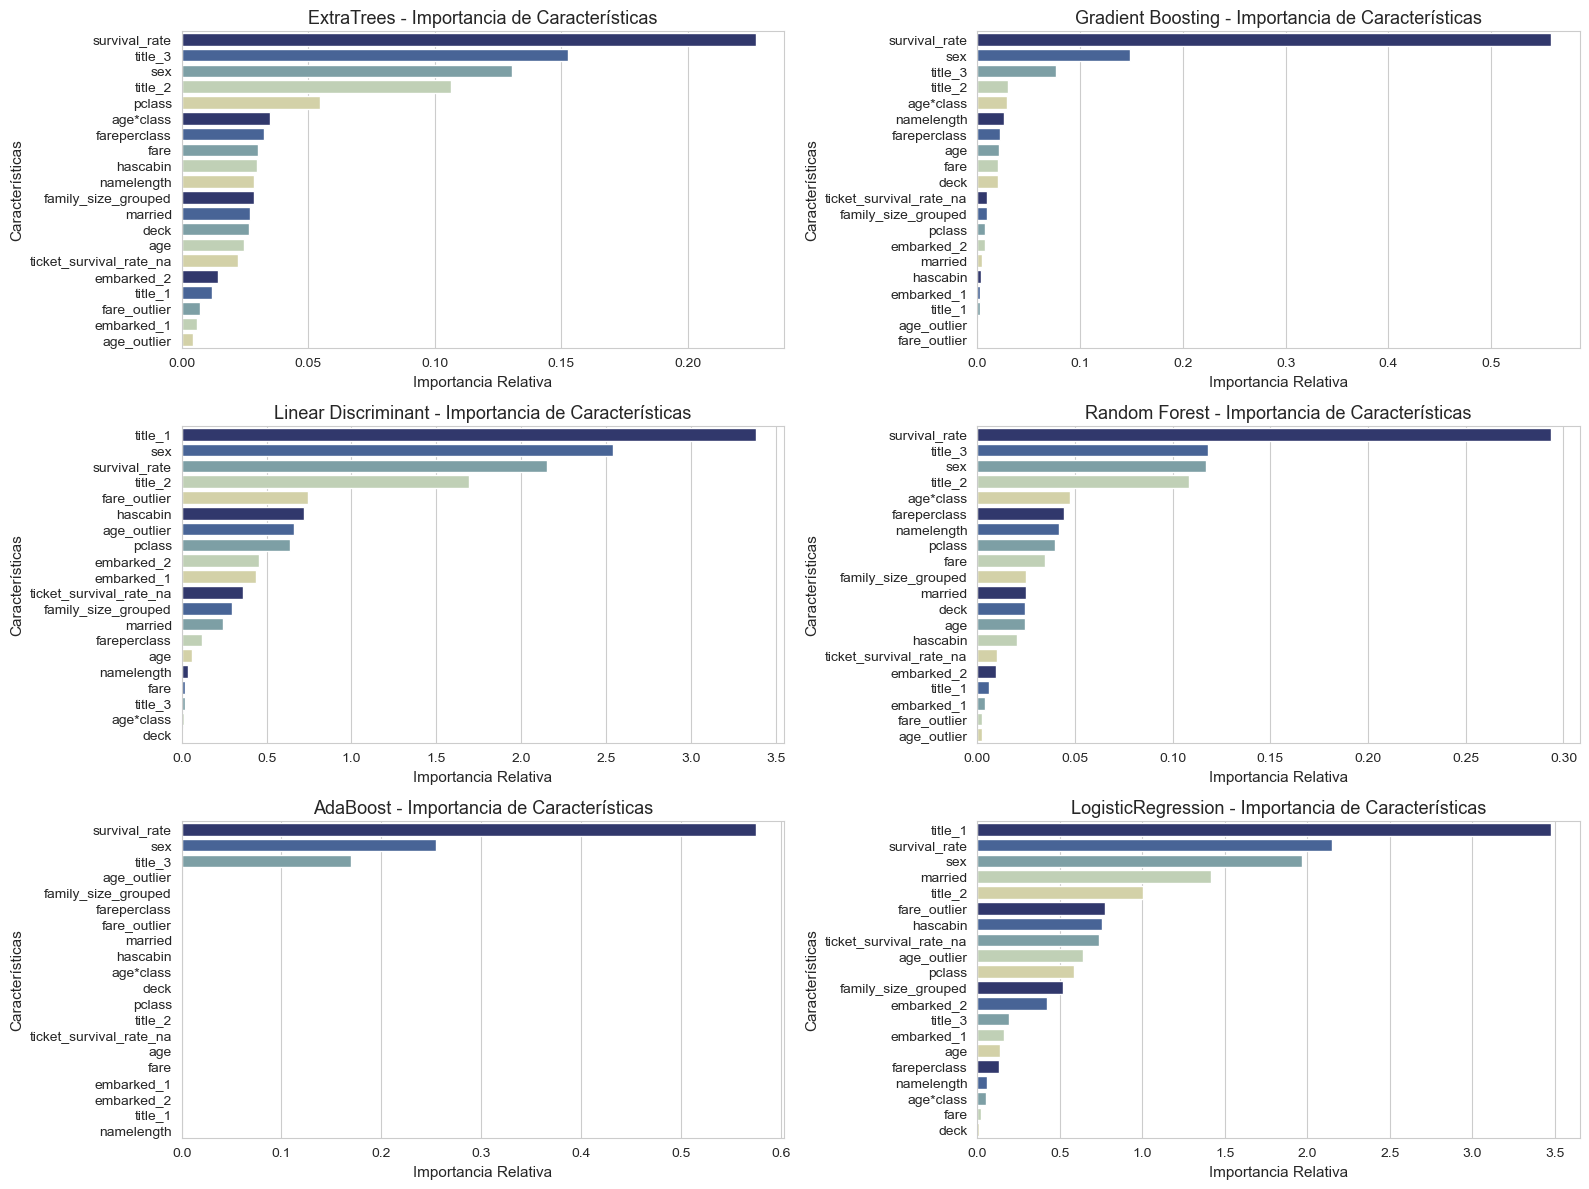

In [138]:
# Filtrar modelos con feature_importances_ o coef_
filtered_models = [
    (name, clf) for name, clf in best_models_list
    if hasattr(clf, "feature_importances_") or hasattr(clf, "coef_")
]


n_models = len(filtered_models)
ncols = 2
nrows = math.ceil(n_models / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4 * nrows))
axes = axes.flatten()


# Iteración sobre modelos
for i, (name, clf) in enumerate(filtered_models):
    ax = axes[i]

    if hasattr(clf, "feature_importances_"):
        importances = clf.feature_importances_
    elif hasattr(clf, "coef_"):
        # LDA: aplicar valor absoluto a los coeficientes
        importances = np.abs(clf.coef_[0])
    else:
        print(f"{name} no tiene información de importancia disponible.")
        continue

    # Ordenar características -importancia
    indices = np.argsort(importances)[::-1][:20]

    # Crear gráfico
    sns.barplot(
        y=x_train.columns[indices],
        x=importances[indices],
        orient='h',
        ax=ax,
        palette=palette
    )

    ax.set_title(f"{name} - Importancia de Características", fontsize=13)
    ax.set_xlabel("Importancia Relativa", fontsize=11)
    ax.set_ylabel("Características", fontsize=11)
    ax.tick_params(labelsize=10)

# Mostrar gráfico
plt.tight_layout()
plt.show()


 **Top características** 

In [139]:
# Características más importantes
def aggregate_feature_importance(model_list, X, top_n=5):
    feature_scores = pd.DataFrame(index=X.columns)

    for name, model in model_list:
        if hasattr(model, "feature_importances_"):
            feature_scores[name] = model.feature_importances_
        elif hasattr(model, "coef_"):
            feature_scores[name] = np.abs(model.coef_[0])
        else:
            print(f" {name} no tiene información de importancia disponible.")
            continue

    feature_scores["Mean"] = feature_scores.mean(axis=1)
    top_features = feature_scores.sort_values(by="Mean", ascending=False).head(top_n)

    return top_features

In [140]:
# Características más importantes
top_features = aggregate_feature_importance(best_models_list, x_train, top_n=5)
display(top_features)

 MLP no tiene información de importancia disponible.


ExtraTrees  Gradient Boosting  Linear Discriminant  \
title_1          0.011882           0.002248             3.380062   
survival_rate    0.226766           0.558541             2.152786   
sex              0.130556           0.148667             2.539056   
title_2          0.106458           0.029648             1.690079   
married          0.026939           0.004910             0.246144   

               Random Forest  AdaBoost  LogisticRegression      Mean  
title_1             0.006230     0.000            3.478725  1.146525  
survival_rate       0.293761     0.575            2.151256  0.993018  
sex                 0.117040     0.255            1.969838  0.860026  
title_2             0.108473     0.000            1.001548  0.489368  
married             0.025016     0.000            1.419448  0.287076

| Variable       | Aparece en gráficos | Aparece en tabla agregada | Comentario                     |
|----------------|---------------------|----------------------------|--------------------------------|
| `survival_rate`|  Sí               |  Sí                      | Extremadamente relevante       |
| `sex`          |  Sí               |  Sí                      | Relevante en todos los modelos |
| `title_1`      |  Sí               |  Sí                      | Fuerte en LDA/LogReg           |
| `title_2`      |  Sí               |  Sí                      | Moderadamente relevante        |
| `title_3`      |  Sí               |  Sí                      | Alta importancia en varios     |


In [141]:
# Características seleccionadas (por importancia en varios modelos)
selected_features = ['survival_rate', 'sex', 'title_1', 'title_2', 'title_3']

# Filtrar conjuntos
x_train = x_train[selected_features]
x_test = x_test[selected_features]

# Verificar dimensiones
print('Train set:', x_train.shape)
print('Test set:', x_test.shape)


Train set: (891, 5)
Test set: (418, 5)


**Reentrenamiento**

In [142]:
# Modelos a reentrenar (parámetros óptimos ajustados)
best_classifiers_tuned = [
    ("ExtraTreesClassifier", ExtraTreesClassifier(**best_models_dict["ExtraTrees"].get_params())),
    ("RandomForestClassifier", RandomForestClassifier(**best_models_dict["RandomForest"].get_params())),
    ("GradientBoostingClassifier", GradientBoostingClassifier(**best_models_dict["GradientBoosting"].get_params())),
    ("AdaBoostClassifier", AdaBoostClassifier(**best_models_dict["AdaBoost"].get_params())),
    ("LogisticRegression", LogisticRegression(**best_models_dict["LogisticRegression"].get_params())),
    ("LinearDiscriminantAnalysis", LinearDiscriminantAnalysis(**best_models_dict["LDA"].get_params())),
    ("MLPClassifier", MLPClassifier(**best_models_dict["MLP"].get_params()))
]


# Validación cruzada y reentrenamiento
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
selected_models_final = []
retraining_results = []

for name, clf in best_classifiers_tuned:
    print(f"Entrenando {name}...")
    scores = cross_val_score(clf, x_train, y=y_train, cv=cv, scoring='accuracy')
    mean_score = scores.mean()
    std_score = scores.std()

    clf.fit(x_train, y_train)
    selected_models_final.append((name, clf))

    retraining_results.append({
        "Model": name,
        "Mean Accuracy": mean_score,
        "Std Accuracy": std_score
    })

# Resultados
retraining_results_df = pd.DataFrame(retraining_results).sort_values(by="Mean Accuracy", ascending=False)
display(retraining_results_df)


Entrenando ExtraTreesClassifier...
Entrenando RandomForestClassifier...
Entrenando GradientBoostingClassifier...
Entrenando AdaBoostClassifier...
Entrenando LogisticRegression...
Entrenando LinearDiscriminantAnalysis...
Entrenando MLPClassifier...


Model  Mean Accuracy  Std Accuracy
5  LinearDiscriminantAnalysis       0.877679      0.020752
3          AdaBoostClassifier       0.876574      0.017499
2  GradientBoostingClassifier       0.876555      0.019048
4          LogisticRegression       0.875438      0.021026
6               MLPClassifier       0.874321      0.014250
1      RandomForestClassifier       0.869832      0.020668
0        ExtraTreesClassifier       0.869826      0.018463

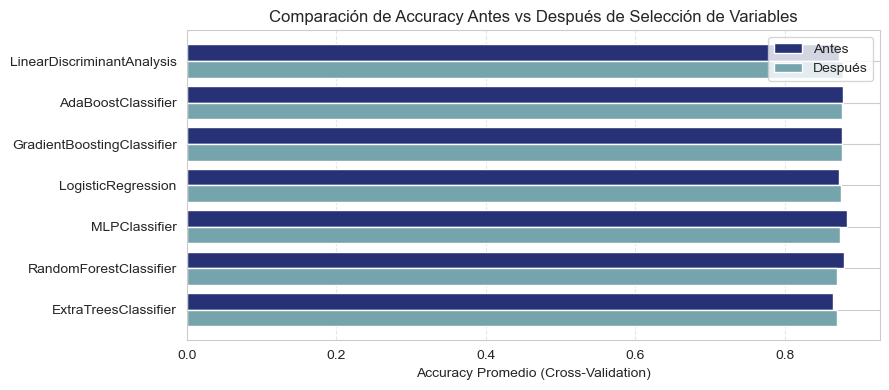

In [143]:
# Modelos a comparar
model_names = sorted(set(results_df["Model"]).intersection(retraining_results_df["Model"]))

# Filtrar y alinear  DataFrames
before = results_df[results_df["Model"].isin(model_names)].set_index("Model").loc[model_names]["Mean Accuracy"]
after = retraining_results_df[retraining_results_df["Model"].isin(model_names)].set_index("Model").loc[model_names]["Mean Accuracy"]

# DataFrame final 
df = pd.DataFrame({
    "Model": model_names,
    "Before": before.values,
    "After": after.values
})

df = df.sort_values(by="After", ascending=True)

# Gráfico
plt.figure(figsize=(9, 4))
bar_width = 0.4
index = range(len(df))

plt.barh([i + bar_width for i in index], df["Before"], height=bar_width, label="Antes", color="#273176")
plt.barh(index, df["After"], height=bar_width, label="Después", color="#76A4AC")

plt.yticks([i + bar_width / 2 for i in index], df["Model"])
plt.xlabel("Accuracy Promedio (Cross-Validation)")
plt.title("Comparación de Accuracy Antes vs Después de Selección de Variables")
plt.legend()
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


**Curva ROC/AUC**

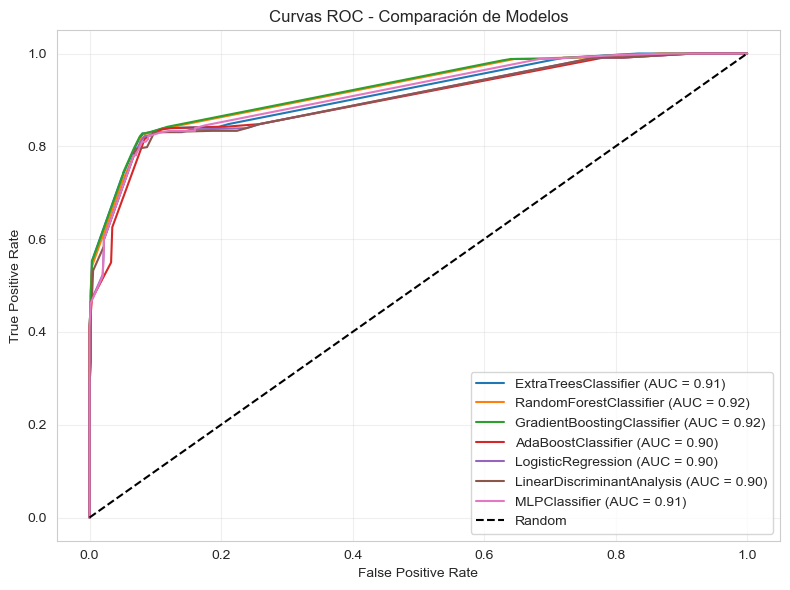

In [144]:
plt.figure(figsize=(8, 6))

for name, model in selected_models_final:
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(x_train)[:, 1]
    else:
        y_scores = model.decision_function(x_train)

    fpr, tpr, _ = roc_curve(y_train, y_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

# Línea base 
plt.plot([0, 1], [0, 1], 'k--', label='Random')

# Gráfico
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC - Comparación de Modelos')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



**Ensemble**

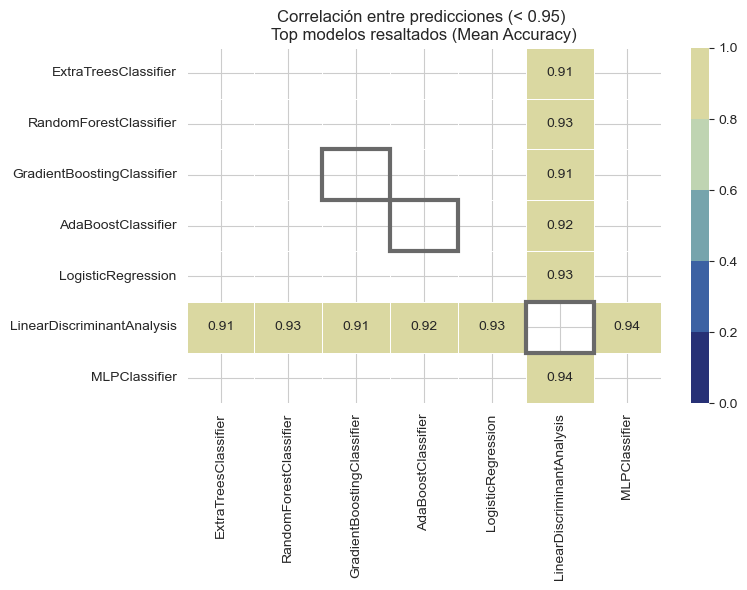

In [145]:
# Conversión a diccionario
selected_models_dict = dict(selected_models_final)

# Predicciones -conjunto de prueba
test_preds_extc = pd.Series(selected_models_dict["ExtraTreesClassifier"].predict(x_test), name="ExtraTreesClassifier")
test_preds_rfc  = pd.Series(selected_models_dict["RandomForestClassifier"].predict(x_test), name="RandomForestClassifier")
test_preds_gbc  = pd.Series(selected_models_dict["GradientBoostingClassifier"].predict(x_test), name="GradientBoostingClassifier")
test_preds_ada  = pd.Series(selected_models_dict["AdaBoostClassifier"].predict(x_test), name="AdaBoostClassifier")
test_preds_log  = pd.Series(selected_models_dict["LogisticRegression"].predict(x_test), name="LogisticRegression")
test_preds_lda  = pd.Series(selected_models_dict["LinearDiscriminantAnalysis"].predict(x_test), name="LinearDiscriminantAnalysis")
test_preds_mlp  = pd.Series(selected_models_dict["MLPClassifier"].predict(x_test), name="MLPClassifier")

# Concatenar resultados
ensemble_results = pd.concat([test_preds_extc, test_preds_rfc, test_preds_gbc, test_preds_ada, test_preds_log, test_preds_lda, test_preds_mlp], axis=1)

# Matriz de correlación
corr_matrix = ensemble_results.corr()

# Máscara para ocultar correlaciones >= 0.95
mask = corr_matrix >= 0.95
np.fill_diagonal(mask.values, True)

# Top 3 modelos 
top_models = retraining_results_df.sort_values(by="Mean Accuracy", ascending=False).head(3)["Model"].tolist()

# Heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(corr_matrix, annot=True, mask=mask, cmap=palette, linewidths=0.5, vmin=0.0, vmax=1.0)

# Marca top modelos 
for label in top_models:
    idx = corr_matrix.columns.get_loc(label)
    ax.add_patch(plt.Rectangle((idx, idx), 1, 1, fill=False, edgecolor='dimgray', lw=3))

plt.title("Correlación entre predicciones (< 0.95) \nTop modelos resaltados (Mean Accuracy)")
plt.tight_layout()
plt.show()

**Votting**

In [146]:
# Cargar datos
#X = x_train
#y = y_train

# Combinaciones a evaluar
combinations = [
     ("Voting Ensemble (MLP + LOG + GBC)", ["MLPClassifier", "LogisticRegression", "GradientBoostingClassifier"]),
     ("Voting Ensemble (MLP + LOG +  ADA)", ["MLPClassifier", "LogisticRegression", "AdaBoostClassifier"]), 
     ("Voting Ensemble (MLP + RF + GBC)", ["MLPClassifier", "RandomForestClassifier", "GradientBoostingClassifier"]),
               
]

# Resultados
ensemble_results = []

# Evaluar cada combinación
for model_name, model_keys in combinations:
    estimators = []
    for key in model_keys:
        model_class = type(selected_models_dict[key])  # Obtener clase del modelo
        model_instance = model_class(**selected_models_dict[key].get_params())
        estimators.append((key.split("Classifier")[0], model_instance))  

    # Crear y evaluar ensemble
    ensemble = VotingClassifier(estimators=estimators, voting='soft')
    cv_scores = cross_val_score(ensemble, x_train, y_train, cv=5, scoring='accuracy')
    ensemble_results.append({
        "Modelo": model_name,
        "Accuracy promedio (CV=5)": cv_scores.mean(),
        "Desviación estándar": cv_scores.std()
    })

# Resultados
ensemble_df = pd.DataFrame(ensemble_results).sort_values(by="Accuracy promedio (CV=5)", ascending=False)
display("Resultado Voting Ensamble", ensemble_df)


'Resultado Voting Ensamble'

Modelo  Accuracy promedio (CV=5)  \
0   Voting Ensemble (MLP + LOG + GBC)                  0.878752   
1  Voting Ensemble (MLP + LOG +  ADA)                  0.877629   
2    Voting Ensemble (MLP + RF + GBC)                  0.877629   

   Desviación estándar  
0             0.019816  
1             0.020997  
2             0.018090

**Comparación Modelos Internos de Ensamble**

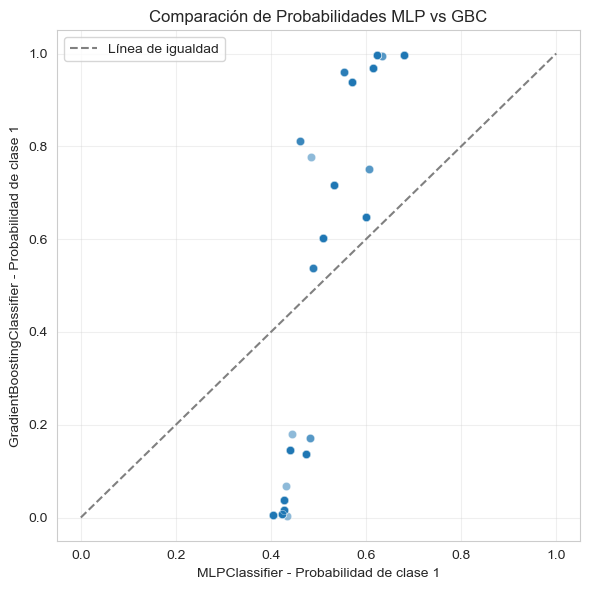

In [147]:
# Probabilidades de predicción clase 1 (sobrevivió)
mlp_proba = selected_models_dict["MLPClassifier"].predict_proba(x_test)[:, 1]
gbc_proba = selected_models_dict["GradientBoostingClassifier"].predict_proba(x_test)[:, 1]

# DataFrame a graficar
df_proba = pd.DataFrame({
    "MLPClassifier": mlp_proba,
    "GradientBoostingClassifier": gbc_proba
})

# Gráfico dispersión
plt.figure(figsize=(6, 6))
sns.scatterplot(x="MLPClassifier", y="GradientBoostingClassifier", data=df_proba, alpha=0.5)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Línea de igualdad')
plt.xlabel("MLPClassifier - Probabilidad de clase 1")
plt.ylabel("GradientBoostingClassifier - Probabilidad de clase 1")
plt.title("Comparación de Probabilidades MLP vs GBC")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


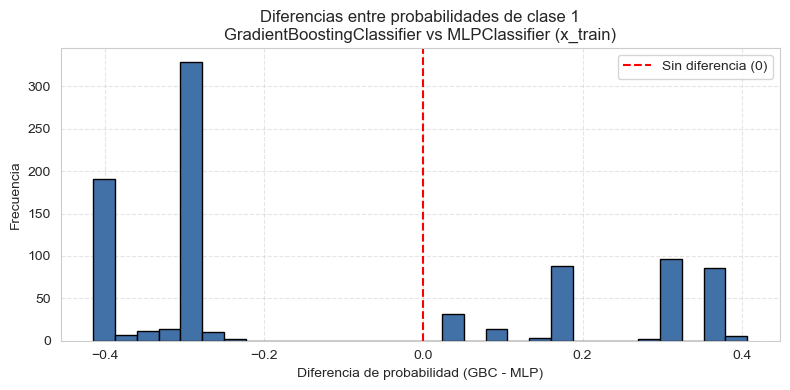

In [148]:
# Probabilidades de clase 1 para cada modelo -conjunto de entrenamiento
proba_mlp_train = selected_models_dict["MLPClassifier"].predict_proba(x_train)[:, 1]
proba_gbc_train = selected_models_dict["GradientBoostingClassifier"].predict_proba(x_train)[:, 1]

# Diferencia de probabilidades
prob_diff_train = proba_gbc_train - proba_mlp_train

# Histograma de diferencias
plt.figure(figsize=(8, 4))
plt.hist(prob_diff_train, bins=30, edgecolor='black', color='#4271A8')
plt.axvline(0, color='red', linestyle='--', label='Sin diferencia (0)')
plt.xlabel("Diferencia de probabilidad (GBC - MLP)")
plt.ylabel("Frecuencia")
plt.title("Diferencias entre probabilidades de clase 1\nGradientBoostingClassifier vs MLPClassifier (x_train)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


**Stacking**

In [149]:
# Modelos base 
base_estimators = [
    ('MLP', selected_models_dict["MLPClassifier"]),
    ('ADA', selected_models_dict["AdaBoostClassifier"]),
    ('LDA', selected_models_dict["LinearDiscriminantAnalysis"])
]

# Meta-modelos a comparar
final_estimators = {
    "Stacking-LogisticRegression": LogisticRegression(max_iter=1000),
    "Stacking-DecisionTree": DecisionTreeClassifier(max_depth=3),
    "Stacking-RandomForest": RandomForestClassifier(n_estimators=100, max_depth=3),
    "Stacking-GradientBoosting": GradientBoostingClassifier(n_estimators=100),
    "Stacking-XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar stacking con diferente final_estimator
results_stacking = []

for name, meta_model in final_estimators.items():
    stack = StackingClassifier(
        estimators=base_estimators,
        final_estimator=meta_model,
        stack_method='predict_proba',
        cv=cv,
        n_jobs=-1
    )
    scores = cross_val_score(stack, x_train, y_train, cv=cv, scoring='accuracy')
    results_stacking.append({
        "Final Estimator": name,
        "Accuracy promedio (CV=5)": scores.mean(),
        "Desviación estándar": scores.std()
    })

# Ordenar por desempeño
results_stacking_df = pd.DataFrame(results_stacking).sort_values(by="Accuracy promedio (CV=5)", ascending=False)
display("Resultados Stacking Ensemble", results_stacking_df)

'Resultados Stacking Ensemble'

Final Estimator  Accuracy promedio (CV=5)  Desviación estándar
0  Stacking-LogisticRegression                  0.875444             0.019415
4             Stacking-XGBoost                  0.872073             0.019116
2        Stacking-RandomForest                  0.870950             0.016881
3    Stacking-GradientBoosting                  0.869826             0.019135
1        Stacking-DecisionTree                  0.863097             0.020732

**Mejor Modelo**

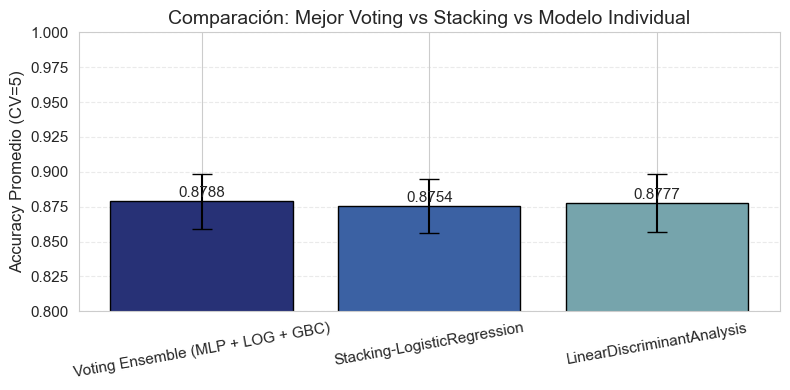

Modelo  Accuracy Promedio (CV=5)  \
0  Voting Ensemble (MLP + LOG + GBC)                  0.878752   
1        Stacking-LogisticRegression                  0.875444   
2         LinearDiscriminantAnalysis                  0.877679   

   Desviación Estándar  
0             0.019816  
1             0.019415  
2             0.020752

In [150]:
# Obtención de resultados
comparison_data = {
    "Modelo": [
        ensemble_df.iloc[0,0],
        results_stacking_df.iloc[0,0],
        retraining_results_df.iloc[0,0]
    ],
    "Accuracy Promedio (CV=5)": [ensemble_df.iloc[0,1], results_stacking_df.iloc[0,1], retraining_results_df.iloc[0,1]],  # Valores estimados de ejemplo
    "Desviación Estándar": [ensemble_df.iloc[0,2], results_stacking_df.iloc[0,2], retraining_results_df.iloc[0,2]]
}

df_comparison = pd.DataFrame(comparison_data)

# Gráfico comparativo
plt.figure(figsize=(8, 4))
bars = plt.bar(
    df_comparison["Modelo"],
    df_comparison["Accuracy Promedio (CV=5)"],
    yerr=df_comparison["Desviación Estándar"],
    capsize=7,
    color=palette,
    edgecolor="black"
)

plt.ylabel("Accuracy Promedio (CV=5)", fontsize=12)
plt.title("Comparación: Mejor Voting vs Stacking vs Modelo Individual", fontsize=14)
plt.ylim(0.80, 1)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.xticks(rotation=10, fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.001,
             f"{height:.4f}", ha='center', va='bottom', fontsize=11)

plt.show()

df_comparison

**Entrenamiento Mejor Modelo**

In [151]:
# Ensamble final
mlp = selected_models_dict["MLPClassifier"]
rf = selected_models_dict["RandomForestClassifier"]
gbc = selected_models_dict["GradientBoostingClassifier"]

final_ensemble = VotingClassifier(
    estimators=[
        ("MLP", mlp),
        ("RF", rf),
        ("GBC", gbc)
    ],
    voting='soft'
)

# Entrenar ensamble -conjunto de entrenamiento
final_ensemble.fit(x_train, y_train)

VotingClassifier(estimators=[('MLP',
                              MLPClassifier(alpha=0.001, early_stopping=True,
                                            hidden_layer_sizes=(150, 75),
                                            max_iter=1000, random_state=42)),
                             ('RF',
                              RandomForestClassifier(max_depth=10,
                                                     min_samples_leaf=4,
                                                     min_samples_split=15,
                                                     n_estimators=300,
                                                     random_state=42)),
                             ('GBC',
                              GradientBoostingClassifier(learning_rate=0.05,
                                                         max_depth=2,
                                                         min_samples_leaf=6,
                                                         n_estimators=300,
                                                         random_state=42,
                                                         subsample=0.7))],
                 voting='soft')

**Desempeño Mejor Modelo**

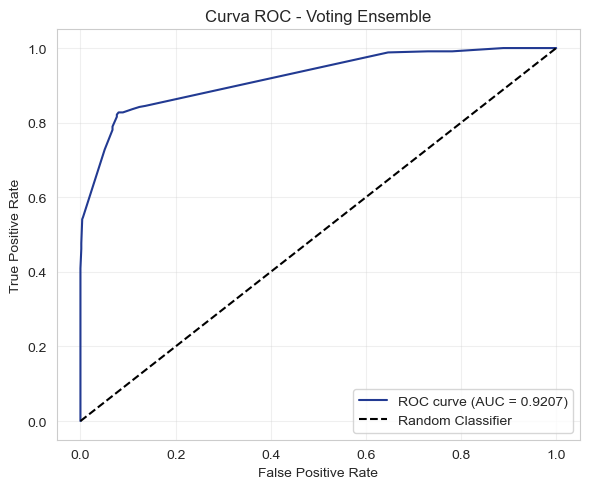

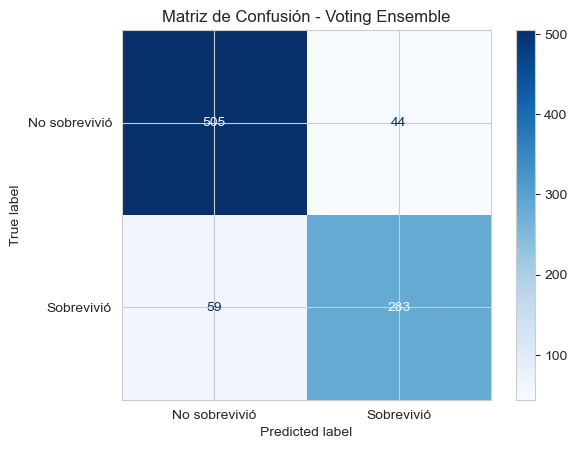

Clasification Report:

               precision    recall  f1-score   support

No sobrevivió       0.90      0.92      0.91       549
   Sobrevivió       0.87      0.83      0.85       342

     accuracy                           0.88       891
    macro avg       0.88      0.87      0.88       891
 weighted avg       0.88      0.88      0.88       891



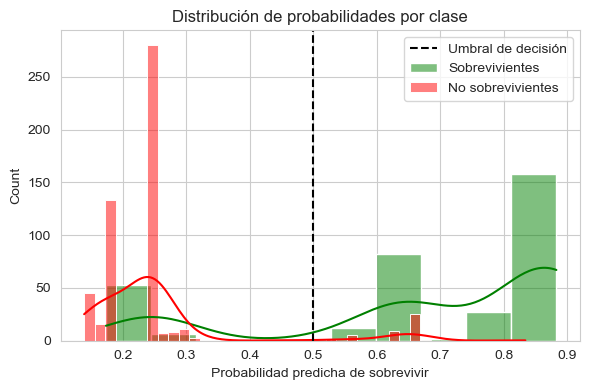

In [152]:
# Predicciones probabilísticas 
y_pred_prob = final_ensemble.predict_proba(x_train)[:, 1]
y_pred = final_ensemble.predict(x_train)

# Curva ROC
fpr, tpr, _ = roc_curve(y_train, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})', color="#223A92")
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Voting Ensemble')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Matriz de Confusión
cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["No sobrevivió", "Sobrevivió"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión - Voting Ensemble")
plt.show()

# Classification Report
print("Clasification Report:\n")
print(classification_report(y_train, y_pred, target_names=["No sobrevivió", "Sobrevivió"]))

# Distribución de Errores
plt.figure(figsize=(6, 4))
sns.histplot(y_pred_prob[y_train==1], color="green", label="Sobrevivientes", kde=True)
sns.histplot(y_pred_prob[y_train==0], color="red", label="No sobrevivientes", kde=True)
plt.axvline(0.5, color="black", linestyle="--", label="Umbral de decisión")
plt.xlabel("Probabilidad predicha de sobrevivir")
plt.title("Distribución de probabilidades por clase")
plt.legend()
plt.tight_layout()
plt.show()

**Predicción**

In [153]:
# Predicciones
y_pred = final_ensemble.predict(x_test)

# DataFrame submission
submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],  
    "Survived": y_pred
})

# Exportar -CSV
submission.to_csv("submission.csv", index=False)